# Figure 6: PSD of Elasser Variables // Fluctuations

- PSD of Elasser variables \& fit
- PSD of velocity/magnetic field fluctuations  
- Quantification of Noise Floor of SPAN-I

In [1]:
!pip install tabulate
!pip install ssqueezepy

In [2]:
import ssqueezepy

def trace_PSD_cwt_ssqueezepy(x,
                             y,
                             z,
                             dt,
                             nv            = 16,
                             scales_type   = 'log-piecewise',
                             wavelet       = None,
                             wname         = None,
                             l1_norm       = False,
                             est_PSD       = True,
                             est_mod       = False):
    """
    Method to calculate the wavelet coefficients and  power spectral density using the Morlet wavelet method.
    Parameters
    ----------
    x,y,z: array-like
        the components of the field to apply wavelet tranform
    dt: float
        the sampling time of the timeseries
       
    scales: str['log', 'log-piecewise', 'linear', 'log:maximal', ...]
                / np.ndarray
            CWT scales.
    Returns
    -------
    W_x, W_y, W_zz: array-like
        component coeficients of th wavelet tranform
    freq : list
        Frequency of the corresponding psd points.
    psd : list
        Power Spectral Density of the signal.
    scales : list
        The scales at which wavelet was estimated
    """
    N = len(x)
    if wavelet is None:
        wavelet    = ssqueezepy.Wavelet(('morlet', {'mu': 13.4}))
    else:
        wavelet    = ssqueezepy.Wavelet((wname, {'mu': 13.4}))  
       
    if  scales_type  is  None:
        scales_type  = 'log'

    # Estimate sampling frequency
    fs          = 1/dt
   
    # Estimate wavelet coefficients
    Wx, scales  = ssqueezepy.cwt(x, wavelet,  scales_type , fs, l1_norm=l1_norm, nv=nv)
    Wy, _       = ssqueezepy.cwt(y, wavelet, scales_type , fs, l1_norm=l1_norm, nv=nv)
    Wz, _       = ssqueezepy.cwt(z, wavelet, scales_type , fs, l1_norm=l1_norm, nv=nv)
     
    if est_mod:
        Wmod , _  = ssqueezepy.cwt(np.sqrt(x**2 + y**2 + z**2), wavelet,  scales_type , fs, l1_norm=l1_norm, nv=nv)
    else:
        Wmod      = None
   
    # Estimate corresponding frequencies
    freqs       = ssqueezepy.experimental.scale_to_freq(scales, wavelet, len(x), fs)
   
    if est_PSD:
        # Estimate trace powers pectral density
        PSD        = (np.nanmean(np.abs(Wx)**2, axis=1) + np.nanmean(np.abs(Wy)**2, axis=1) + np.nanmean(np.abs(Wz)**2, axis=1)   )*( 2/fs)
           
        if est_mod:
            PSD_mod = (np.nanmean(np.abs(Wmod)**2, axis=1)  )*( 2/fs)
        else:
            PSD_mod     = None
    else:
        PSD        = None
        PSD_mod     = None
   

    return Wx, Wy, Wz, Wmod, freqs, PSD*N, PSD_mod*N, scales # On purpose! only 

In [3]:
import glob
# import pyspedas
# from pyspedas import time_string, time_double
# from pytplot import tplot, get_data, cdf_to_tplot, store_data
import astrospice
import sunpy 
import sunpy.coordinates as scoords
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from scipy import stats

from scipy.optimize import curve_fit
from tabulate import tabulate

import sys, os
import datetime
import numpy as np
sys.path.append(os.path.realpath(''))
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt

import utilities as utils
import sigma as sigma
# import tools.psp_funcs as psp_funcs
# import tools.pfss_funcs as pfss_funcs
# from tools.plotting import plot_pfss
# from tools.settings import CsvDir, ImgDir, PlotDir, DataDir
import matplotlib.ticker as ticker
from scipy.signal.windows import tukey

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from datetime import timedelta

# for sc in ['psp','solar orbiter'] : kernels = astrospice.registry.get_kernels(sc,'predict') 

# REGIONS
loc_hcs = [61.5, 62.2]
loc_hcs1 = [357.7, 357.9]
ssw = [9, 19]
fsw = [42, 52]

# COLORS
scol, hcol, fcol, rcol = ['lavender', 'azure', 'lavenderblush', 'grey']
cc = ['lightpink', 'mediumspringgreen', 'peachpuff', 'powderblue', 'thistle', 'palegoldenrod']

# DIRECTORIES
RES_DIR = os.path.join('/Users/tamarervin/', 'e15_results')
FIG_DIR = os.path.realpath('figures')
EPS_DIR = os.path.realpath('eps_figures')
OBS_DIR = '/Users/tamarervin/products/csv_files/calcs/'
PlotDir = '/Users/tamarervin/mplstyle/'


# PLOT STYLING
plot_style = os.path.join(PlotDir, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.rcParams.update({'font.size': 20})
plt.style.use(plot_style)
plt.rcParams['axes.linewidth'] = 5

enc='E15'


In [4]:
def plot_elsasser(Zp, Zm, ih, il, im, uh, ul, FT):
    # Plot the PSD

    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[20, 10], sharex='all', sharey='all', gridspec_kw={'hspace': 0.05, 'wspace':0.1})
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']
    lw=2
    ##### -------- ELASSER SPECTRA #####
    ax = ax1
    for i, psd_spec in enumerate([Zp]):
        ax.plot(psd_spec.freq, psd_spec.power, c=colors[i], label=labels[i], linewidth=lw)
        
    ax.plot(Zp.freq[uh], np.exp(ih)*(Zp.freq[uh]**-1), c='k', linestyle='dashed', label=f'$f^{{{-1}}}$', zorder=10, lw=3)
    ax.plot(Zp.freq[ul], np.exp(il)*(Zp.freq[ul]**-1.5), c='cyan', label=f'$f^{{{-1.5}}}$', zorder=10, lw=3)

    # ax.plot(psd_Zp3.freq[u3h], np.exp(i3h)*(psd_Zp3.freq[u3h]**e3h), c='k', linestyle='dashed', label=f'$f^{{{e3h:.2f}}}$', zorder=10, lw=3)
    # ax.plot(psd_Zp3.freq[u3l], np.exp(i3l)*(psd_Zp3.freq[u3l]**e3l), c='chocolate', label=f'$f^{{{e3l:.2f}}}$', zorder=10, lw=3)

    ax.axvline(FT, c='k', linestyle='dashed')


    ### LEGEND
    ax.legend(loc='lower left', fontsize=20)

    ### ADD PANEL LABELS
    ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
    ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
    ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18) 
    ax.set_xscale('log')  
    ax.set(xlim=(5e-5, 5e-1))
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

    ##### -------- ELASSER SPECTRA #####
    ax = ax2
    for i, psd_spec in enumerate([Zm]): # , 
        ax.plot(psd_spec.freq, psd_spec.power, c=colors[i+1], label=labels[i+1], linewidth=lw)
        
    # ax.plot(psd_Zm3.freq, np.exp(i3lm)*(psd_Zm3.freq**e3lm), c='slateblue', label=f'$f^{{{e3lm:.2f}}}$', zorder=10, lw=3)
    ax.plot(Zm.freq, np.exp(im)*(Zm.freq**-1.25), c='green', label=f'$f^{{{-1.25}}}$', zorder=10, lw=3)

    ax.axvline(FT, c='k', linestyle='dashed')


    ### LEGEND
    ax.legend(loc='lower left', fontsize=20)

    ### ADD PANEL LABELS
    ax.text(0.92, 0.95, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
    ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
    ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18) 
    ax.set_xscale('log')  
    ax.set(xlim=(5e-5, 5e-1))
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

# Data

In [5]:
df = pd.read_csv('/Users/tamarervin/e15_results/turb.csv')
df['timestamp'] = pd.to_datetime(df['Time'])
df['use_dens'] = df['Np'].rolling(window=171, min_periods=1).mean()

df['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f') for d in df.Time]
df['sigmac'],df['sigmar'], df['vA'], df['Zp'],df['Zm'], df['deltav'], df['deltab'], df['rA'] = sigma.calc_sigma(df, num=314*3)


AttributeError: 'DataFrame' object has no attribute 'polarity'

Text(0.5, 1.0, '10-minute Moving Average over $N_p$ used for turbulence parameters')

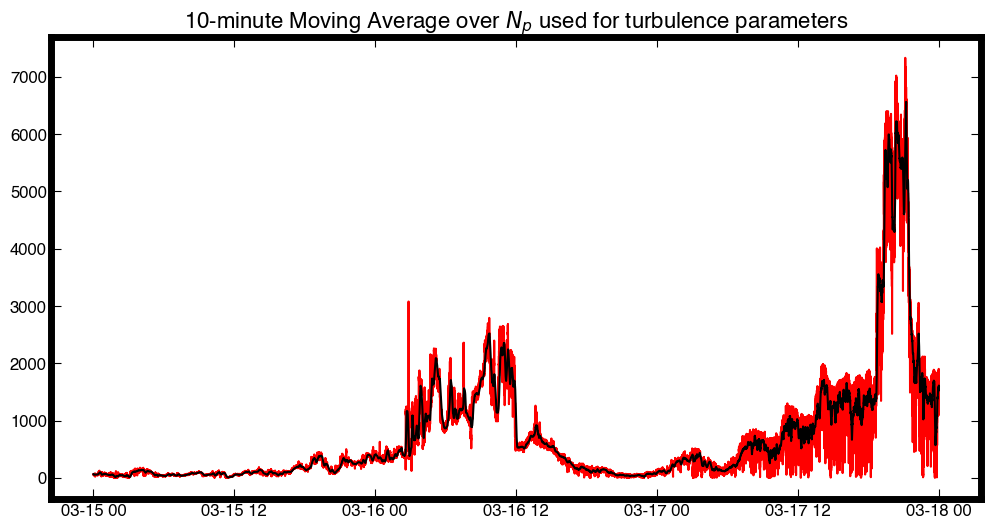

In [6]:
### CALCULATE DENSITY AVERAGE: TEN MINUTE INTERVAL
df['timestamp'] = pd.to_datetime(df['Time'])
df['use_dens'] = df['Np'].rolling(window=171, min_periods=1).mean()
df

plt.figure(figsize=(12, 6))
plt.plot(df.Time, df.Np, c='red', label='Np')
plt.plot(df.Time, df.use_dens, c='k', label='Average')
plt.title('10-minute Moving Average over $N_p$ used for turbulence parameters')

In [7]:
# ### READ IN DATA ###
parker, parkerdownt, parkerdownl, pss, orbiter, orbiterdownl, orbiterdownt, oss, wind, winddownt, winddownl, wss = utils.read_data(RES_DIR, sigma_time=20, pp='parker20.csv', pflag=True)

### DEFINE REGIONS ###
lon_footpoints = parker.sslon
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
hhcs1 = np.logical_and(lon_footpoints >= loc_hcs1[0], lon_footpoints <=loc_hcs1[1])
slow = np.logical_and(lon_footpoints >=ssw[0], lon_footpoints <=ssw[1])
fast = np.logical_and(lon_footpoints >=fsw[0], lon_footpoints <=fsw[1])

/Users/tamarervin/publications/e15/utilities.py:186: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()
/Users/tamarervin/publications/e15/utilities.py:186: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()
/Users/tamarervin/publications/e15/utilities.py:195: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.

# Read in Data

In [3]:
time_range = ['2023-03-16/12:00', '2023-03-17/06:00']
fields_vars = pyspedas.psp.fields(trange=time_range, time_clip=True, datatype='mag_RTN_4_Sa_per_Cyc')
pvars = pyspedas.psp.spi(trange=time_range, datatype='sf00_l3_mom', level='l3', time_clip=True)


NameError: name 'pyspedas' is not defined

In [ ]:
fields_files = glob.glob(os.path.join(os.path.realpath(os.path.join('psp_data', 'fields/l2/mag_rtn_4_per_cycle/2023')), "*"), recursive=True)
proton_files = glob.glob(os.path.join(os.path.realpath(os.path.join('psp_data', 'sweap/spi/l3/spi_sf00_l3_mom/2023')), "*"), recursive=True)
fields_vars = cdf_to_tplot(fields_files)
pvars = cdf_to_tplot(proton_files)

In [ ]:
# dt = get_data('psp_spi_VEL_RTN_SUN')
# dt2 = get_data('psp_spi_DENS')
# dt3 = get_data('psp_spi_TEMP')
dt = get_data('VEL_RTN_SUN')
dt2 = get_data('DENS')
dt3 = get_data('TEMP')
date_obj = [datetime.datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in dt.times]

rd = {'Time': date_obj, 'vr': np.abs(dt.y[:, 0]), 'vt': dt.y[:, 1], 'vn': dt.y[:, 2], 'Np': dt2.y, 'Tp': dt3.y}
df = pd.DataFrame(data=rd)

### ADD ANGLE
# vx, vy, vz = [get_data('psp_spi_VEL_SC').y[:, i] for i in np.arange(0, 3)]
# mx, my, mz = [get_data('psp_spi_MAGF_SC').y[:, i] for i in np.arange(0, 3)]
vx, vy, vz = [get_data('VEL_SC').y[:, i] for i in np.arange(0, 3)]
mx, my, mz = [get_data('MAGF_SC').y[:, i] for i in np.arange(0, 3)]
vdotb = vx*mx + vy*my + vz*mz
v = np.sqrt(vx**2 + vy**2 + vz**2)
b = np.sqrt(mx**2 + my**2 + mz**2)
angle_vb = np.arccos(vdotb/(v*b))

df['angle_vb'] = np.rad2deg(angle_vb)

df

In [ ]:
plt.plot(df.Time, df.angle_vb)

In [ ]:
dt = get_data('psp_fld_l2_mag_RTN_4_Sa_per_Cyc')
date_obj = [datetime.datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in dt.times]

rd = {'Time': date_obj, 'Br': dt.y[:, 0], 'Bt': dt.y[:, 1], 'Bn': dt.y[:, 2]}
dfmag = pd.DataFrame(data=rd)
dfmag['B'] = np.sqrt(dfmag.Br**2 + dfmag.Bn**2 + dfmag.Bt**2)
dfmag

In [ ]:
df = pd.merge_asof(df, dfmag)
df

In [ ]:
df['VA'] = df.B * 1e-9 / np.sqrt(1.25e-6 * df.Np * 1e6 * 1.67e-27) / 1000.0
df['mA'] = df.vr / df.VA
plt.plot(df.Time, df.mA)

In [ ]:
### CALCULATE DENSITY AVERAGE: TEN MINUTE INTERVAL
df['timestamp'] = pd.to_datetime(df['Time'])
df['use_dens'] = df['Np'].rolling(window=171, min_periods=1).mean()
df

plt.figure(figsize=(12, 6))
plt.plot(df.Time, df.Np, c='red', label='Np')
plt.plot(df.Time, df.use_dens, c='k', label='Average')
plt.title('10-minute Moving Average over $N_p$ used for turbulence parameters')

In [ ]:
### CALCULATE CROSS HELICITY VALUES
df['sigmac'],df['sigmar'], df['vA'], df['Zp'],df['Zm'], df['deltav'], df['deltab'] = sigma.calc_sigma(df, num=314)
plt.plot(df.Time, df.deltav)
plt.plot(df.Time, df.deltab)
plt.plot(df.Time, df.Zp)
plt.plot(df.Time, df.Zm)

In [ ]:
tplot(['psp_spi_VEL_RTN_SUN', 'psp_spi_EFLUX_VS_ENERGY',
 'psp_spi_EFLUX_VS_THETA',
 'psp_spi_EFLUX_VS_PHI','psp_spi_DENS', 'psp_fld_l2_mag_RTN_4_Sa_per_Cyc'])

# PSD Calculation

## Period Identification

In [85]:
### RESAMPLE 
turb = df

ss, ii = 6180//3, 3

### PERIOD ONE
use1 = np.logical_and(turb.Time >= pd.Timestamp('2023-03-16 12:00'), turb.Time <= pd.Timestamp('2023-03-16 18:00:00'))
t1 = turb[use1].copy()
tZp = [t1.Zp[i*ss:i*ss+ss] for i in range(0, ii)]
tZm = [t1.Zm[i*ss:i*ss+ss] for i in range(0, ii)]
tdv = [t1.deltav[i*ss:i*ss+ss] for i in range(0, ii)]
tdb = [t1.deltab[i*ss:i*ss+ss] for i in range(0, ii)]

### PERIOD TWO
use2 = np.logical_and(turb.Time >= pd.Timestamp('2023-03-16 18:00:00'), turb.Time <= pd.Timestamp('2023-03-17 00:00:03'))
t2 = turb[use2].copy()
tZp2 = [t2.Zp[i*ss:i*ss+ss] for i in range(0, ii)]
tZm2 = [t2.Zm[i*ss:i*ss+ss] for i in range(0, ii)]
tdv2 = [t2.deltav[i*ss:i*ss+ss] for i in range(0, ii)]
tdb2 = [t2.deltab[i*ss:i*ss+ss] for i in range(0, ii)]

### PERIOD THREE
use3 = np.logical_and(turb.Time >= pd.Timestamp('2023-03-17 00:00'), turb.Time <= pd.Timestamp('2023-03-17 06:00:00'))
t3 = turb[use3].copy()
tZp3 = [t3.Zp[i*ss:i*ss+ss] for i in range(0, ii)]
tZm3 = [t3.Zm[i*ss:i*ss+ss] for i in range(0, ii)]
tdv3 = [t3.deltav[i*ss:i*ss+ss] for i in range(0, ii)]
tdb3 = [t3.deltab[i*ss:i*ss+ss] for i in range(0, ii)]

### FULL 
use = np.logical_and(turb.Time >= pd.Timestamp('2023-03-16 12:00'), turb.Time <= pd.Timestamp('2023-03-17 06:00:00'))
tf = df[use].copy()
tZpf = [tf.Zp[i] for i in [use1, use2, use3]]
tZmf = [tf.Zm[i] for i in [use1, use2, use3]]
tdvf = [tf.deltav[i] for i in [use1, use2, use3]]
tdbf = [tf.deltab[i] for i in [use1, use2, use3]]


3
3


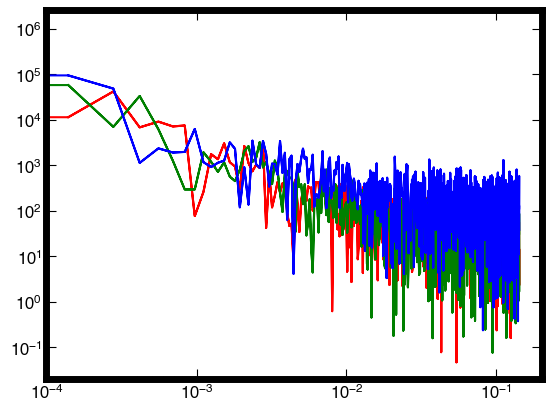

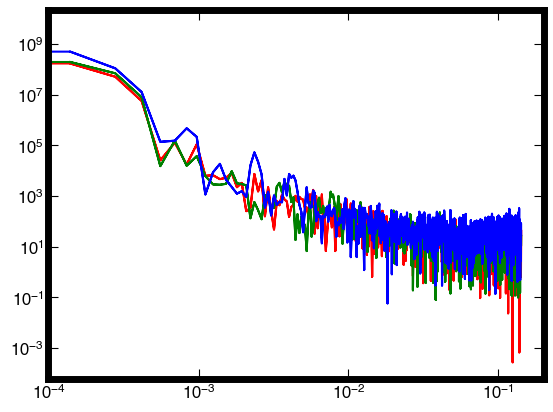

In [27]:
psd_Zm = windowed_psd(tZm)
t1['Zm2'] = np.sqrt((t1.vr - (t1.Br * 1e-9 / np.sqrt(1.25e-6 * t1.use_dens * 1e6 * 1.67e-27) / 1000.0)) ** 2 +  (t1.vn - (t1.Bn * 1e-9 / np.sqrt(1.25e-6 * t1.use_dens * 1e6 * 1.67e-27) / 1000.0)) ** 2 
+  (t1.vt - (t1.Bt * 1e-9 / np.sqrt(1.25e-6 * t1.use_dens * 1e6 * 1.67e-27) / 1000.0)) ** 2 )
tZm_new = [t1.Zm2[i*ss:i*ss+ss] for i in range(0, ii)]

psd_Zm_new = windowed_psd(tZm_new)

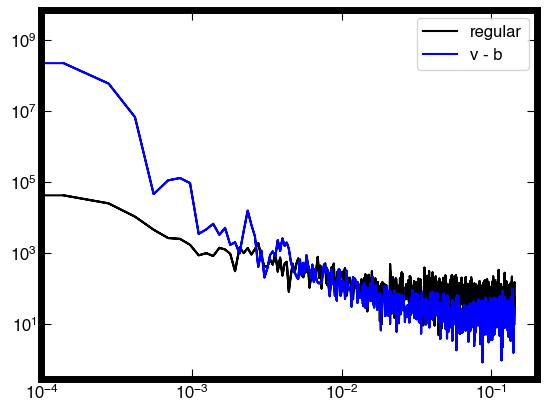

In [28]:
plt.loglog(psd_Zm.freq, psd_Zm.power, c='k', label='regular')
plt.loglog(psd_Zm_new.freq, psd_Zm_new.power, c='b', label='v - b')
plt.legend()

## Create Tukey Window

In [ ]:
### CREATE TUKEY WINDOW
N=1400
alpha = 0.5  
tukey_window = tukey(N, alpha)
plt.plot(tukey_window)

ww = 1/2 * (1 - np.cos((2 * np.pi * np.arange(0, N * alpha / 2)) / (alpha * N)))
ww1 = 1/2 * (1 - np.cos((2 * np.pi * np.arange(N / 2 + N * alpha / 2, N)) / (alpha * N)))

# Create the piecewise function
x = np.arange(0, N * alpha / 2)
y1 = ww
x2 = np.arange(N * alpha / 2, N / 2 + N * alpha / 2)
y2 = np.ones(len(x2))
x3 = np.arange(N / 2 + N * alpha / 2, N)
y3 = ww1

# Plot each segment with a specified color
plt.plot(x, y1, color='red')
plt.plot(x2, y2, color='orange')
plt.plot(x3, y3, color='green')
### CALCULATE Wss
### Wss = 1/N * sum(w[n]) 
Wss = np.sum(np.concatenate((y1, y2, y3)) ** 2) / N
plt.title('Tukey window normalization value is: ' + str(Wss) + '\n Alpha = ' + str(alpha) + '\n N = ' + str(N))

# Plot each segment with a specified color
plt.plot(x, y1, color='red')
plt.plot(x2, y2, color='orange')
plt.plot(x3, y3, color='green')

## PSD Calculation

In [67]:
def windowed_psd(series, sample_rate=3.5):
    dff, dfp, dfs = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    plt.figure()
    col=['red', 'green', 'blue', 'orange', 'purple', 'black']
    print(len(series))
    for i, time_series in enumerate(series):
        ### RESAMPLE DATA
        N = len(time_series)

        ### Create a Tukey window
        alpha = 0.5 
        tukey_window = tukey(N, alpha)
        windowed_time_series = time_series * tukey_window
        
        # Compute the FFT of the windowed time series
        fft_result = np.fft.fft(windowed_time_series) / N ## calculate FFT and normalize
        fft_freq = np.fft.fftfreq(len(fft_result), sample_rate)
        
        # Smoothed fourier transform
        fft_smooth = np.fft.irfft(fft_result)

        # Calculate the power spectral density
        power_spectrum = (2*N*sample_rate) * np.abs(fft_result)**2
        power_smooth = (2*N*sample_rate) * np.abs(fft_smooth)**2

        # normalize by the tukey window
        ww = 1/2 * (1 - np.cos((2 * np.pi * np.arange(0, N * alpha / 2)) / (alpha * N)))
        ww1 = 1/2 * (1 - np.cos((2 * np.pi * np.arange(N / 2 + N * alpha / 2, N)) / (alpha * N)))

        # Create the piecewise function
        y1 = ww
        x2 = np.arange(N * alpha / 2, N / 2 + N * alpha / 2)
        y2 = np.ones(len(x2))
        y3 = ww1

        ### CALCULATE Wss
        Wss = np.sum(np.concatenate((y1, y2, y3)) ** 2) / N
        power_spectrum /= Wss
        power_smooth /= Wss

        # Add to average
        dff[str(i)] = np.abs(fft_freq)
        dfp[str(i)] = power_spectrum
        dfs[str(i)] = power_smooth
        
        plt.loglog(dff[str(i)], dfp[str(i)] , color=col[i])
        # plt.loglog(dff[str(i)], dfs[str(i)] , color='k')

    dfp['freq'] = dff.mean(axis=1)
    dfp['power'] = dfp.mean(axis=1)
    dfp['smooth'] = dfs.mean(axis=1)
    return dfp


## Wavelet Method

In [ ]:
Wx, Wy, Wz, Wmod, freqs, PSD, PSD_mod, scales = trace_PSD_cwt_ssqueezepy(t1.vr, t1.vt, t1.vn, 3.5, est_mod=True)
plt.loglog(freqs, PSD)
plt.loglog(freqs, PSD_mod)

## Fourier Method

3
3
3
3


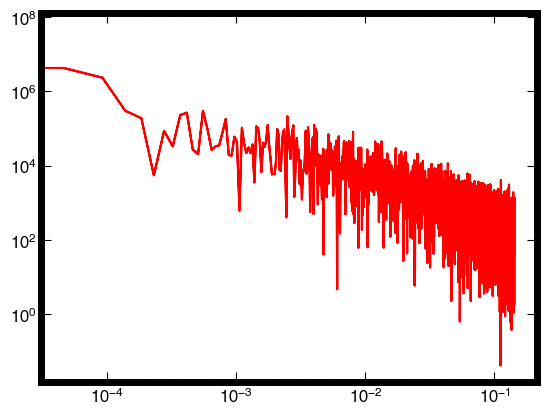

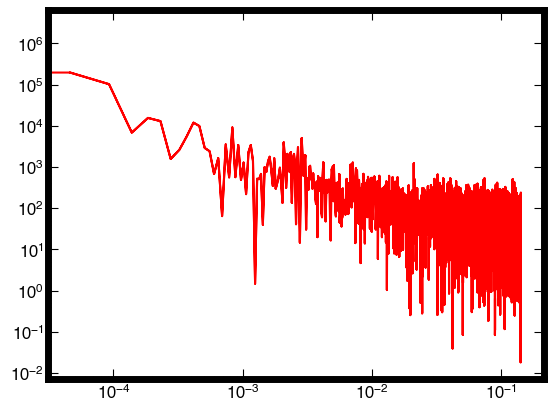

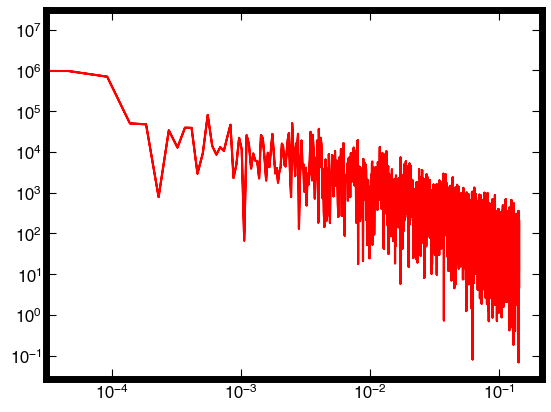

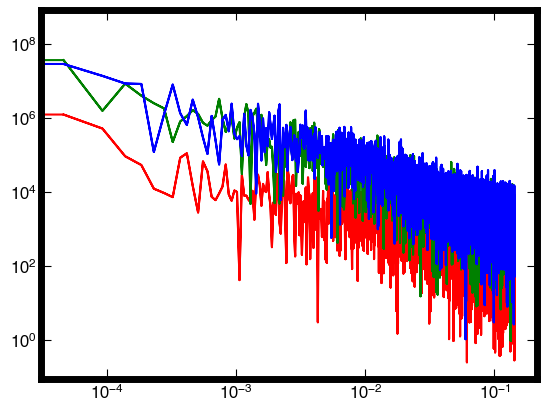

In [68]:
### Z plus
psd_Zpf = windowed_psd(tZpf)

### Z minus
psd_Zmf = windowed_psd(tZmf)

### Delta v
psd_dvf = windowed_psd(tdvf)

### Delta b
psd_dbf = windowed_psd(tdbf)

### PERIOD ONE

3
3
3
3


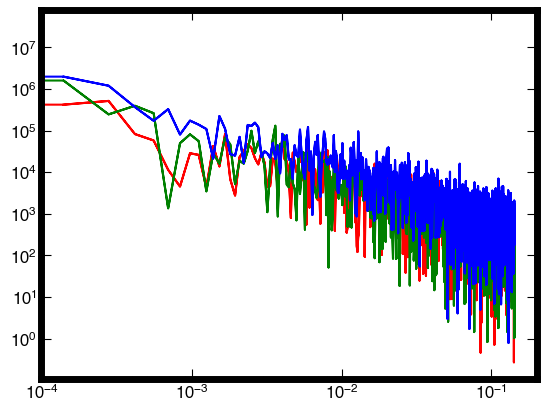

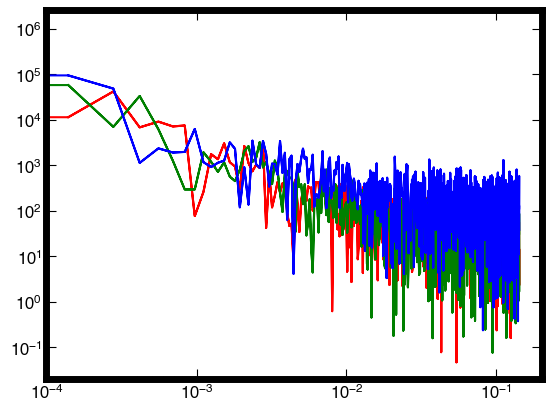

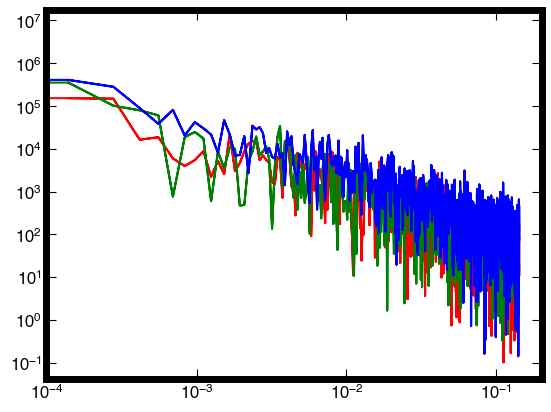

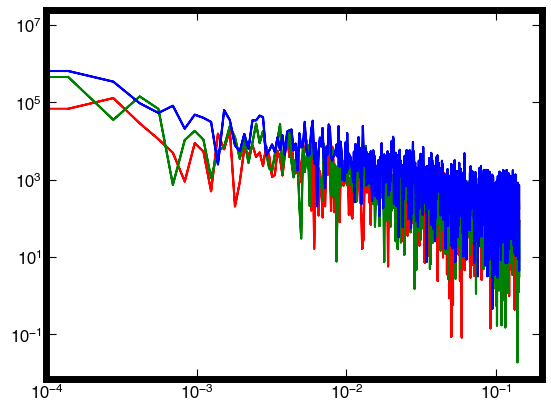

In [86]:
### Z plus
psd_Zp = windowed_psd(tZp)

### Z minus
psd_Zm = windowed_psd(tZm)

### Delta v
psd_dv = windowed_psd(tdv)

### Delta b
psd_db = windowed_psd(tdb)


### PERIOD TWO

3
3
3
3


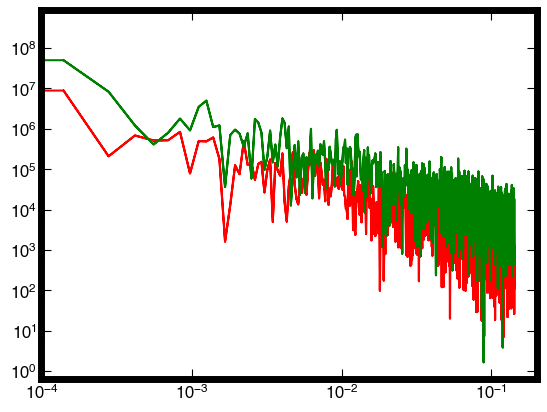

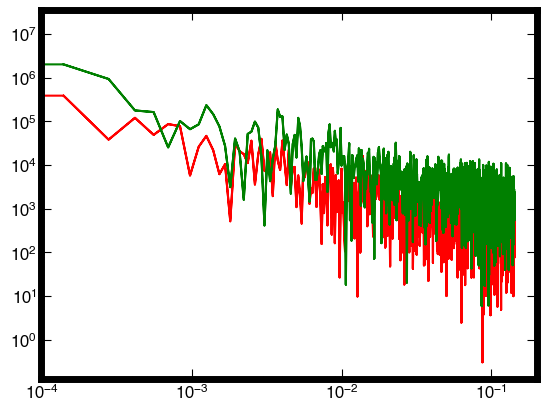

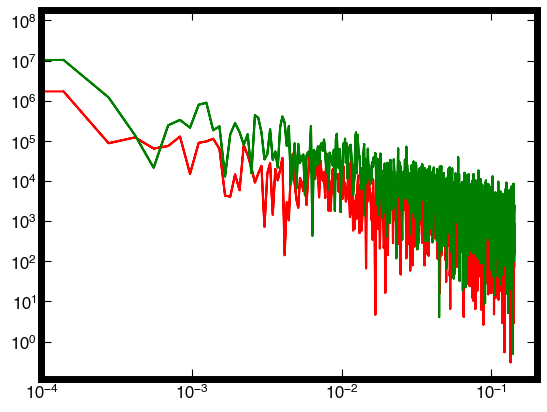

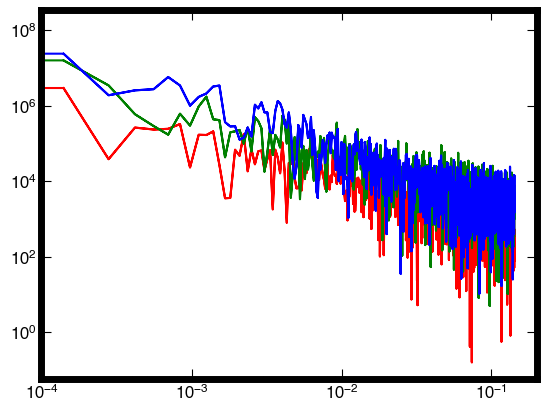

In [8]:
### Z plus
psd_Zp2 = windowed_psd(tZp2)

### Z minus
psd_Zm2 = windowed_psd(tZm2)

### Delta v
psd_dv2 = windowed_psd(tdv2)

### Delta b
psd_db2 = windowed_psd(tdb2)

### PERIOD THREE

3
3
3
3


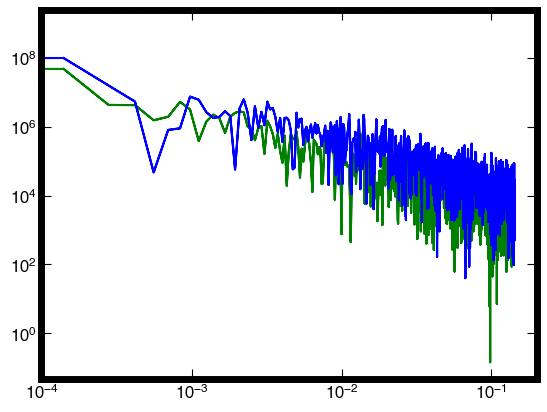

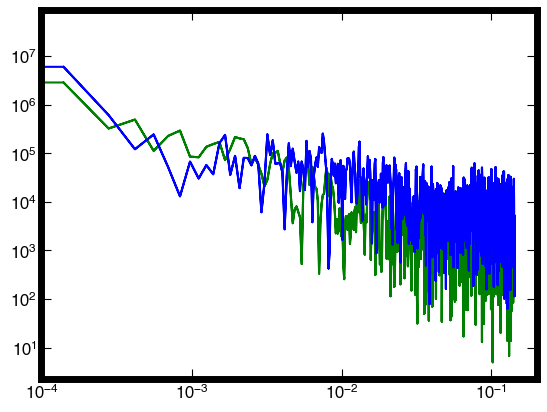

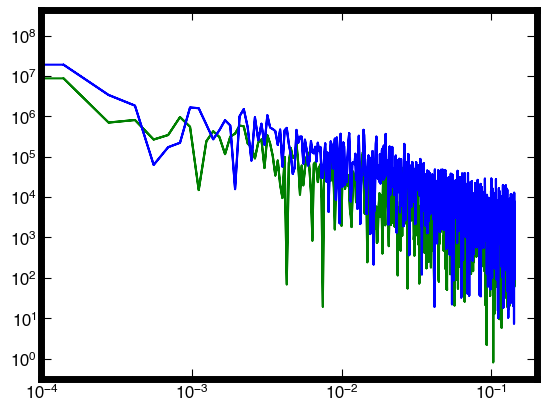

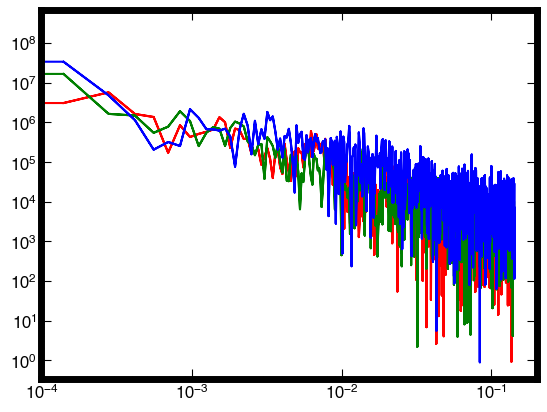

In [10]:
### Z plus
psd_Zp3 = windowed_psd(tZp3)

### Z minus
psd_Zm3 = windowed_psd(tZm3)

### Delta v
psd_dv3 = windowed_psd(tdv3)

### Delta b
psd_db3 = windowed_psd(tdb3)

# Plot

In [ ]:
# # Plot the PSD
# fig, axs = plt.subplots(2, 2, figsize=[20, 20], sharex='all', gridspec_kw={'wspace':0.10, 'hspace':0.10})

# colors = ['tab:green', 'tab:red', 'tab:blue', 'tab:orange']
# labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']
# lw=2

# ### ------------------------------------------------------- ###
#             ##### -------- INTERVAL ONE -------- #####
# ### ------------------------------------------------------- ###

# ##### -------- PANEL ONE: ELASSER SPECTRA -------- #####
# ax = axs[0][0]
# ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
# ax.set_title(r'$\rm Interval \; One: \; 2023-03-16/12:00 \; to \; 18:00$', fontsize=20)
# good = np.logical_and(np.array(psd_Zp.freq)<=1, np.array(psd_Zp.freq)>=1e-4)
# for i, psd_spec in enumerate([psd_dv, psd_db, psd_Zp, psd_Zm]):
#     ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i], label=labels[i], linewidth=lw)

# # ### PLOT FITS
# # use = np.logical_and(psd_Zp.freq>2e-4, psd_Zp.freq<2e-2)
# # freq = psd_Zp.freq[use]
# # kp = (2 * np.pi * freq)/(np.abs(u0 * np.cos(ang) - vA0))
# # y1 = fit_function_p(kp, Cp_fit1, shared_Cinf_fit1) 
# # ax.plot(freq, y1, c='k', lw=lw, zorder=2) 

# # km = (2 * np.pi * freq)/(np.abs(u0 * np.cos(ang) + vA0))
# # y2 = fit_function_m(km, Cm_fit1, shared_Cinf_fit1, kt_fit1)
# # ax.plot(freq, y2, c='k', lw=lw, zorder=2)  

# # ### THRESHOLD FREQUENCY
# # ax.scatter(ft1, fit_function_m(kt_fit1, Cm_fit1, shared_Cinf_fit1, kt_fit1), s=100, c='lavender', edgecolor='k', lw=0.5, zorder=3)
# # ax.annotate(r'$\rm f_t$',  xy=(ft1, fit_function_m(kt_fit1, Cm_fit1, shared_Cinf_fit1, kt_fit1)-0.5), xytext=(2e-3, 1),
# #              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=2),fontsize=18)

# ### LEGEND ###
# zp_patch = mpatches.Patch(color=colors[2], label=labels[0])
# zm_patch = mpatches.Patch(color=colors[3], label=labels[1])
# dv_patch = mpatches.Patch(color=colors[0], label=labels[2])
# db_patch = mpatches.Patch(color=colors[1], label=labels[3])
# leg0 = ax.legend(handles=[zp_patch, zm_patch, dv_patch, db_patch], loc='upper left', fontsize=20)
# ax.add_artist(leg0)

# ### ADD PANEL LABELS
# ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
# ax.tick_params(axis='both', which='major', labelsize=18) 
# ax.set_xscale('log')  
# ax.set_yscale('log')
# ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

# ### ------------------------------------------------------- ###
#             ##### -------- INTERVAL TWO -------- #####
# ### ------------------------------------------------------- ###

# ##### -------- PANEL THREE: ELASSER SPECTRA (P2) -------- #####
# ax = axs[0][1]
# ax.set_title(r'$\rm Interval \; Two: \; 2023-03-16/18:00 \; to \; 2023-03-17/00:00$', fontsize=20)
# good = np.logical_and(np.array(psd_Zp2.freq)<=1, np.array(psd_Zp2.freq)>=1e-4)
# for i, psd_spec in enumerate([psd_dv2, psd_db2, psd_Zp2, psd_Zm2]):
#     ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i], label=labels[i], linewidth=lw)

# # ### PLOT FITS
# # use = np.logical_and(psd_Zp.freq>2e-4, psd_Zp.freq<2e-2)
# # freq = psd_Zp.freq[use]
# # kp = (2 * np.pi * freq)/(np.abs(u02 * np.cos(ang2) - vA02))
# # y1 = fit_function_p(kp, Cp_fit2, shared_Cinf_fit2) 
# # ax.plot(freq, y1, c='k', lw=lw, zorder=2) 

# # km = (2 * np.pi * freq)/(np.abs(u02 * np.cos(ang2) + vA02))
# # y2 = fit_function_m(km, Cm_fit2, shared_Cinf_fit2, kt_fit2)
# # ax.plot(freq, y2, c='k', lw=lw, zorder=2)  

# # ### THRESHOLD FREQUENCY
# # ax.scatter(ft2, fit_function_m(kt_fit2, Cm_fit2, shared_Cinf_fit2, kt_fit2), s=100, c='lavender', edgecolor='k', lw=0.5, zorder=3)
# # ax.annotate(r'$\rm f_t$',  xy=(ft2, fit_function_m(kt_fit2, Cm_fit2, shared_Cinf_fit2, kt_fit2)-20), xytext=(9e-3, 12),
# #              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=2),fontsize=18)

# ### ADD PANEL LABELS
# ax.text(0.92, 0.95, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
# ax.tick_params(axis='both', which='major', labelsize=18) 
# ax.set_xscale('log')  
# ax.set_yscale('log')
# ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
# # axs[0].set(xticks=[1e-4, 1e-3, 1e-2, 1e-1], ylim=(5e-2, 5e6), yticks=[1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
# # axs[1].set(xticks=[1e-4, 1e-3, 1e-2, 1e-1], ylim=(5e-1, 5e7), yticks=[1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])

# ### ADD PANEL LABELS 
# # fig.text(0.06, 0.5, r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20, va='center', rotation='vertical')
# fig.text(0.475, 0.05, r'$\rm Frequency \; [Hz]$', fontsize=20, va='center', rotation='horizontal')

# ### TITLES
# # fig.text(0.5, 0.25, r'$\rm Sub-Alfv\'enic \; Interval \; One: \; 2023-03-16/12:00 \; to \; 18:00$', fontsize=20, ha='center', va='center', rotation='horizontal') # period one
# # fig.text(0.5, 0.75, r'$\rm Sub-Alfv\'enic \; Interval \; Two: \; 2023-03-17/00:00 \; to \; 16:00$', fontsize=20, ha='center', va='center', rotation='horizontal') # period two


# ### ------------------------------------------------------- ###
#             ##### -------- INTERVAL THREE -------- #####
# ### ------------------------------------------------------- ###

# ##### -------- PANEL THREE: ELASSER SPECTRA (P2) -------- #####
# ax = axs[1][0]
# ax.set_title(r'$\rm Interval \; Three: \; 2023-03-17/00:00 \; to \; 06:00$', fontsize=20)
# good = np.logical_and(np.array(psd_Zp2.freq)<=1, np.array(psd_Zp2.freq)>=1e-4)
# for i, psd_spec in enumerate([psd_dv3, psd_db3, psd_Zp3, psd_Zm3]):
#     ax.loglog(psd_spec.freq[good], psd_spec.power[good], c=colors[i], label=labels[i], linewidth=lw)

# ##### -------- PANEL THREE: ELASSER SPECTRA (P2) -------- #####
# ax = axs[1][1]
# ax.set_title(r'$\rm Full \; Period$', fontsize=20)
# good = np.logical_and(np.array(psd_Zpf.freq)<=1, np.array(psd_Zpf.freq)>=1e-4)
# for i, psd_spec in enumerate([psd_dvf, psd_dbf, psd_Zpf, psd_Zmf]):
#     ax.loglog(psd_spec.freq[good], psd_spec.power[good], c=colors[i], label=labels[i], linewidth=lw)


# ### SAVE FIGURE
# plt.tight_layout()
# # plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'fig4.png')), bbox_inches='tight')
# # plt.savefig(os.path.realpath(os.path.join(EPS_DIR, 'fig4.eps')), bbox_inches='tight')


# Spectral Fitting

In [11]:
parker = df

def windowed_psd(time_series, sample_rate=3.5):
    dff, dfp, dfs = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    plt.figure()
    col=['red', 'green', 'blue', 'orange', 'purple', 'black']
    ### RESAMPLE DATA
    N = len(time_series)

    ### Create a Tukey window
    alpha = 0.5 
    tukey_window = tukey(N, alpha)
    windowed_time_series = time_series * tukey_window
    
    # Compute the FFT of the windowed time series
    fft_result = np.fft.fft(windowed_time_series) / N ## calculate FFT and normalize
    fft_freq = np.fft.fftfreq(len(fft_result), sample_rate)
    
    # Smoothed fourier transform
    fft_smooth = np.fft.irfft(fft_result)

    # Calculate the power spectral density
    power_spectrum = (2*N*sample_rate) * np.abs(fft_result)**2
    power_smooth = (2*N*sample_rate) * np.abs(fft_smooth)**2

    # normalize by the tukey window
    ww = 1/2 * (1 - np.cos((2 * np.pi * np.arange(0, N * alpha / 2)) / (alpha * N)))
    ww1 = 1/2 * (1 - np.cos((2 * np.pi * np.arange(N / 2 + N * alpha / 2, N)) / (alpha * N)))

    # Create the piecewise function
    y1 = ww
    x2 = np.arange(N * alpha / 2, N / 2 + N * alpha / 2)
    y2 = np.ones(len(x2))
    y3 = ww1

    ### CALCULATE Wss
    Wss = np.sum(np.concatenate((y1, y2, y3)) ** 2) / N
    power_spectrum /= Wss
    power_smooth /= Wss

    # # Add to average
    # dff[str(i)] = np.abs(fft_freq)
    # dfp[str(i)] = power_spectrum
    # dfs[str(i)] = power_smooth
    
    # plt.loglog(dff[str(i)], dfp[str(i)] , color=col[i])
    # plt.loglog(dff[str(i)], dfs[str(i)] , color='k')

    dfp['freq'] = np.abs(fft_freq)
    dfp['power'] = power_spectrum
    return dfp


### FITTING FUNCTION

In [12]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt


def fit_slope(wavenumber, intensity):
    # Log-transform the data
    log_wavenumber = np.log(wavenumber)
    log_intensity = np.log(intensity)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(log_wavenumber, log_intensity)
    exponent = slope
    print(f'Power Law Exponent: {exponent:.2f}')

    return exponent, intercept


In [13]:
# Define your equations
def equation_p(x, Cp, Cinf):
    return Cp * (x**(-3/2)) + Cinf * (x**(-5/3))

def equation_m(x, Cm, Cinf, kt):
    return Cm * (x**(-3/2)) * np.sqrt(1 + np.sqrt(x/kt)) + Cinf * (x**(-5/3))

# Define the fit functions with a shared Cinf parameter
def fit_function_p(x, Cp, shared_Cinf):
    return equation_p(x, Cp, shared_Cinf)

def fit_function_m(x, Cm, shared_Cinf, kt):
    return equation_m(x, Cm, shared_Cinf, kt)

def var_p(x_values, covariance1):
    # Calculate the partial derivatives of Y with respect to Cp and Cinf
    partial_derivative_Cp = x_values**(-3/2)
    partial_derivative_Cinf = x_values**(-5/3)

    # Calculate the variance of Y
    variance_Y = (partial_derivative_Cp**2 * covariance1[0, 0] +
                partial_derivative_Cinf**2 * covariance1[1, 1] +
                2 * partial_derivative_Cp * partial_derivative_Cinf * covariance1[0, 1])

    # Calculate the standard error of Y
    standard_error_p = np.sqrt(variance_Y)
    return standard_error_p

def var_m(x_values, covariance2, kt_fit):
    partial_derivative_Cm = x_values**(-3/2) * np.sqrt(1 + np.sqrt(x_values/kt_fit))
    partial_derivative_Cinf = x_values**(-5/3)

    # Calculate the variance of Y without considering the error in kt
    variance_Y = (partial_derivative_Cm**2 * covariance2[0, 0] +
                  partial_derivative_Cinf**2 * covariance2[1, 1] +
                  2 * partial_derivative_Cm * partial_derivative_Cinf * covariance2[0, 1])

    # Calculate the standard error of Y
    standard_error_m = np.sqrt(variance_Y)
    return standard_error_m


## PERIOD THREE

Mean solar wind and Alfven speed and angle: 256.09481286292277 814.744653771767 150.75990074575174 deg


<Figure size 640x480 with 0 Axes>

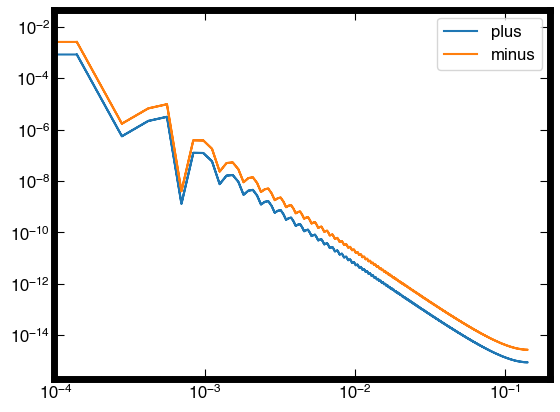

In [14]:
### MEAN VALUES
u03 = np.nanmean(parker.vr[use3])
vA03 = np.nanmean(parker.vA[use3])
ang3 = np.nanmean(parker.angle_vb[use3])*u.deg
print('Mean solar wind and Alfven speed and angle:', u03, vA03, (ang3))

### CALCULATE WAVE NUMBER 
freq = psd_Zp3.freq # np.linspace(1e-4, 1e-2, num=len(psd_Zp.power))
kp3 = (2 * np.pi * freq)/(np.abs(u03 * np.cos(ang3) - vA03))
km3 = (2 * np.pi * freq)/(np.abs(u03 * np.cos(ang3) + vA03))

### CALCULATE POWER SPECTRA OF K+ AND K-

### CREATE DATAFRAME
data = {'freq': freq, 'kp': kp3, 'km': km3}
dfk3 = pd.DataFrame(data=data)

### PSD
psd_kp = windowed_psd(list(dfk3.kp))
psd_km = windowed_psd(list(dfk3.km))

### PLOT
plt.plot(psd_kp.freq, psd_kp.power, label='plus')
plt.plot(psd_km.freq, psd_km.power, label='minus')
plt.xscale('log')
plt.yscale('log')
len(psd_kp.power)
plt.legend()



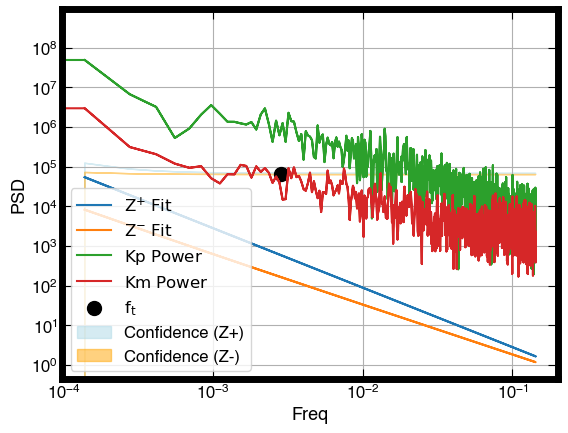

+-----------+-------------------+
| Parameter |   Fitted Value    |
+-----------+-------------------+
|  Cp_fit1  |    8.8464e-02     |
| Cinf_fit  |    1.1635e-19     |
|  Cm_fit2  |    7.5500e-03     |
|  kt_fit   |    3.0000e-05     |
|    ft     |    2.8232e-03     |
|  error_p  | 67664.07818010931 |
|  error m  | 63029.8599601927  |
+-----------+-------------------+


In [18]:
# Initial guesses for the parameters
initial_Cp_guess = 5e-3
initial_shared_Cinf_guess = 2.4e-7
initial_Cm_guess = 1e-4
initial_kt_guess = 1e-4


# Set bounds for the parameters
parameter_bounds1 = ([0, 0], [1e-1, 1e-1])  
parameter_bounds2 = ([0, 0, 3e-5], [1e-1, 1e-1, 1e-1])  

# For equation1, use initial_shared_Cinf_guess for Cinf and set bounds
use = np.logical_and(psd_Zp3.freq>2e-3, psd_Zp3.freq<2e-2)
paramsp, covariance1 = curve_fit(fit_function_p, dfk3.kp[use], psd_Zp3.power[use], p0=[initial_Cp_guess, initial_shared_Cinf_guess], bounds=parameter_bounds1)

# For equation2, use initial_shared_Cinf_guess for Cinf and set bounds
paramsm, covariance2 = curve_fit(fit_function_m, dfk3.km[use], psd_Zm3.power[use], p0=[initial_Cm_guess, initial_shared_Cinf_guess, initial_kt_guess], bounds=parameter_bounds2)

# Extract the optimized parameters
Cp_fit3, shared_Cinf_fit3 = paramsp
Cm_fit3, shared_Cinf_fit3, kt_fit3 = paramsm

# Calculate ft
ft3 = (kt_fit3 / (2*np.pi)) * (np.abs(u03 * np.cos(np.nanmean(ang3)) + np.nanmean(vA03)))


### ----- PLOT RESULTS ----- ####
x_values = psd_Zp.freq  # Adjust the range as needed
y1 = fit_function_p(freq, Cp_fit3, shared_Cinf_fit3)
y2 = fit_function_m(freq, Cm_fit3, shared_Cinf_fit3, kt_fit3)

plt.figure()
plt.plot(x_values, y1, label=r'$\rm Z^{+} \; Fit$')
plt.plot(x_values, y2, label=r'$\rm Z^{-} \; Fit$')
plt.plot(x_values, psd_Zp3.power, label=r'$\rm Kp \; Power$')
plt.plot(x_values, psd_Zm3.power, label=r'$\rm Km \; Power$')
plt.scatter(ft3, fit_function_m(kt_fit3, Cm_fit3, shared_Cinf_fit3, kt_fit3), label=r'$\rm f_t$', s=100, c='k')

### ERROR in P
errorp = var_p(dfk3.kp, covariance1)

### ERROR IN M
errorm = var_m(dfk3.km, covariance2, kt_fit3)

### PLOT ERROR
plt.fill_between(x_values, y1 - np.nanmean(errorp), y1 + np.nanmean(errorp), color='lightblue', alpha=0.5, label='Confidence (Z+)', zorder=-1)
plt.fill_between(x_values, y2 - np.nanmean(errorm), y2 + np.nanmean(errorm), color='orange', alpha=0.5, label='Confidence (Z-)', zorder=-1)


plt.xlabel("Freq")
plt.ylabel("PSD")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

# Print the results as a table in scientific notation
results_table = tabulate([
    ["Cp_fit1", f"{Cp_fit3:.4e}"],
    ["Cinf_fit", f"{shared_Cinf_fit3:.4e}"],
    ["Cm_fit2", f"{Cm_fit3:.4e}"],
    ["kt_fit", f"{kt_fit3:.4e}"],
    ["ft", f"{ft3:.4e}"],
    ['error_p', np.nanmean(errorp)],
    ['error m', np.nanmean(errorm)]
], headers=["Parameter", "Fitted Value"], tablefmt="pretty")
print(results_table)

Power Law Exponent: -1.01
Power Law Exponent: -1.37
Power Law Exponent: -1.30


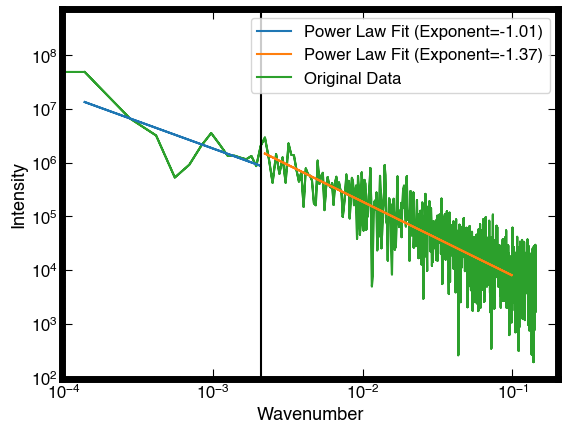

In [19]:
# Example data (replace with your own)
psdd = psd_Zp3
intensity = psdd.power
FT3 = 2.1e-3
use = np.logical_and(psdd.freq>1e-4, psdd.freq<FT3)
exponent, intercept = fit_slope(psdd.freq[use],  psdd.power[use])
plt.plot(psdd.freq[use], np.exp(intercept) * psdd.freq[use]**exponent, label=f'Power Law Fit (Exponent={exponent:.2f})')

use = np.logical_and(psdd.freq>FT3, psdd.freq<1e-1)
exponent, intercept = fit_slope(psdd.freq[use],  psdd.power[use])
plt.plot(psdd.freq[use], np.exp(intercept) * psdd.freq[use]**exponent, label=f'Power Law Fit (Exponent={exponent:.2f})')

use = np.logical_and(psdd.freq>1e-4, psdd.freq<1e-1)
exponent, intercept = fit_slope(psdd.freq[use],  psdd.power[use])
# plt.plot(psdd.freq[use], np.exp(intercept) * psdd.freq[use]**exponent, label=f'Power Law Fit (Exponent={exponent:.2f})')

# Plot original data and fitted power law
plt.axvline(FT3, c='k')

plt.plot(psdd.freq, intensity, label='Original Data', zorder=-1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavenumber')
plt.ylabel('Intensity')
plt.legend()
plt.show()


In [20]:
psdd = psd_Zp3
FT3 = 2.2e-3
u3h = np.logical_and(psdd.freq>1e-4, psdd.freq<FT3)
e3h, i3h = fit_slope(psdd.freq[u3h],  psdd.power[u3h])
u3l = np.logical_and(psdd.freq>FT3, psdd.freq<1e-1)
e3l, i3l = fit_slope(psdd.freq[u3l],  psdd.power[u3l])
psdd = psd_Zm3
u3m = np.logical_and(psdd.freq>1e-3, psdd.freq<2e-2)
e3m, i3m = fit_slope(psdd.freq[u3m],  psdd.power[u3m])
u3hm = np.logical_and(psdd.freq>8e-4, psdd.freq<FT3)
e3hm, i3hm = fit_slope(psdd.freq[u3hm],  psdd.power[u3hm])

u3lm = np.logical_and(psdd.freq>8e-3, psdd.freq<5e-2)
e3lm, i3lm = fit_slope(psdd.freq[u3lm],  psdd.power[u3lm])

Power Law Exponent: -1.01
Power Law Exponent: -1.37
Power Law Exponent: -0.90
Power Law Exponent: 0.30
Power Law Exponent: -1.00


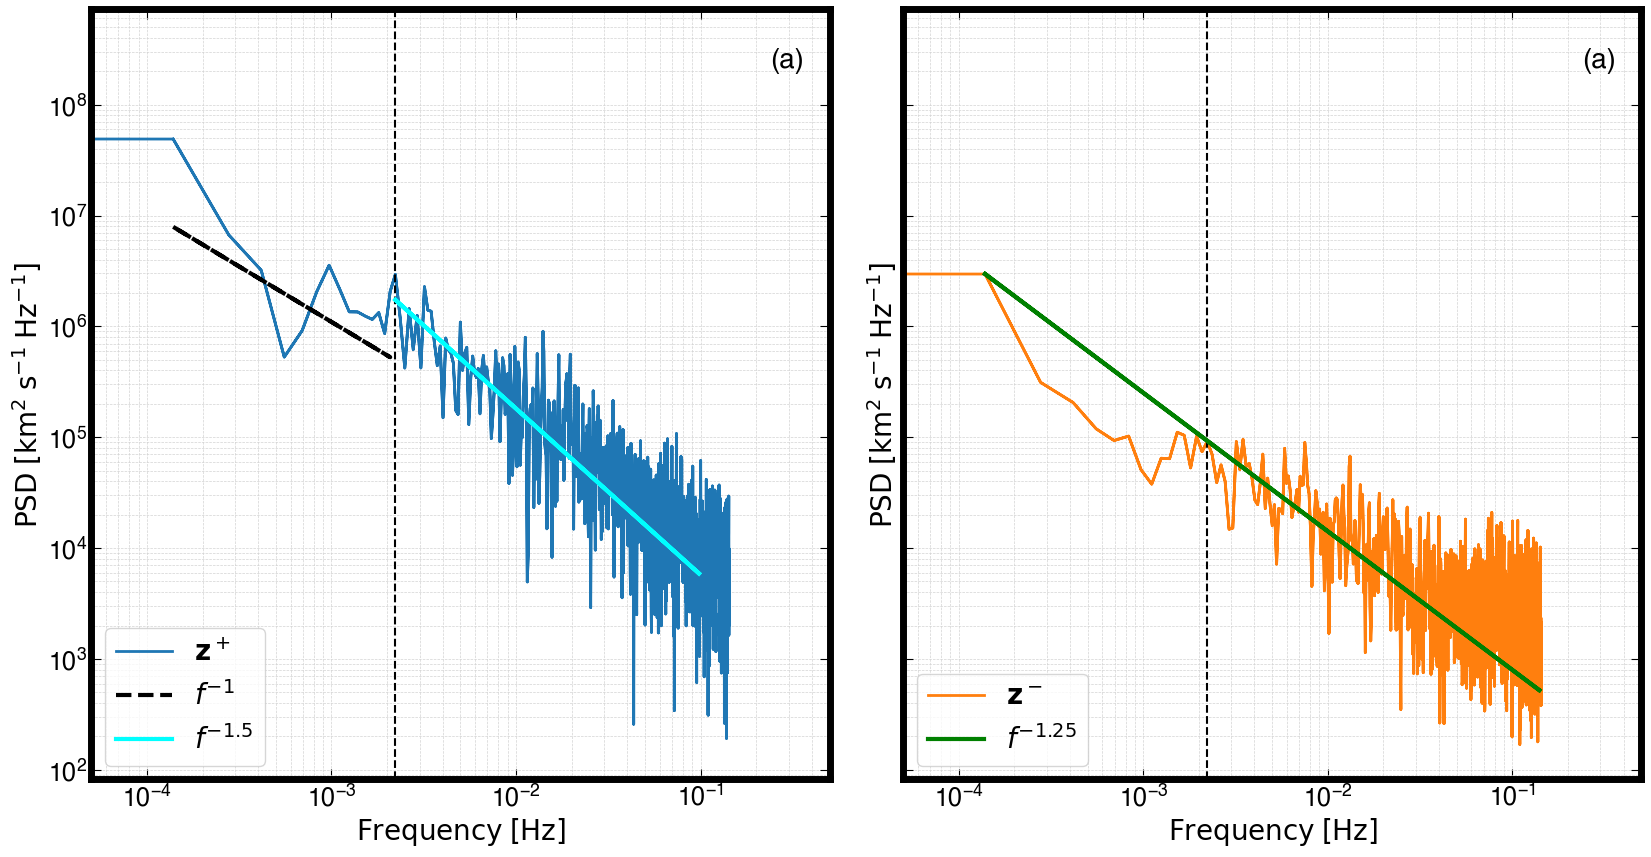

In [21]:
# Plot the PSD

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[20, 10], sharex='all', sharey='all', gridspec_kw={'hspace': 0.05, 'wspace':0.1})
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']
lw=2
##### -------- ELASSER SPECTRA #####
ax = ax1
for i, psd_spec in enumerate([psd_Zp3]):
    ax.plot(psd_spec.freq, psd_spec.power, c=colors[i], label=labels[i], linewidth=lw)
    
ax.plot(psd_Zp3.freq[u3h], np.exp(7)*(psd_Zp3.freq[u3h]**-1), c='k', linestyle='dashed', label=f'$f^{{{-1}}}$', zorder=10, lw=3)
ax.plot(psd_Zp3.freq[u3l], np.exp(5.2)*(psd_Zp3.freq[u3l]**-1.5), c='cyan', label=f'$f^{{{-1.5}}}$', zorder=10, lw=3)

# ax.plot(psd_Zp3.freq[u3h], np.exp(i3h)*(psd_Zp3.freq[u3h]**e3h), c='k', linestyle='dashed', label=f'$f^{{{e3h:.2f}}}$', zorder=10, lw=3)
# ax.plot(psd_Zp3.freq[u3l], np.exp(i3l)*(psd_Zp3.freq[u3l]**e3l), c='chocolate', label=f'$f^{{{e3l:.2f}}}$', zorder=10, lw=3)

ax.axvline(FT3, c='k', linestyle='dashed')


### LEGEND
ax.legend(loc='lower left', fontsize=20)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set(xlim=(5e-5, 5e-1))
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

##### -------- ELASSER SPECTRA #####
ax = ax2
for i, psd_spec in enumerate([psd_Zm3]): # , 
    ax.plot(psd_spec.freq, psd_spec.power, c=colors[i+1], label=labels[i+1], linewidth=lw)
    
# ax.plot(psd_Zm3.freq, np.exp(i3lm)*(psd_Zm3.freq**e3lm), c='slateblue', label=f'$f^{{{e3lm:.2f}}}$', zorder=10, lw=3)
ax.plot(psd_Zm3.freq, np.exp(3.8)*(psd_Zm3.freq**-1.25), c='green', label=f'$f^{{{-1.25}}}$', zorder=10, lw=3)

ax.axvline(FT3, c='k', linestyle='dashed')


### LEGEND
ax.legend(loc='lower left', fontsize=20)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set(xlim=(5e-5, 5e-1))
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

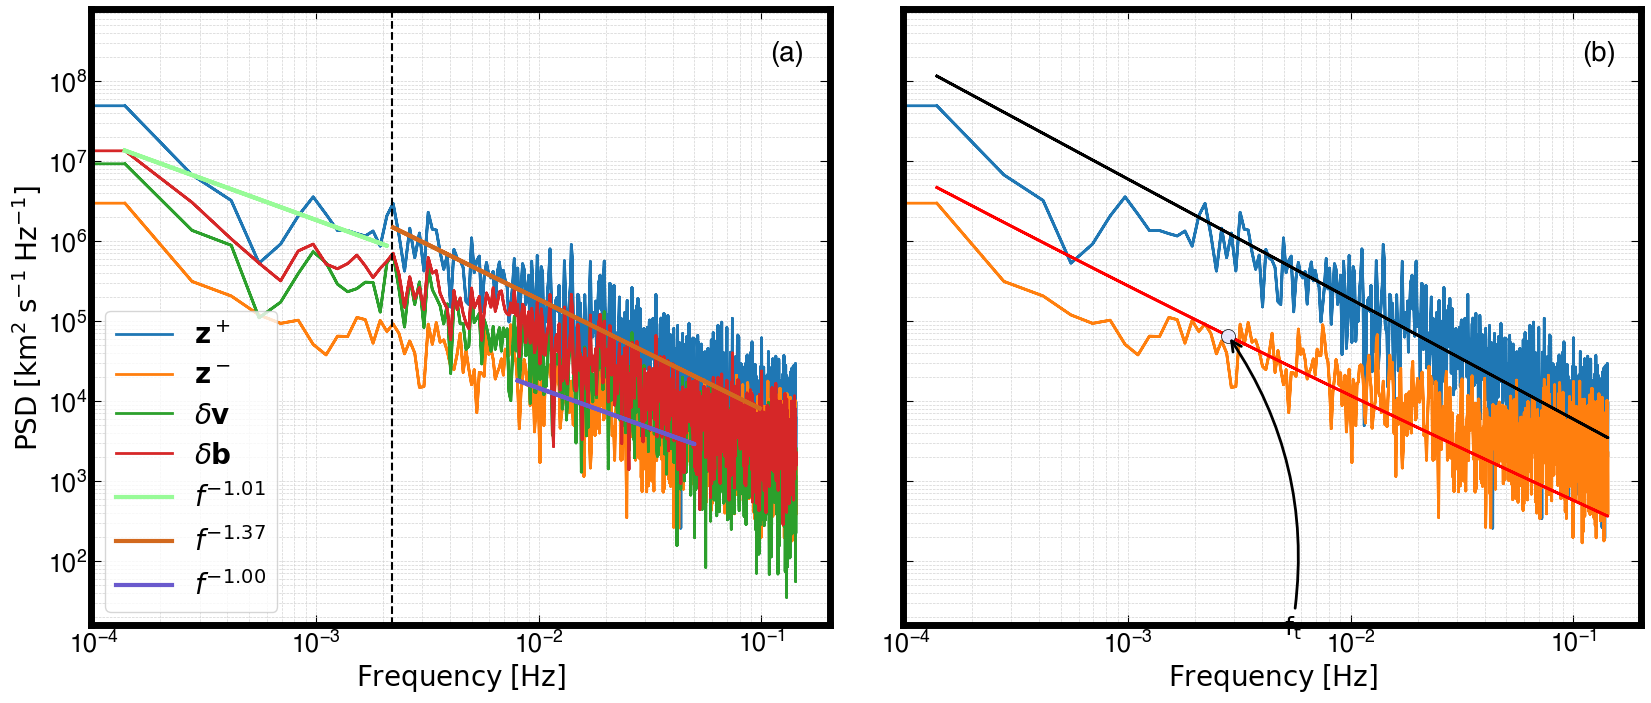

In [22]:
# Plot the PSD

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[20, 8], sharex='all', sharey='all', gridspec_kw={'hspace': 0.05, 'wspace':0.1})
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']
lw=2
##### -------- ELASSER SPECTRA #####
ax = ax1
for i, psd_spec in enumerate([psd_Zp3, psd_Zm3, psd_dv3, psd_db3]):
    ax.plot(psd_spec.freq, psd_spec.power, c=colors[i], label=labels[i], linewidth=lw)
ax.plot(psd_Zp2.freq[u3h], np.exp(i3h)*(psd_Zp2.freq[u3h]**e3h), c='palegreen', label=f'$f^{{{e3h:.2f}}}$', zorder=10, lw=3)
ax.plot(psd_Zp2.freq[u3l], np.exp(i3l)*(psd_Zp2.freq[u3l]**e3l), c='chocolate', label=f'$f^{{{e3l:.2f}}}$', zorder=10, lw=3)
ax.plot(psd_Zm2.freq[u3lm], np.exp(i3lm)*(psd_Zm2.freq[u3lm]**e3lm), c='slateblue', label=f'$f^{{{e3lm:.2f}}}$', zorder=10, lw=3)
ax.axvline(FT3, c='k', linestyle='dashed')

### LEGEND
ax.legend(loc='lower left', fontsize=20)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

##### -------- PANEL TWO: SPECTRAL FITS #####
freq = psd_Zp.freq
ax = ax2
for i, psd_spec in enumerate([psd_Zp3, psd_Zm3]):
    ax.plot(psd_spec.freq, psd_spec.power, c=colors[i], label=labels[i], linewidth=lw)

### PLOT FITS
# freq = np.linspace(6e-4, 2e-2, num=len(kp3))
kp = (2 * np.pi * freq)/(np.abs(u03 * np.cos(ang3) - vA03))
km = (2 * np.pi * freq)/(np.abs(u03 * np.cos(ang3) + vA03))
y1 = fit_function_p(kp3, Cp_fit3, shared_Cinf_fit3) 
y2 = fit_function_m(km3, Cm_fit3, shared_Cinf_fit3, kt_fit3)

ax.plot(freq, y1, c='k', lw=lw, zorder=2) # label=r'$\rm Z^{+} \; Fit$', 
ax.plot(freq, y2, c='red', lw=lw, zorder=2) #label=r'$\rm Z^{-} \; Fit$', 
ax.scatter(ft3, fit_function_m(kt_fit3, Cm_fit3, shared_Cinf_fit3, kt_fit3), s=100, c='lavender', edgecolor='k', lw=0.5, zorder=3)

### PLOT ERROR
### ERROR in P
errorp = var_p(kp, covariance1)
errorm = var_m(km, covariance2, kt_fit3)
# ax.fill_between(freq, y1 - errorp, y1 + errorp, color='lightblue', alpha=0.5, zorder=1)
# ax.fill_between(freq, y2 - errorm, y2 + errorm, color='lightgreen', alpha=0.5, zorder=1)

### ANNOTATE Ft
ax.annotate(r'$\rm f_t$', xy=(ft3, fit_function_m(kt_fit3, Cm_fit3, shared_Cinf_fit3, kt_fit3)-15), xytext=(5e-3, 12),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=2),fontsize=18)

### LEGEND
# ax.legend(loc='lower left', fontsize=20)

### LABELS
ax.text(0.92, 0.95, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 

### SCALES
ax2.set_xscale('log')  
ax2.set_yscale('log')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')



## PERIOD ONE

Mean solar wind and Alfven speed and angle: 119.4225366224919 387.13325377965737 8820.618987165626 deg


<Figure size 640x480 with 0 Axes>

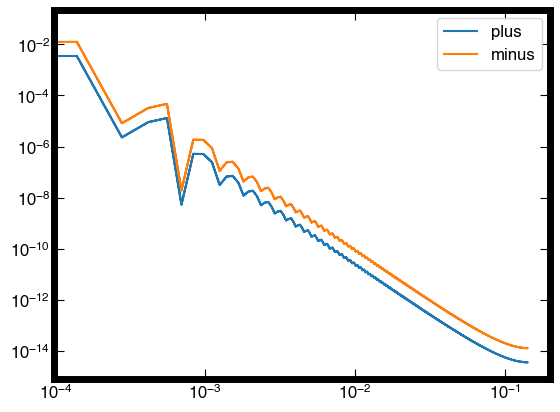

In [23]:
### MEAN VALUES
u0 = np.nanmean(parker.vr[use1])
vA0 = np.nanmean(parker.vA[use1])
ang = np.nanmean(parker.angle_vb[use1])*u.rad
print('Mean solar wind and Alfven speed and angle:', u0, vA0, (ang).to(u.deg))

### CALCULATE WAVE NUMBER 
freq = psd_Zp.freq # np.linspace(1e-4, 1e-2, num=len(psd_Zp.power))
kp = (2 * np.pi * freq)/(np.abs(u0 * np.cos(ang) - vA0))
km = (2 * np.pi * freq)/(np.abs(u0 * np.cos(ang) + vA0))

### CALCULATE POWER SPECTRA OF K+ AND K-

### CREATE DATAFRAME
data = {'freq': freq, 'kp': kp, 'km': km}
dfk = pd.DataFrame(data=data)

### PSD
psd_kp = windowed_psd(list(dfk.kp))
psd_km = windowed_psd(list(dfk.km))

### PLOT
plt.plot(psd_kp.freq, psd_kp.power, label='plus')
plt.plot(psd_km.freq, psd_km.power, label='minus')
plt.xscale('log')
plt.yscale('log')
len(psd_kp.power)
plt.legend()



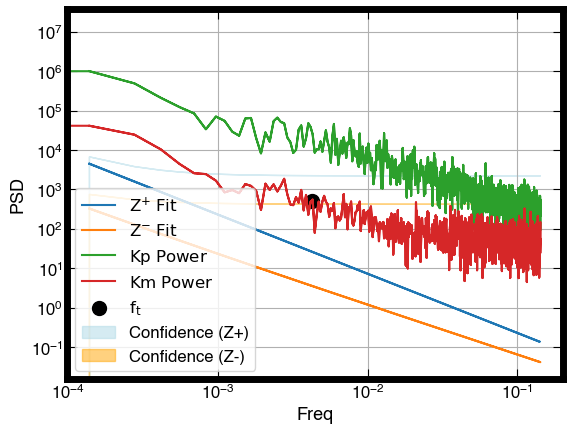

+-----------+--------------------+
| Parameter |    Fitted Value    |
+-----------+--------------------+
|  Cp_fit1  |     7.3319e-03     |
| Cinf_fit  |     6.2697e-15     |
|  Cm_fit2  |     3.6314e-04     |
|  kt_fit   |     1.0000e-04     |
|    ft     |     4.2609e-03     |
|  error_p  | 2214.7613615626547 |
|  error m  | 421.2079752754685  |
+-----------+--------------------+


In [24]:
# Initial guesses for the parameters
initial_Cp_guess = 5e-3
initial_shared_Cinf_guess = 2.4e-7
initial_Cm_guess = 1e-4
initial_kt_guess = 1e-4


# Set bounds for the parameters
parameter_bounds1 = ([0, 0], [1e-1, 1e-1])  
parameter_bounds2 = ([0, 0, 1e-4], [1e-1, 1e-1, 1e-1])  

# For equation1, use initial_shared_Cinf_guess for Cinf and set bounds
use = np.logical_and(psd_Zp.freq>2e-3, psd_Zp.freq<2e-2)
paramsp, covariance1 = curve_fit(fit_function_p, dfk.kp[use], psd_Zp.power[use], p0=[initial_Cp_guess, initial_shared_Cinf_guess], bounds=parameter_bounds1)

# For equation2, use initial_shared_Cinf_guess for Cinf and set bounds
paramsm, covariance2 = curve_fit(fit_function_m, dfk.km[use], psd_Zm.power[use], p0=[initial_Cm_guess, initial_shared_Cinf_guess, initial_kt_guess], bounds=parameter_bounds2)

# Extract the optimized parameters
Cp_fit1, shared_Cinf_fit1= paramsp
Cm_fit1, shared_Cinf_fit1, kt_fit1 = paramsm

# Calculate ft
ft1 = (kt_fit1 / (2*np.pi)) * (np.abs(u0 * np.cos(np.nanmean(ang)) + np.nanmean(vA0)))


### ----- PLOT RESULTS ----- ####
x_values = psd_Zp.freq  # Adjust the range as needed
y1 = fit_function_p(freq, Cp_fit1, shared_Cinf_fit1)
y2 = fit_function_m(freq, Cm_fit1, shared_Cinf_fit1, kt_fit1)

plt.figure()
plt.plot(x_values, y1, label=r'$\rm Z^{+} \; Fit$')
plt.plot(x_values, y2, label=r'$\rm Z^{-} \; Fit$')
plt.plot(x_values, psd_Zp.power, label=r'$\rm Kp \; Power$')
plt.plot(x_values, psd_Zm.power, label=r'$\rm Km \; Power$')
plt.scatter(ft1, fit_function_m(kt_fit1, Cm_fit1, shared_Cinf_fit1, kt_fit1), label=r'$\rm f_t$', s=100, c='k')

### ERROR in P
errorp = var_p(dfk.kp, covariance1)

### ERROR IN M
errorm = var_m(dfk.km, covariance2, kt_fit1)

### PLOT ERROR
plt.fill_between(x_values, y1 - np.nanmean(errorp), y1 + np.nanmean(errorp), color='lightblue', alpha=0.5, label='Confidence (Z+)', zorder=-1)
plt.fill_between(x_values, y2 - np.nanmean(errorm), y2 + np.nanmean(errorm), color='orange', alpha=0.5, label='Confidence (Z-)', zorder=-1)


plt.xlabel("Freq")
plt.ylabel("PSD")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

# Print the results as a table in scientific notation
results_table = tabulate([
    ["Cp_fit1", f"{Cp_fit1:.4e}"],
    ["Cinf_fit", f"{shared_Cinf_fit1:.4e}"],
    ["Cm_fit2", f"{Cm_fit1:.4e}"],
    ["kt_fit", f"{kt_fit1:.4e}"],
    ["ft", f"{ft1:.4e}"],
    ['error_p', np.nanmean(errorp)],
    ['error m', np.nanmean(errorm)]
], headers=["Parameter", "Fitted Value"], tablefmt="pretty")
print(results_table)

### Fit Slope

Power Law Exponent: -1.02
Power Law Exponent: -1.37
Power Law Exponent: -0.98


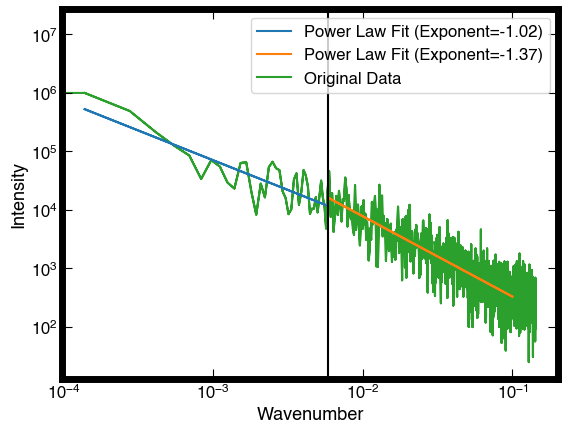

In [25]:
# Example data (replace with your own)
psdd = psd_Zp
intensity = psdd.power
FT = 5.9e-3
use = np.logical_and(psdd.freq>1e-4, psdd.freq<FT)
exponent, intercept = fit_slope(psdd.freq[use],  psdd.power[use])
plt.plot(psdd.freq[use], np.exp(intercept) * psdd.freq[use]**exponent, label=f'Power Law Fit (Exponent={exponent:.2f})')

use = np.logical_and(psdd.freq>FT, psdd.freq<1e-1)
exponent, intercept = fit_slope(psdd.freq[use],  psdd.power[use])
plt.plot(psdd.freq[use], np.exp(intercept) * psdd.freq[use]**exponent, label=f'Power Law Fit (Exponent={exponent:.2f})')

use = np.logical_and(psdd.freq>1e-4, psdd.freq<1e-2)
exponent, intercept = fit_slope(psdd.freq[use],  psdd.power[use])
# plt.plot(psdd.freq[use], np.exp(intercept) * psdd.freq[use]**exponent, label=f'Power Law Fit (Exponent={exponent:.2f})')

# Plot original data and fitted power law
plt.axvline(FT, c='k')
plt.plot(psdd.freq, intensity, label='Original Data', zorder=-1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavenumber')
plt.ylabel('Intensity')
plt.legend()
plt.show()



Power Law Exponent: -1.23
Power Law Exponent: -1.31
Power Law Exponent: -1.18


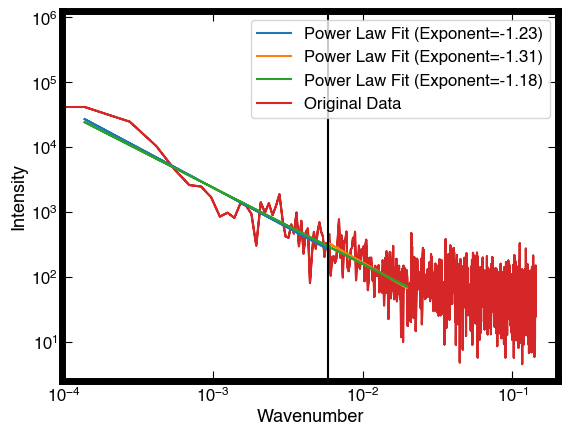

In [26]:
# Example data (replace with your own)
wavenumber = dfk.km
psdd = psd_Zm
intensity = psdd.power
use = np.logical_and(psdd.freq>1e-4, psdd.freq<FT)
exponent, intercept = fit_slope(psdd.freq[use],  psdd.power[use])
plt.plot(psdd.freq[use], np.exp(intercept) * psdd.freq[use]**exponent, label=f'Power Law Fit (Exponent={exponent:.2f})')

use = np.logical_and(psdd.freq>FT, psdd.freq<2e-2)
exponent, intercept = fit_slope(psdd.freq[use],  psdd.power[use])
plt.plot(psdd.freq[use], np.exp(intercept) * psdd.freq[use]**exponent, label=f'Power Law Fit (Exponent={exponent:.2f})')

use = np.logical_and(psdd.freq>1e-4, psdd.freq<2e-2)
exponent, intercept = fit_slope(psdd.freq[use],  psdd.power[use])
plt.plot(psdd.freq[use], np.exp(intercept) * psdd.freq[use]**exponent, label=f'Power Law Fit (Exponent={exponent:.2f})')

# Plot original data and fitted power law
plt.axvline(FT, c='k')
plt.plot(psdd.freq, intensity, label='Original Data', zorder=-1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavenumber')
plt.ylabel('Intensity')
plt.legend()
plt.show()



In [27]:
FT1 = 5.9e-3
psdd = psd_Zp
u1h = np.logical_and(psdd.freq>1e-4, psdd.freq<FT1)
e1h, i1h = fit_slope(psdd.freq[u1h],  psdd.power[u1h])
u1l = np.logical_and(psdd.freq>FT1, psdd.freq<1e-1)
e1l, i1l = fit_slope(psdd.freq[u1l],  psdd.power[u1l])
psdd = psd_Zm
u1m = np.logical_and(psdd.freq>1e-3, psdd.freq<2e-2)
e1lm, i1lm = fit_slope(psdd.freq[u1m],  psdd.power[u1m])

plot_elsasser(psd_Zp, psd_Zm, 4, 2.2, -0.7, u1h, u1l, FT)

Power Law Exponent: -1.02
Power Law Exponent: -1.37
Power Law Exponent: -1.11


NameError: name 'plot_elsasser' is not defined

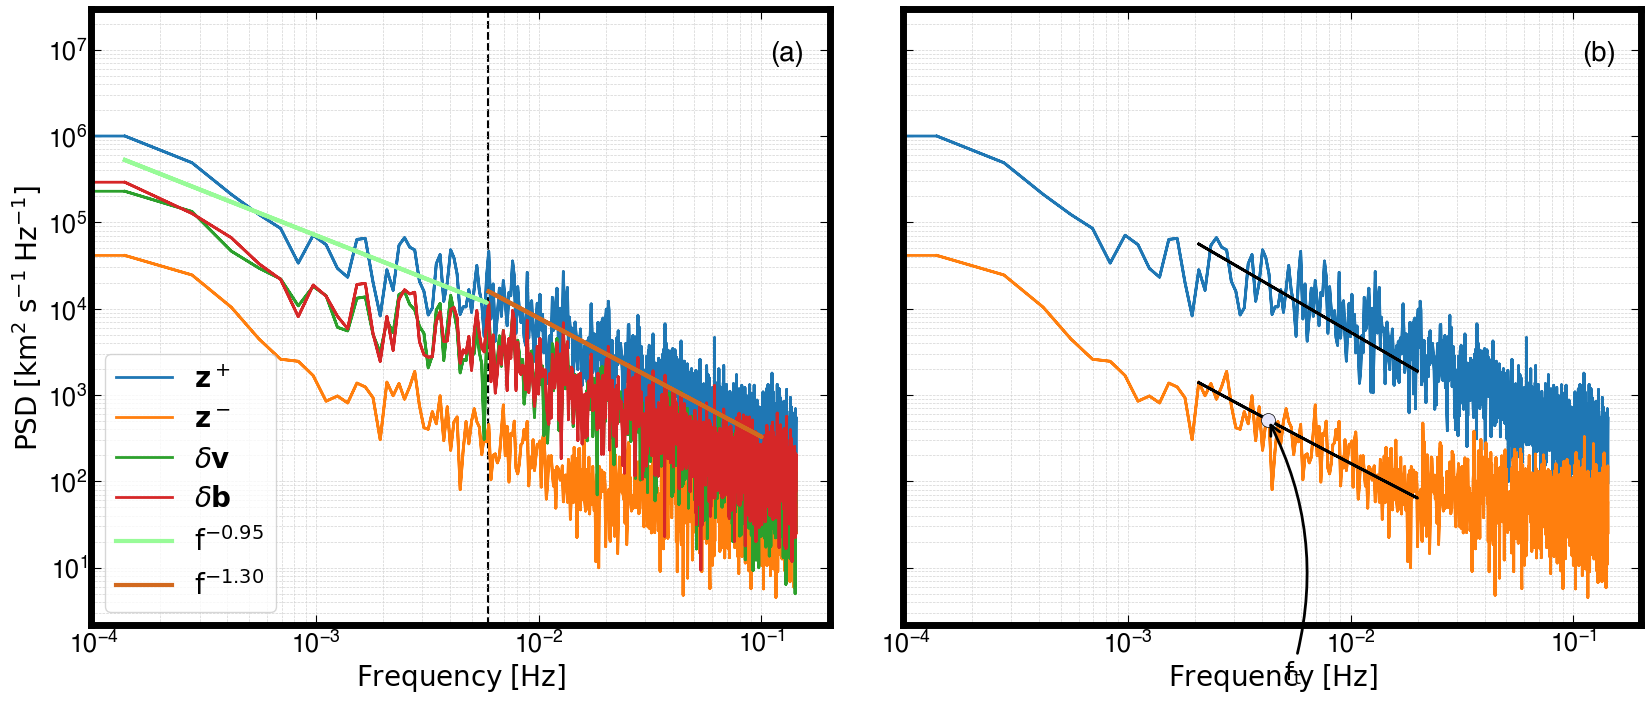

In [28]:
# Plot the PSD
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[20, 8], sharex='all', sharey='all', gridspec_kw={'hspace': 0.05, 'wspace':0.1})
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']
lw=2

##### -------- ELASSER SPECTRA #####
ax = ax1
for i, psd_spec in enumerate([psd_Zp, psd_Zm, psd_dv, psd_db]):
    ax.plot(psd_spec.freq, psd_spec.power, c=colors[i], label=labels[i], linewidth=lw)
ax.plot(psd_Zp.freq[u1h], np.exp(i1h)*(psd_Zp.freq[u1h]**e1h), c='palegreen', label=r'$\rm f^{-0.95}$', zorder=10, lw=3)
ax.plot(psd_Zp.freq[u1l], np.exp(i1l)*(psd_Zp.freq[u1l]**e1l), c='chocolate', label=r'$\rm f^{-1.30}$', zorder=10, lw=3)
# ax.plot(psd_Zm.freq[u1lm], np.exp(i1lm)*(psd_Zm.freq[u1lm]**e1lm), c='peru', label=r'$\rm f^{-0.75}$', zorder=10, lw=3)

ax.axvline(FT1, c='k', linestyle='dashed', zorder=-10)
### LEGEND
ax.legend(loc='lower left', fontsize=20)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

##### -------- PANEL TWO: SPECTRAL FITS #####
ax = ax2
for i, psd_spec in enumerate([psd_Zp, psd_Zm]):
    ax.plot(psd_spec.freq, psd_spec.power, c=colors[i], label=labels[i], linewidth=lw)

### PLOT FITS
use = np.logical_and(psd_Zp.freq>2e-3, psd_Zp.freq<2e-2)
freq = psd_Zp.freq[use]
kp = (2 * np.pi * freq)/(np.abs(u0 * np.cos(ang) - vA0))
km = (2 * np.pi * freq)/(np.abs(u0 * np.cos(ang) + vA0))
ap = (2 * np.pi)/(np.abs(u0 * np.cos(ang) - vA0))
am = (2 * np.pi)/(np.abs(u0 * np.cos(ang) + vA0))

y1 = fit_function_p(kp, Cp_fit1, shared_Cinf_fit1)
y2 = fit_function_m(km, Cm_fit1, shared_Cinf_fit1, kt_fit1) 

### MOVE TO FREQUENCY DOMAIN
ax.plot(freq, y1, c='k', lw=lw, zorder=2) 
ax.plot(freq, y2, c='k', lw=lw, zorder=2) 
# ax.plot(freq, 5e-3*(freq**(-3/2)), c='red', linestyle='dashed', lw=lw, zorder=2) 
ax.scatter(ft1, fit_function_m(kt_fit1, Cm_fit1, shared_Cinf_fit1, kt_fit1), s=100, c='lavender', edgecolor='k', lw=0.5, zorder=3)

### ANNOTATE Ft
ax.annotate(r'$\rm f_t$', xy=(ft1, fit_function_m(kt_fit1, Cm_fit1, shared_Cinf_fit1, kt_fit1)-0.5), xytext=(5e-3, .5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=2),fontsize=18, zorder=10)

### LABELS
ax.text(0.92, 0.95, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 

### SCALES
ax2.set_xscale('log')  
ax2.set_yscale('log')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')



## PERIOD TWO

Mean solar wind and Alfven speed and angle: 164.61740269018205 1171.356443060041 156.68851321781537 rad


<Figure size 640x480 with 0 Axes>

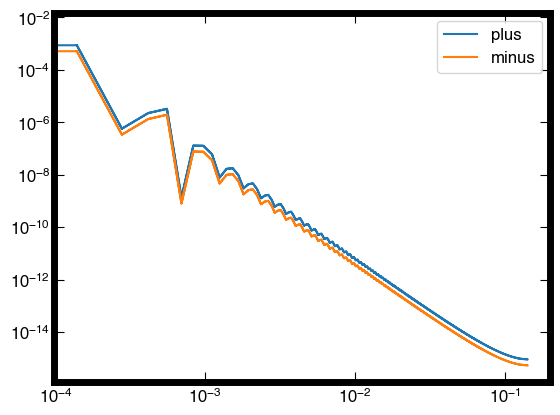

In [29]:
### MEAN VALUES
u02 = np.nanmean(parker.vr[use2])
vA02 = np.nanmean(parker.vA[use2])
ang2 = np.nanmean(parker.angle_vb[use2])*u.rad
print('Mean solar wind and Alfven speed and angle:', u02, vA02, ang2)

### CALCULATE WAVE NUMBER 
freq = psd_Zp2.freq
kp = (2 * np.pi * freq)/(np.abs(u02 * np.cos(ang2) - vA02))
km = (2 * np.pi * freq)/(np.abs(u02 * np.cos(ang2) + vA02))

### CALCULATE POWER SPECTRA OF K+ AND K-

### CREATE DATAFRAME
data = {'freq': freq, 'kp': kp, 'km': km}
dfk2 = pd.DataFrame(data=data)

### K plus
psd_kp2 = windowed_psd(list(dfk2.kp))
psd_km2 = windowed_psd(list(dfk2.km))

### Z minus
plt.plot(psd_kp2.freq, psd_kp2.power, label='plus')
plt.plot(psd_kp2.freq, psd_km2.power, label='minus')
plt.xscale('log')
plt.yscale('log')
len(psd_kp2.power)
plt.legend()




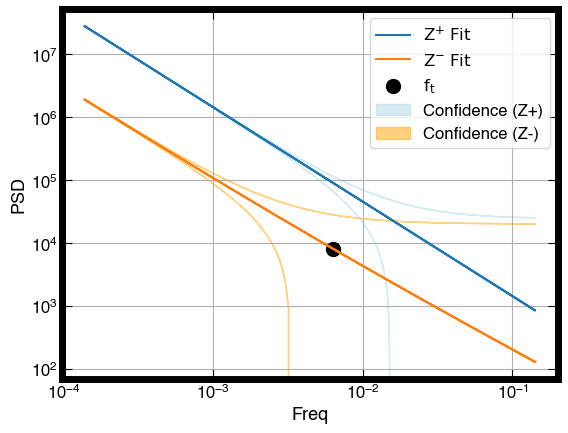

+-----------+--------------------+
| Parameter |    Fitted Value    |
+-----------+--------------------+
|  Cp_fit2  |     2.1966e-02     |
| Cinf_fit  |     1.7720e-14     |
|  Cm_fit2  |     9.4376e-04     |
|  kt_fit   |     3.0000e-05     |
|    ft     |     6.3194e-03     |
|  error_p  |  24264.2010169356  |
|  error m  | 20007.138590936625 |
+-----------+--------------------+


In [30]:
# Initial guesses for the parameters
initial_Cp_guess = 5e-3
initial_shared_Cinf_guess = 2.4e-7
initial_Cm_guess = 1e-4
initial_kt_guess = 1e-4

# Set bounds for the parameters
parameter_bounds1 = ([0, 0], [1e-1, 1e-1])  
parameter_bounds2 = ([0, 0, 3e-5], [1e-1, 1e-1, 1e-1])  

# For equation1, use initial_shared_Cinf_guess for Cinf and set bounds
use = np.logical_and(psd_Zp.freq>2e-3, psd_Zp.freq<2e-2)
paramsp, covariance1 = curve_fit(fit_function_p, dfk2.kp[use], psd_Zp2.power[use], p0=[initial_Cp_guess, initial_shared_Cinf_guess], bounds=parameter_bounds1, method='trf')

# For equation2, use initial_shared_Cinf_guess for Cinf and set bounds
paramsm, covariance2 = curve_fit(fit_function_m, dfk2.km[use], psd_Zm2.power[use], p0=[initial_Cm_guess, initial_shared_Cinf_guess, initial_kt_guess], bounds=parameter_bounds2, method='trf')

# Extract the optimized parameters
Cp_fit2, shared_Cinf_fit2 = paramsp
Cm_fit2, shared_Cinf_fit2, kt_fit2 = paramsm

# Calculate ft
ft2 = (kt_fit2 / (2*np.pi)) * (np.abs(u02 * np.cos(np.nanmean(ang2)) + np.nanmean(vA02)))


### ----- PLOT RESULTS ----- ####
x_values = freq  # Adjust the range as needed
y1 = fit_function_p(dfk2.kp, Cp_fit2, shared_Cinf_fit2)
y2 = fit_function_m(dfk2.km, Cm_fit2, shared_Cinf_fit2, kt_fit2)

plt.figure()
plt.plot(x_values, y1, label=r'$\rm Z^{+} \; Fit$')
plt.plot(x_values, y2, label=r'$\rm Z^{-} \; Fit$')
plt.scatter(ft2, fit_function_m(kt_fit2, Cm_fit2, shared_Cinf_fit2, kt_fit2), label=r'$\rm f_t$', s=100, c='k')

### ERROR in P
errorp = var_p(dfk2.kp, covariance1)

### ERROR IN M
errorm = var_m(dfk2.km, covariance2, kt_fit2)

### PLOT ERROR
plt.fill_between(x_values, y1 - np.nanmean(errorp), y1 + np.nanmean(errorp), color='lightblue', alpha=0.5, label='Confidence (Z+)', zorder=-1)
plt.fill_between(x_values, y2 - np.nanmean(errorm), y2 + np.nanmean(errorm), color='orange', alpha=0.5, label='Confidence (Z-)', zorder=-1)

plt.xlabel("Freq")
plt.ylabel("PSD")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

# Print the results as a table in scientific notation
results_table = tabulate([
    ["Cp_fit2", f"{Cp_fit2:.4e}"],
    ["Cinf_fit", f"{shared_Cinf_fit2:.4e}"],
    ["Cm_fit2", f"{Cm_fit2:.4e}"],
    ["kt_fit", f"{kt_fit2:.4e}"],
    ["ft", f"{ft2:.4e}"],
    ['error_p', np.nanmean(errorp)],
    ['error m', np.nanmean(errorm)]
], headers=["Parameter", "Fitted Value"], tablefmt="pretty")
print(results_table)

Power Law Exponent: -1.37
Power Law Exponent: -1.23
Power Law Exponent: -1.18


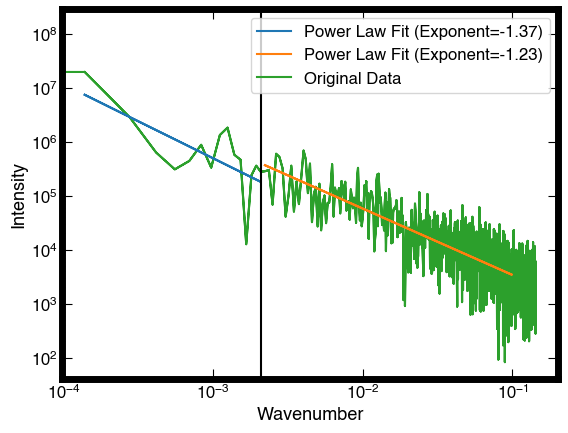

In [31]:
# Example data (replace with your own)
psdd = psd_Zp2
intensity = psdd.power
FT2 = 2.1e-3
use = np.logical_and(psdd.freq>1e-4, psdd.freq<FT2)
exponent, intercept = fit_slope(psdd.freq[use],  psdd.power[use])
plt.plot(psdd.freq[use], np.exp(intercept) * psdd.freq[use]**exponent, label=f'Power Law Fit (Exponent={exponent:.2f})')

use = np.logical_and(psdd.freq>FT2, psdd.freq<1e-1)
exponent, intercept = fit_slope(psdd.freq[use],  psdd.power[use])
plt.plot(psdd.freq[use], np.exp(intercept) * psdd.freq[use]**exponent, label=f'Power Law Fit (Exponent={exponent:.2f})')

use = np.logical_and(psdd.freq>1e-4, psdd.freq<1e-1)
exponent, intercept = fit_slope(psdd.freq[use],  psdd.power[use])
# plt.plot(psdd.freq[use], np.exp(intercept) * psdd.freq[use]**exponent, label=f'Power Law Fit (Exponent={exponent:.2f})')

# Plot original data and fitted power law
# plt.axvline(FT1, c='k')
plt.axvline(FT2, c='k')

plt.plot(psdd.freq, intensity, label='Original Data', zorder=-1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavenumber')
plt.ylabel('Intensity')
plt.legend()
plt.show()



In [32]:
psdd = psd_Zp2
FT2 = 4e-3
u2h = np.logical_and(psdd.freq>3e-4, psdd.freq<FT2)
e2h, i2h = fit_slope(psdd.freq[u2h],  psdd.power[u2h])
u2l = np.logical_and(psdd.freq>FT2, psdd.freq<1e0)
e2l, i2l = fit_slope(psdd.freq[u2l],  psdd.power[u2l])
psdd = psd_Zm2
u2lm = np.logical_and(psdd.freq>FT2, psdd.freq<4e-2)
e2lm, i2lm = fit_slope(psdd.freq[u2lm],  psdd.power[u2lm])

Power Law Exponent: -0.82
Power Law Exponent: -1.28
Power Law Exponent: -1.20


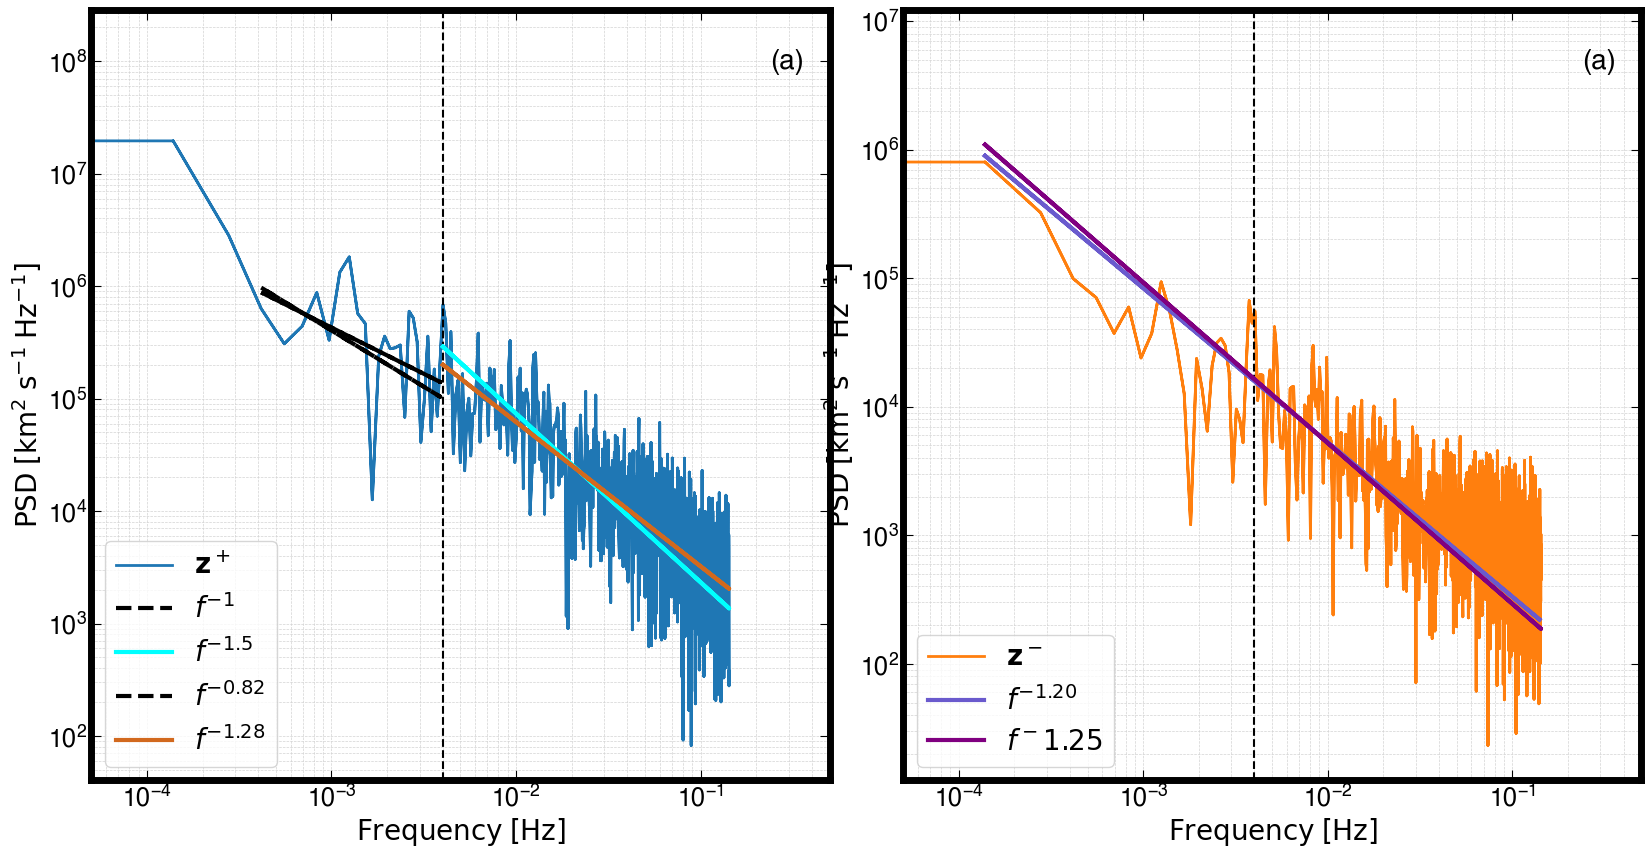

In [33]:
# Plot the PSD

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[20, 10], sharex='all',  gridspec_kw={'hspace': 0.05, 'wspace':0.1})
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']
lw=2
##### -------- ELASSER SPECTRA #####
ax = ax1
for i, psd_spec in enumerate([psd_Zp2]): # , psd_Zm2
    ax.plot(psd_spec.freq, psd_spec.power, c=colors[i], label=labels[i], linewidth=lw)
    
ax.plot(psd_Zp2.freq[u2h], np.exp(6)*(psd_Zp2.freq[u2h]**-1), c='k', linestyle='dashed', label=f'$f^{{{-1}}}$', zorder=10, lw=3)
ax.plot(psd_Zp2.freq[u2l], np.exp(4.3)*(psd_Zp2.freq[u2l]**-1.5), c='cyan', label=f'$f^{{{-1.5}}}$', zorder=10, lw=3)

ax.plot(psd_Zp2.freq[u2h], np.exp(i2h)*(psd_Zp2.freq[u2h]**e2h), c='k', linestyle='dashed', label=f'$f^{{{e2h:.2f}}}$', zorder=10, lw=3)
ax.plot(psd_Zp2.freq[u2l], np.exp(i2l)*(psd_Zp2.freq[u2l]**e2l), c='chocolate', label=f'$f^{{{e2l:.2f}}}$', zorder=10, lw=3)

ax.axvline(FT2, c='k', linestyle='dashed')


### LEGEND
ax.legend(loc='lower left', fontsize=20)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set(xlim=(5e-5, 5e-1))
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

##### -------- ELASSER SPECTRA #####
ax = ax2
for i, psd_spec in enumerate([psd_Zm2]): # , 
    ax.plot(psd_spec.freq, psd_spec.power, c=colors[i+1], label=labels[i+1], linewidth=lw)
    
ax.plot(psd_Zm2.freq, np.exp(i2lm)*(psd_Zm2.freq**e2lm), c='slateblue', label=f'$f^{{{e2lm:.2f}}}$', zorder=10, lw=3)
ax.plot(psd_Zm2.freq, np.exp(2.8)*(psd_Zm2.freq**-1.25), c='purple', label=f'$f^{-1.25}$', zorder=10, lw=3)

ax.axvline(FT2, c='k', linestyle='dashed')


### LEGEND
ax.legend(loc='lower left', fontsize=20)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set(xlim=(5e-5, 5e-1))
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

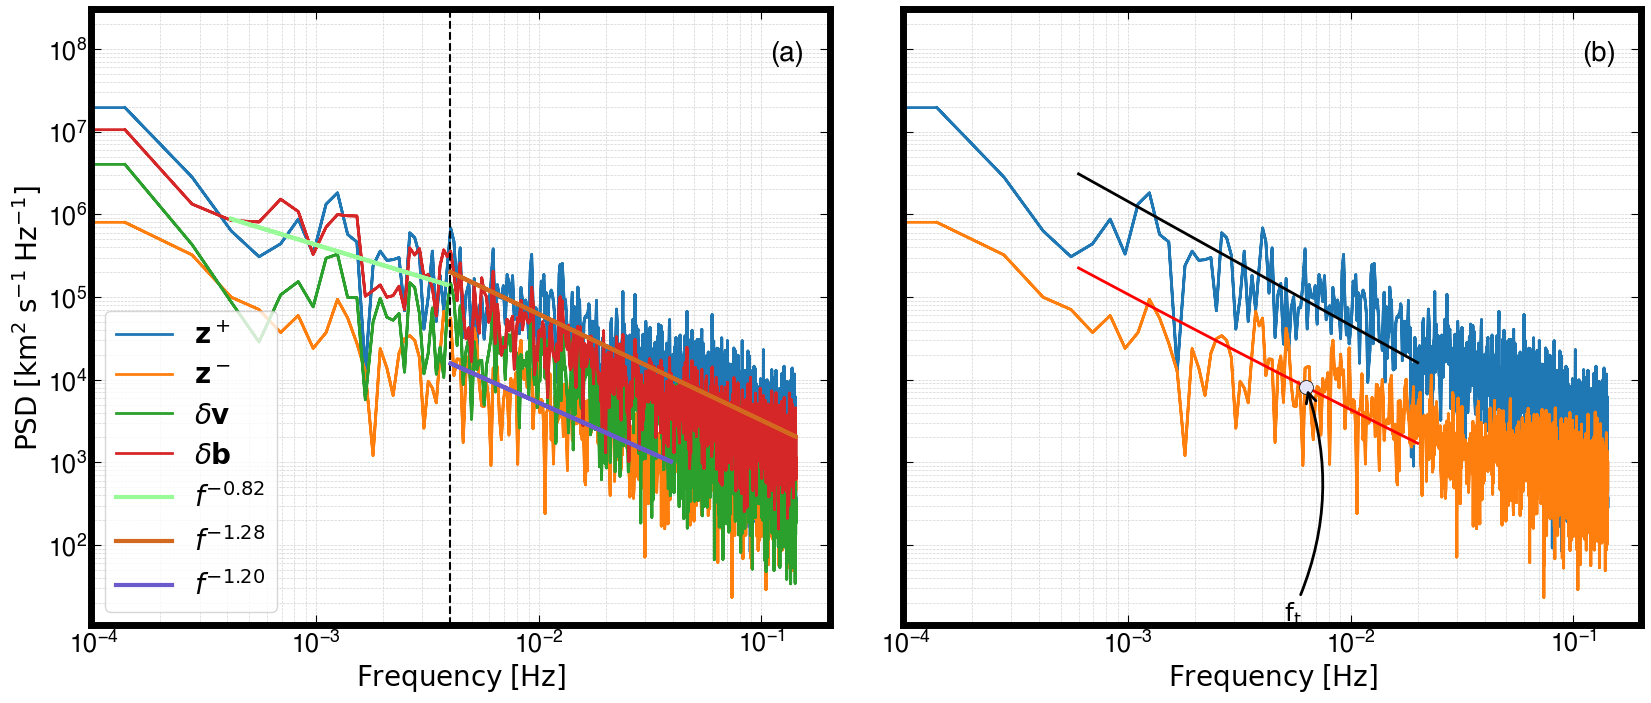

In [34]:
# Plot the PSD

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[20, 8], sharex='all', sharey='all', gridspec_kw={'hspace': 0.05, 'wspace':0.1})
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']
lw=2
##### -------- ELASSER SPECTRA #####
ax = ax1
for i, psd_spec in enumerate([psd_Zp2, psd_Zm2, psd_dv2, psd_db2]):
    ax.plot(psd_spec.freq, psd_spec.power, c=colors[i], label=labels[i], linewidth=lw)
ax.plot(psd_Zp2.freq[u2h], np.exp(i2h)*(psd_Zp2.freq[u2h]**e2h), c='palegreen', label=f'$f^{{{e2h:.2f}}}$', zorder=10, lw=3)
ax.plot(psd_Zp2.freq[u2l], np.exp(i2l)*(psd_Zp2.freq[u2l]**e2l), c='chocolate', label=f'$f^{{{e2l:.2f}}}$', zorder=10, lw=3)
ax.plot(psd_Zm2.freq[u2lm], np.exp(i2lm)*(psd_Zm2.freq[u2lm]**e2lm), c='slateblue', label=f'$f^{{{e2lm:.2f}}}$', zorder=10, lw=3)
ax.axvline(FT2, c='k', linestyle='dashed')

### LEGEND
ax.legend(loc='lower left', fontsize=20)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

##### -------- PANEL TWO: SPECTRAL FITS #####
freq = psd_Zp.freq
ax = ax2
for i, psd_spec in enumerate([psd_Zp2, psd_Zm2]):
    ax.plot(psd_spec.freq, psd_spec.power, c=colors[i], label=labels[i], linewidth=lw)

### PLOT FITS
freq = np.linspace(6e-4, 2e-2, num=len(kp))
kp = (2 * np.pi * freq)/(np.abs(u02 * np.cos(ang2) - vA02))
km = (2 * np.pi * freq)/(np.abs(u02 * np.cos(ang2) + vA02))
y1 = fit_function_p(kp, Cp_fit2, shared_Cinf_fit2) 
y2 = fit_function_m(km, Cm_fit2, shared_Cinf_fit2, kt_fit2)

ax.plot(freq, y1, c='k', lw=lw, zorder=2) # label=r'$\rm Z^{+} \; Fit$', 
ax.plot(freq, y2, c='red', lw=lw, zorder=2) #label=r'$\rm Z^{-} \; Fit$', 
ax.scatter(ft2, fit_function_m(kt_fit2, Cm_fit2, shared_Cinf_fit2, kt_fit2), s=100, c='lavender', edgecolor='k', lw=0.5, zorder=3)

### PLOT ERROR
### ERROR in P
errorp = var_p(kp, covariance1)
errorm = var_m(km, covariance2, kt_fit2)
# ax.fill_between(freq, y1 - errorp, y1 + errorp, color='lightblue', alpha=0.5, zorder=1)
# ax.fill_between(freq, y2 - errorm, y2 + errorm, color='lightgreen', alpha=0.5, zorder=1)

### ANNOTATE Ft
ax.annotate(r'$\rm f_t$', xy=(ft2, fit_function_m(kt_fit2, Cm_fit2, shared_Cinf_fit2, kt_fit2)-15), xytext=(5e-3, 12),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=2),fontsize=18)

### LEGEND
# ax.legend(loc='lower left', fontsize=20)

### LABELS
ax.text(0.92, 0.95, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 

### SCALES
ax2.set_xscale('log')  
ax2.set_yscale('log')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')



# Figure 4: PSD of Elasser Variables & Fluctuations

- Panels (a)/(c): Elasser variable spectra + fits
- Panels (b)/(d): fluctuation spectra 

In [ ]:
FT1=4e-3
psdd = psd_Zp
u1h = np.logical_and(psdd.freq>1e-4, psdd.freq<FT1)
e1h, i1h = fit_slope(psdd.freq[u1h],  psdd.power[u1h])
u1l = np.logical_and(psdd.freq>FT1, psdd.freq<1e-1)
e1l, i1l = fit_slope(psdd.freq[u1l],  psdd.power[u1l])
psdd = psd_Zm
u1m = np.logical_and(psdd.freq>FT1, psdd.freq<2e-2)
e1m, i1m = fit_slope(psdd.freq[u1m],  psdd.power[u1m])
# u1hm = np.logical_and(psdd.freq>3e-4, psdd.freq<FT1)
# e1hm, i1hm = fit_slope(psdd.freq[u1hm],  psdd.power[u1hm])
# psdd = psd_Zm
# u1lm = np.logical_and(psdd.freq>FT1, psdd.freq<2e-2)
# e1lm, i1lm = fit_slope(psdd.freq[u1lm],  psdd.power[u1lm])

print('Zp2')
psdd = psd_Zp2
FT2 = 4e-3
u2h = np.logical_and(psdd.freq>3e-4, psdd.freq<FT2)
e2h, i2h = fit_slope(psdd.freq[u2h],  psdd.power[u2h])
u2l = np.logical_and(psdd.freq>FT2, psdd.freq<5e-2)
e2l, i2l = fit_slope(psdd.freq[u2l],  psdd.power[u2l])
psdd = psd_Zm2
u2m = np.logical_and(psdd.freq>FT2, psdd.freq<2e-2) #3.5e-3
e2m, i2m = fit_slope(psdd.freq[u2m],  psdd.power[u2m])
psdd = psd_Zp2
FT2 = 4e-3
u2h = np.logical_and(psdd.freq>3e-4, psdd.freq<FT2)
e2h, i2h = fit_slope(psdd.freq[u2h],  psdd.power[u2h])
u2l = np.logical_and(psdd.freq>FT2, psdd.freq<1e0)
e2l, i2l = fit_slope(psdd.freq[u2l],  psdd.power[u2l])
psdd = psd_Zm2
u2lm = np.logical_and(psdd.freq>FT2, psdd.freq<4e-2)
e2lm, i2lm = fit_slope(psdd.freq[u2lm],  psdd.power[u2lm])

print('3')
psdd = psd_Zp3
FT3 = 4e-3
u3h = np.logical_and(psdd.freq>1e-4, psdd.freq<FT3)
e3h, i3h = fit_slope(psdd.freq[u3h],  psdd.power[u3h])
u3l = np.logical_and(psdd.freq>FT3, psdd.freq<1e-1)
e3l, i3l = fit_slope(psdd.freq[u3l],  psdd.power[u3l])
psdd = psd_Zm3
u3m = np.logical_and(psdd.freq>2e-3, psdd.freq<4e-2)
e3m, i3m = fit_slope(psdd.freq[u3m],  psdd.power[u3m])
# u3hm = np.logical_and(psdd.freq>8e-4, psdd.freq<FT3)
# e3hm, i3hm = fit_slope(psdd.freq[u3hm],  psdd.power[u3hm])
# u3lm = np.logical_and(psdd.freq>FT3, psdd.freq<2e-2)
# e3lm, i3lm = fit_slope(psdd.freq[u3lm],  psdd.power[u3lm])

In [ ]:
# Plot the PSD
fig, axs = plt.subplots(3, 2, figsize=[20, 30], sharex='all', sharey='row', gridspec_kw={'wspace':0.05, 'hspace':0.14})

colors = ['tab:green', 'tab:red', 'tab:blue', 'tab:orange']
labels=[r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$', r'$\mathbf{z}^+$', r'$\mathbf{z}^-$']
lw, lws =2, 4
ch, cl, clm, clmh = ['lightcoral', 'violet', 'dodgerblue', 'crimson']
zpc, zmc = ['k', 'slateblue']
### ------------------------------------------------------- ###
            ##### -------- INTERVAL ONE -------- #####
### ------------------------------------------------------- ###

##### -------- PANEL ONE: ELASSER SPECTRA -------- #####
ax = axs[0][0]
ax.set(xlim=(8e-5,3e-1), xticks=[1e-4, 1e-3, 1e-2, 1e-1], ylim=(5e-2, 5e6), yticks=[1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
good = np.logical_and(np.array(psd_Zp.freq)<=1, np.array(psd_Zp.freq)>=1e-4)
for i, psd_spec in enumerate([psd_dv, psd_db, psd_Zp, psd_Zm]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i], label=labels[i], linewidth=lw)
# ax.axvline(FT1, c='k', linestyle='dashed')

### PLOT FITS
use = np.logical_and(psd_Zp.freq>2e-4, psd_Zp.freq<2e-2)
freq = psd_Zp.freq[use]
kp = (2 * np.pi * freq)/(np.abs(u0 * np.cos(ang) - vA0))
y1 = fit_function_p(kp, Cp_fit1, shared_Cinf_fit1) 
ax.plot(freq, y1, c=zpc, lw=lws, zorder=2) 

km = (2 * np.pi * freq)/(np.abs(u0 * np.cos(ang) + vA0))
y2 = fit_function_m(km, Cm_fit1, shared_Cinf_fit1, kt_fit1)
ax.plot(freq, y2, c=zmc, lw=lws, zorder=2)  

### LEGEND
formatted_Cp_fit1 = '{:.1e}'.format(Cp_fit1)
formatted_Cm_fit1 = '{:.1e}'.format(Cm_fit1)
formatted_shared_Cinf_fit1 = '{:.1e}'.format(shared_Cinf_fit1)

Zp_label = f'{Cp_fit1:.1e}' + r'$\rm k_+^{{-3/2}}$' +  f' + {shared_Cinf_fit1:.1e}' + r'$\rm k_+^{{-5/3}}$'
Zm_label = f'{Cm_fit1:.1e}' + r'$\rm k_-^{{-3/2}}$' + r'$(1 + \sqrt{\frac{k_-}{k_t}})^{{1/2}}$' + f' + {shared_Cinf_fit1:.1e}' + r'$\rm k_-^{{-5/3}}$'
zp_patch = mpatches.Patch(edgecolor='k', facecolor=zpc, 
                          label=Zp_label)
# r'$\rm 2.2 \times 10^{-4} k_+^{{-3/2}} +  9.7 \times 10^{-7} k_+^{{-5/3}}$'
zm_patch = mpatches.Patch(edgecolor='k', facecolor=zmc, 
label=Zm_label)
# r'$\rm 6.9 \times 10^{-6} k_-^{{-3/2}}  (1 + \sqrt{\frac{k_-}{k_t}})^{{1/2}} + 9.7 \times 10^{-7} k_-^{{-5/3}}$'
leg1 = ax.legend(handles=[zp_patch, zm_patch], loc='lower left', fontsize=16)
ax.add_artist(leg1)

### THRESHOLD FREQUENCY
ax.scatter(ft1, fit_function_m(kt_fit1, Cm_fit1, shared_Cinf_fit1, kt_fit1), s=100, c='k', edgecolor='k', lw=0.5, zorder=3)
ax.annotate(r'$\rm f_t$',  xy=(ft1, fit_function_m(kt_fit1, Cm_fit1, shared_Cinf_fit1, kt_fit1)-0.5), xytext=(2e-3, 4),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=2),fontsize=18)

### LEGEND ###
zp_patch = mpatches.Patch(edgecolor='k', facecolor=colors[0], label=labels[0])
zm_patch = mpatches.Patch(edgecolor='k', facecolor=colors[1], label=labels[1])
dv_patch = mpatches.Patch(edgecolor='k', facecolor=colors[2], label=labels[2])
db_patch = mpatches.Patch(edgecolor='k', facecolor=colors[3], label=labels[3])
leg0 = ax.legend(handles=[dv_patch, db_patch, zp_patch, zm_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

##### -------- PANEL TWO: SPECTRAL FITS -------- #####
ax = axs[0][1]
good = np.logical_and(np.array(psd_Zp.freq)<=1, np.array(psd_Zp.freq)>=1e-4)
for i, psd_spec in enumerate([psd_Zp, psd_Zm]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i+2], label=labels[i], linewidth=lw)

### SLOPE FITS
ax.plot(psd_Zp.freq[u1h], np.exp(i1h)*(psd_Zp.freq[u1h]**e1h), c=ch, label=f'$f^{{{e1h:.2f}}}$', zorder=10, lw=lws)
ax.plot(psd_Zp.freq[u1l], np.exp(i1l)*(psd_Zp.freq[u1l]**e1l), c=cl, label=f'$f^{{{e1l:.2f}}}$', zorder=10, lw=lws)
# ax.plot(psd_Zm.freq[u1m], np.exp(i1m)*(psd_Zm.freq[u1m]**e1m), c=clm, label=f'$f^{{{e1m:.2f}}}$', zorder=10, lw=lws)
# ax.plot(psd_Zm.freq[u1hm], np.exp(i1hm)*(psd_Zm.freq[u1hm]**e1hm), c=clmh, label=f'$f^{{{e1hm:.2f}}}$', zorder=10, lw=lws)
# ax.plot(psd_Zm.freq[u1lm], np.exp(i1lm)*(psd_Zm.freq[u1lm]**e1lm), c=clm, label=f'$f^{{{e1lm:.2f}}}$', zorder=10, lw=lws)
ax.plot(psd_Zm.freq, np.exp(i1lm)*(psd_Zm.freq**e1lm), c=clm, label=f'$f^{{{e1lm:.2f}}}$', zorder=10, lw=lws)

ax.axvline(FT1, c='k', linestyle='dashed')

### LEGEND ###
zp_patch = mpatches.Patch(edgecolor='k', facecolor=ch, label=f'$f^{{{e1h:.2f}}}$')
zm_patch = mpatches.Patch(edgecolor='k', facecolor=cl, label=f'$f^{{{e1l:.2f}}}$')
dv_patch = mpatches.Patch(edgecolor='k', facecolor=clmh, label=f'$f^{{{e1hm:.2f}}}$')
db_patch = mpatches.Patch(edgecolor='k', facecolor=clm, label=f'$f^{{{e1lm:.2f}}}$')
leg0 = ax.legend(handles=[zp_patch, zm_patch, dv_patch, db_patch], loc='lower left', fontsize=16)
ax.add_artist(leg0)

### LABELS
ax.text(0.92, 0.95, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', which='major', labelsize=18) 

### SCALES
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray', zorder=-4)

## ------------------------------------------------------- ###
            ##### -------- INTERVAL THREE -------- #####
### ------------------------------------------------------- ###

##### -------- PANEL THREE: ELASSER SPECTRA (P2) -------- #####
ax = axs[1][0]
ax.set(xlim=(8e-5,3e-1), xticks=[1e-4, 1e-3, 1e-2, 1e-1], ylim=(5e0, 5e8), yticks=[1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])
good = np.logical_and(np.array(psd_Zp2.freq)<=1, np.array(psd_Zp2.freq)>=1e-4)
for i, psd_spec in enumerate([psd_dv2, psd_db2, psd_Zp2, psd_Zm2]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i], label=labels[i], linewidth=lw)
# ax.axvline(FT2, c='k', linestyle='dashed')

### PLOT FITS
freq = np.linspace(2e-3, 2e-2, num=len(kp))
kp = (2 * np.pi * freq)/(np.abs(u02 * np.cos(ang2) - vA02))
y1 = fit_function_p(kp, Cp_fit2, shared_Cinf_fit2) 
ax.plot(freq, y1, c=zpc, lw=lws, zorder=2) 

km = (2 * np.pi * freq)/(np.abs(u02 * np.cos(ang2) + vA02))
y2 = fit_function_m(km, Cm_fit2, shared_Cinf_fit2, kt_fit2)
ax.plot(freq, y2, c=zmc, lw=lws, zorder=2)  

### LEGEND
formatted_Cp_fit2 = '{:.1e}'.format(Cp_fit2)
formatted_Cm_fit2 = '{:.1e}'.format(Cm_fit2)
formatted_shared_Cinf_fit2 = '{:.1e}'.format(shared_Cinf_fit2)
Zp_label = f'{Cp_fit2:.1e}' + r'$\rm k_+^{{-3/2}}$' +  f' + {shared_Cinf_fit2:.1e}' + r'$\rm k_+^{{-5/3}}$'
Zm_label = f'{Cm_fit2:.1e}' + r'$\rm k_-^{{-3/2}}$' + r'$(1 + \sqrt{\frac{k_-}{k_t}})^{{1/2}}$' + f' + {shared_Cinf_fit2:.1e}' + r'$\rm k_-^{{-5/3}}$'
zp_patch = mpatches.Patch(edgecolor='k', facecolor=zpc, label=Zp_label)
                        #   label=r'$\rm 2.8 \times 10^{-3} k_+^{{-3/2}} +  3.3 \times 10^{-5} k_+^{{-5/3}}$')
zm_patch = mpatches.Patch(edgecolor='k', facecolor=zmc, label=Zm_label)
# label=r'$\rm 7.3 \times 10^{-16} k_-^{{-3/2}}  (1 + \sqrt{\frac{k_-}{k_t}})^{{1/2}} + 3.3 \times 10^{-5} k_-^{{-5/3}}$')
leg1 = ax.legend(handles=[zp_patch, zm_patch], loc='lower left', fontsize=16)
ax.add_artist(leg1)

### THRESHOLD FREQUENCY
ax.scatter(ft2, fit_function_m(kt_fit2, Cm_fit2, shared_Cinf_fit2, kt_fit2), s=100, c='k', edgecolor='k', lw=0.5, zorder=3)
ax.annotate(r'$\rm f_t$',  xy=(ft2, fit_function_m(kt_fit2, Cm_fit2, shared_Cinf_fit2, kt_fit2)-20), xytext=(9e-3, 12),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=2),fontsize=18)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(c)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

##### -------- PANEL FOUR: SPECTRAL FITS (P2) -------- #####
ax = axs[1][1]
freq = psd_Zp2.freq
good = np.logical_and(np.array(freq)<=1, np.array(freq)>=1e-4)
for i, psd_spec in enumerate([psd_Zp2, psd_Zm2]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i+2], label=labels[i+2], linewidth=lw, zorder=1)

### SLOPE FITS
ax.plot(psd_Zp2.freq[u2h], np.exp(i2h)*(psd_Zp2.freq[u2h]**e2h), c=ch, label=f'$f^{{{e2h:.2f}}}$', zorder=10, lw=lws)
ax.plot(psd_Zp2.freq[u2l], np.exp(i2l)*(psd_Zp2.freq[u2l]**e2l), c=cl, label=f'$f^{{{e2l:.2f}}}$', zorder=10, lw=lws)
ax.plot(psd_Zm2.freq[u2hm], np.exp(i2hm)*(psd_Zm2.freq[u2hm]**e2hm), c=clmh, label=f'$f^{{{e2hm:.2f}}}$', zorder=10, lw=lws)
ax.plot(psd_Zm2.freq[u2lm], np.exp(i2lm)*(psd_Zm2.freq[u2lm]**e2lm), c=clm, label=f'$f^{{{e2lm:.2f}}}$', zorder=10, lw=lws)

ax.axvline(FT1, c='k', linestyle='dashed')

### LEGEND ###
zp_patch = mpatches.Patch(edgecolor='k', facecolor=ch, label=f'$f^{{{e2h:.2f}}}$')
zm_patch = mpatches.Patch(edgecolor='k', facecolor=cl, label=f'$f^{{{e2l:.2f}}}$')
dv_patch = mpatches.Patch(edgecolor='k', facecolor=clmh, label=f'$f^{{{e2hm:.2f}}}$')
db_patch = mpatches.Patch(edgecolor='k', facecolor=clm, label=f'$f^{{{e2lm:.2f}}}$')

leg0 = ax.legend(handles=[zp_patch, zm_patch, dv_patch, db_patch], loc='lower left', fontsize=16)
ax.add_artist(leg0)

### LABELS
ax.text(0.92, 0.95, '(d)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', which='major', labelsize=18) 

### SCALES
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray', zorder=-4)


### ------------------------------------------------------- ###
            ##### -------- INTERVAL THREE -------- #####
### ------------------------------------------------------- ###

##### -------- PANEL THREE: ELASSER SPECTRA (P2) -------- #####
ax = axs[2][0]
ax.set(xlim=(8e-5,3e-1), xticks=[1e-4, 1e-3, 1e-2, 1e-1], ylim=(5e0, 5e8), yticks=[1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])
good = np.logical_and(np.array(psd_Zp3.freq)<=1, np.array(psd_Zp3.freq)>=1e-4)
for i, psd_spec in enumerate([psd_dv3, psd_db3, psd_Zp3, psd_Zm3]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i], label=labels[i], linewidth=lw)
# ax.axvline(FT2, c='k', linestyle='dashed')

### PLOT FITS
freq = np.linspace(2e-3, 2e-2, num=len(kp))
kp = (2 * np.pi * freq)/(np.abs(u03 * np.cos(ang3) - vA03))
y1 = fit_function_p(kp, Cp_fit3, shared_Cinf_fit3) 
ax.plot(freq, y1, c=zpc, lw=lws, zorder=2) 

km = (2 * np.pi * freq)/(np.abs(u03 * np.cos(ang3) + vA03))
y2 = fit_function_m(km, Cm_fit3, shared_Cinf_fit3, kt_fit3)
ax.plot(freq, y2, c=zmc, lw=lws, zorder=2)  

### LEGEND
formatted_Cp_fit2 = '{:.1e}'.format(Cp_fit2)
formatted_Cm_fit2 = '{:.1e}'.format(Cm_fit2)
formatted_shared_Cinf_fit2 = '{:.1e}'.format(shared_Cinf_fit2)
Zp_label = f'{Cp_fit3:.1e}' + r'$\rm k_+^{{-3/2}}$' +  f' + {shared_Cinf_fit3:.1e}' + r'$\rm k_+^{{-5/3}}$'
Zm_label = f'{Cm_fit3:.1e}' + r'$\rm k_-^{{-3/2}}$' + r'$(1 + \sqrt{\frac{k_-}{k_t}})^{{1/2}}$' + f' + {shared_Cinf_fit3:.1e}' + r'$\rm k_-^{{-5/3}}$'
zp_patch = mpatches.Patch(edgecolor='k', facecolor=zpc, label=Zp_label)
                        #   label=r'$\rm 2.8 \times 10^{-3} k_+^{{-3/2}} +  3.3 \times 10^{-5} k_+^{{-5/3}}$')
zm_patch = mpatches.Patch(edgecolor='k', facecolor=zmc, label=Zm_label)
# label=r'$\rm 7.3 \times 10^{-16} k_-^{{-3/2}}  (1 + \sqrt{\frac{k_-}{k_t}})^{{1/2}} + 3.3 \times 10^{-5} k_-^{{-5/3}}$')
leg1 = ax.legend(handles=[zp_patch, zm_patch], loc='lower left', fontsize=16)
ax.add_artist(leg1)

### THRESHOLD FREQUENCY
ax.scatter(ft3, fit_function_m(kt_fit3, Cm_fit3, shared_Cinf_fit3, kt_fit3), s=100, c='k', edgecolor='k', lw=0.5, zorder=3)
ax.annotate(r'$\rm f_t$',  xy=(ft3, fit_function_m(kt_fit3, Cm_fit3, shared_Cinf_fit3, kt_fit3)-20), xytext=(9e-3, 12),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=2),fontsize=18)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(e)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

##### -------- PANEL FOUR: SPECTRAL FITS (P2) -------- #####
ax = axs[2][1]
freq = psd_Zp3.freq
good = np.logical_and(np.array(freq)<=1, np.array(freq)>=1e-4)
for i, psd_spec in enumerate([psd_Zp3, psd_Zm3]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i+2], label=labels[i+2], linewidth=lw, zorder=1)

### SLOPE FITS
ax.plot(psd_Zp3.freq[u3h], np.exp(i3h)*(psd_Zp3.freq[u3h]**e3h), c=ch, label=f'$f^{{{e3h:.2f}}}$', zorder=10, lw=lws)
ax.plot(psd_Zp3.freq[u3l], np.exp(i3l)*(psd_Zp3.freq[u3l]**e3l), c=cl, label=f'$f^{{{e3l:.2f}}}$', zorder=10, lw=lws)
ax.plot(psd_Zm3.freq[u3hm], np.exp(i3hm)*(psd_Zm3.freq[u3hm]**e3hm), c=clmh, label=f'$f^{{{e3hm:.2f}}}$', zorder=10, lw=lws)
ax.plot(psd_Zm3.freq[u3lm], np.exp(i3lm)*(psd_Zm3.freq[u3lm]**e3lm), c=clm, label=f'$f^{{{e3lm:.2f}}}$', zorder=10, lw=lws)

ax.axvline(FT1, c='k', linestyle='dashed')

### LEGEND ###
zp_patch = mpatches.Patch(edgecolor='k', facecolor=ch, label=f'$f^{{{e3h:.2f}}}$')
zm_patch = mpatches.Patch(edgecolor='k', facecolor=cl, label=f'$f^{{{e3l:.2f}}}$')
dv_patch = mpatches.Patch(edgecolor='k', facecolor=clmh, label=f'$f^{{{e3hm:.2f}}}$')
db_patch = mpatches.Patch(edgecolor='k', facecolor=clm, label=f'$f^{{{e3lm:.2f}}}$')

leg0 = ax.legend(handles=[zp_patch, zm_patch, dv_patch, db_patch], loc='lower left', fontsize=16)
ax.add_artist(leg0)

### LABELS
ax.text(0.92, 0.95, '(f)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', which='major', labelsize=18) 

### SCALES
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray', zorder=-4)

### ADD PANEL LABELS 
fig.text(0.06, 0.5, r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20, va='center', rotation='vertical')
fig.text(0.475, 0.07, r'$\rm Frequency \; [Hz]$', fontsize=20, va='center', rotation='horizontal')

### TITLES
fig.text(0.5, 0.90, r'$\rm Sub-Alfv\'enic \; Interval \; One: \; 2023-03-16/12:00 \; to \; 18:00$', fontsize=20, ha='center', va='center', rotation='horizontal') # period one
fig.text(0.5, 0.62, r'$\rm Sub-Alfv\'enic \; Interval \; Two: \; 2023-03-16/18:00 \; to \; 2023-03-17/00:00$', fontsize=20, ha='center', va='center', rotation='horizontal') # period two
fig.text(0.5, 0.35, r'$\rm Sub-Alfv\'enic \; Interval \; Three: \; 2023-03-17/00:00 \; to \; 06:00$', fontsize=20, ha='center', va='center', rotation='horizontal') # period two

### SAVE FIGURE
plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'fig6.png')), bbox_inches='tight')
plt.savefig(os.path.realpath(os.path.join(EPS_DIR, 'fig6.eps')), bbox_inches='tight')


# Final Figure

In [8]:
FT1 = 5.9e-3
u1h = np.logical_and(psdd.freq>1e-4, psdd.freq<FT1)
u1l = np.logical_and(psdd.freq>FT1, psdd.freq<1e-1)
u1lm = np.logical_and(psdd.freq>1e-3, psdd.freq<2e-2)

FT2 = 4e-3
u2h = np.logical_and(psdd.freq>1e-4, psdd.freq<FT2)
u2l = np.logical_and(psdd.freq>FT2, psdd.freq<1e-1)
u2lm = np.logical_and(psdd.freq>1e-3, psdd.freq<2e-2)

FT3 = 2.2e-3
u3h = np.logical_and(psdd.freq>1e-4, psdd.freq<FT3)
u3l = np.logical_and(psdd.freq>FT3, psdd.freq<1e-1)


use = np.logical_and(psd_Zp.freq>9e-4, psd_Zp.freq<6e-2)
ff = psd_Zp.freq[use]

NameError: name 'psdd' is not defined

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


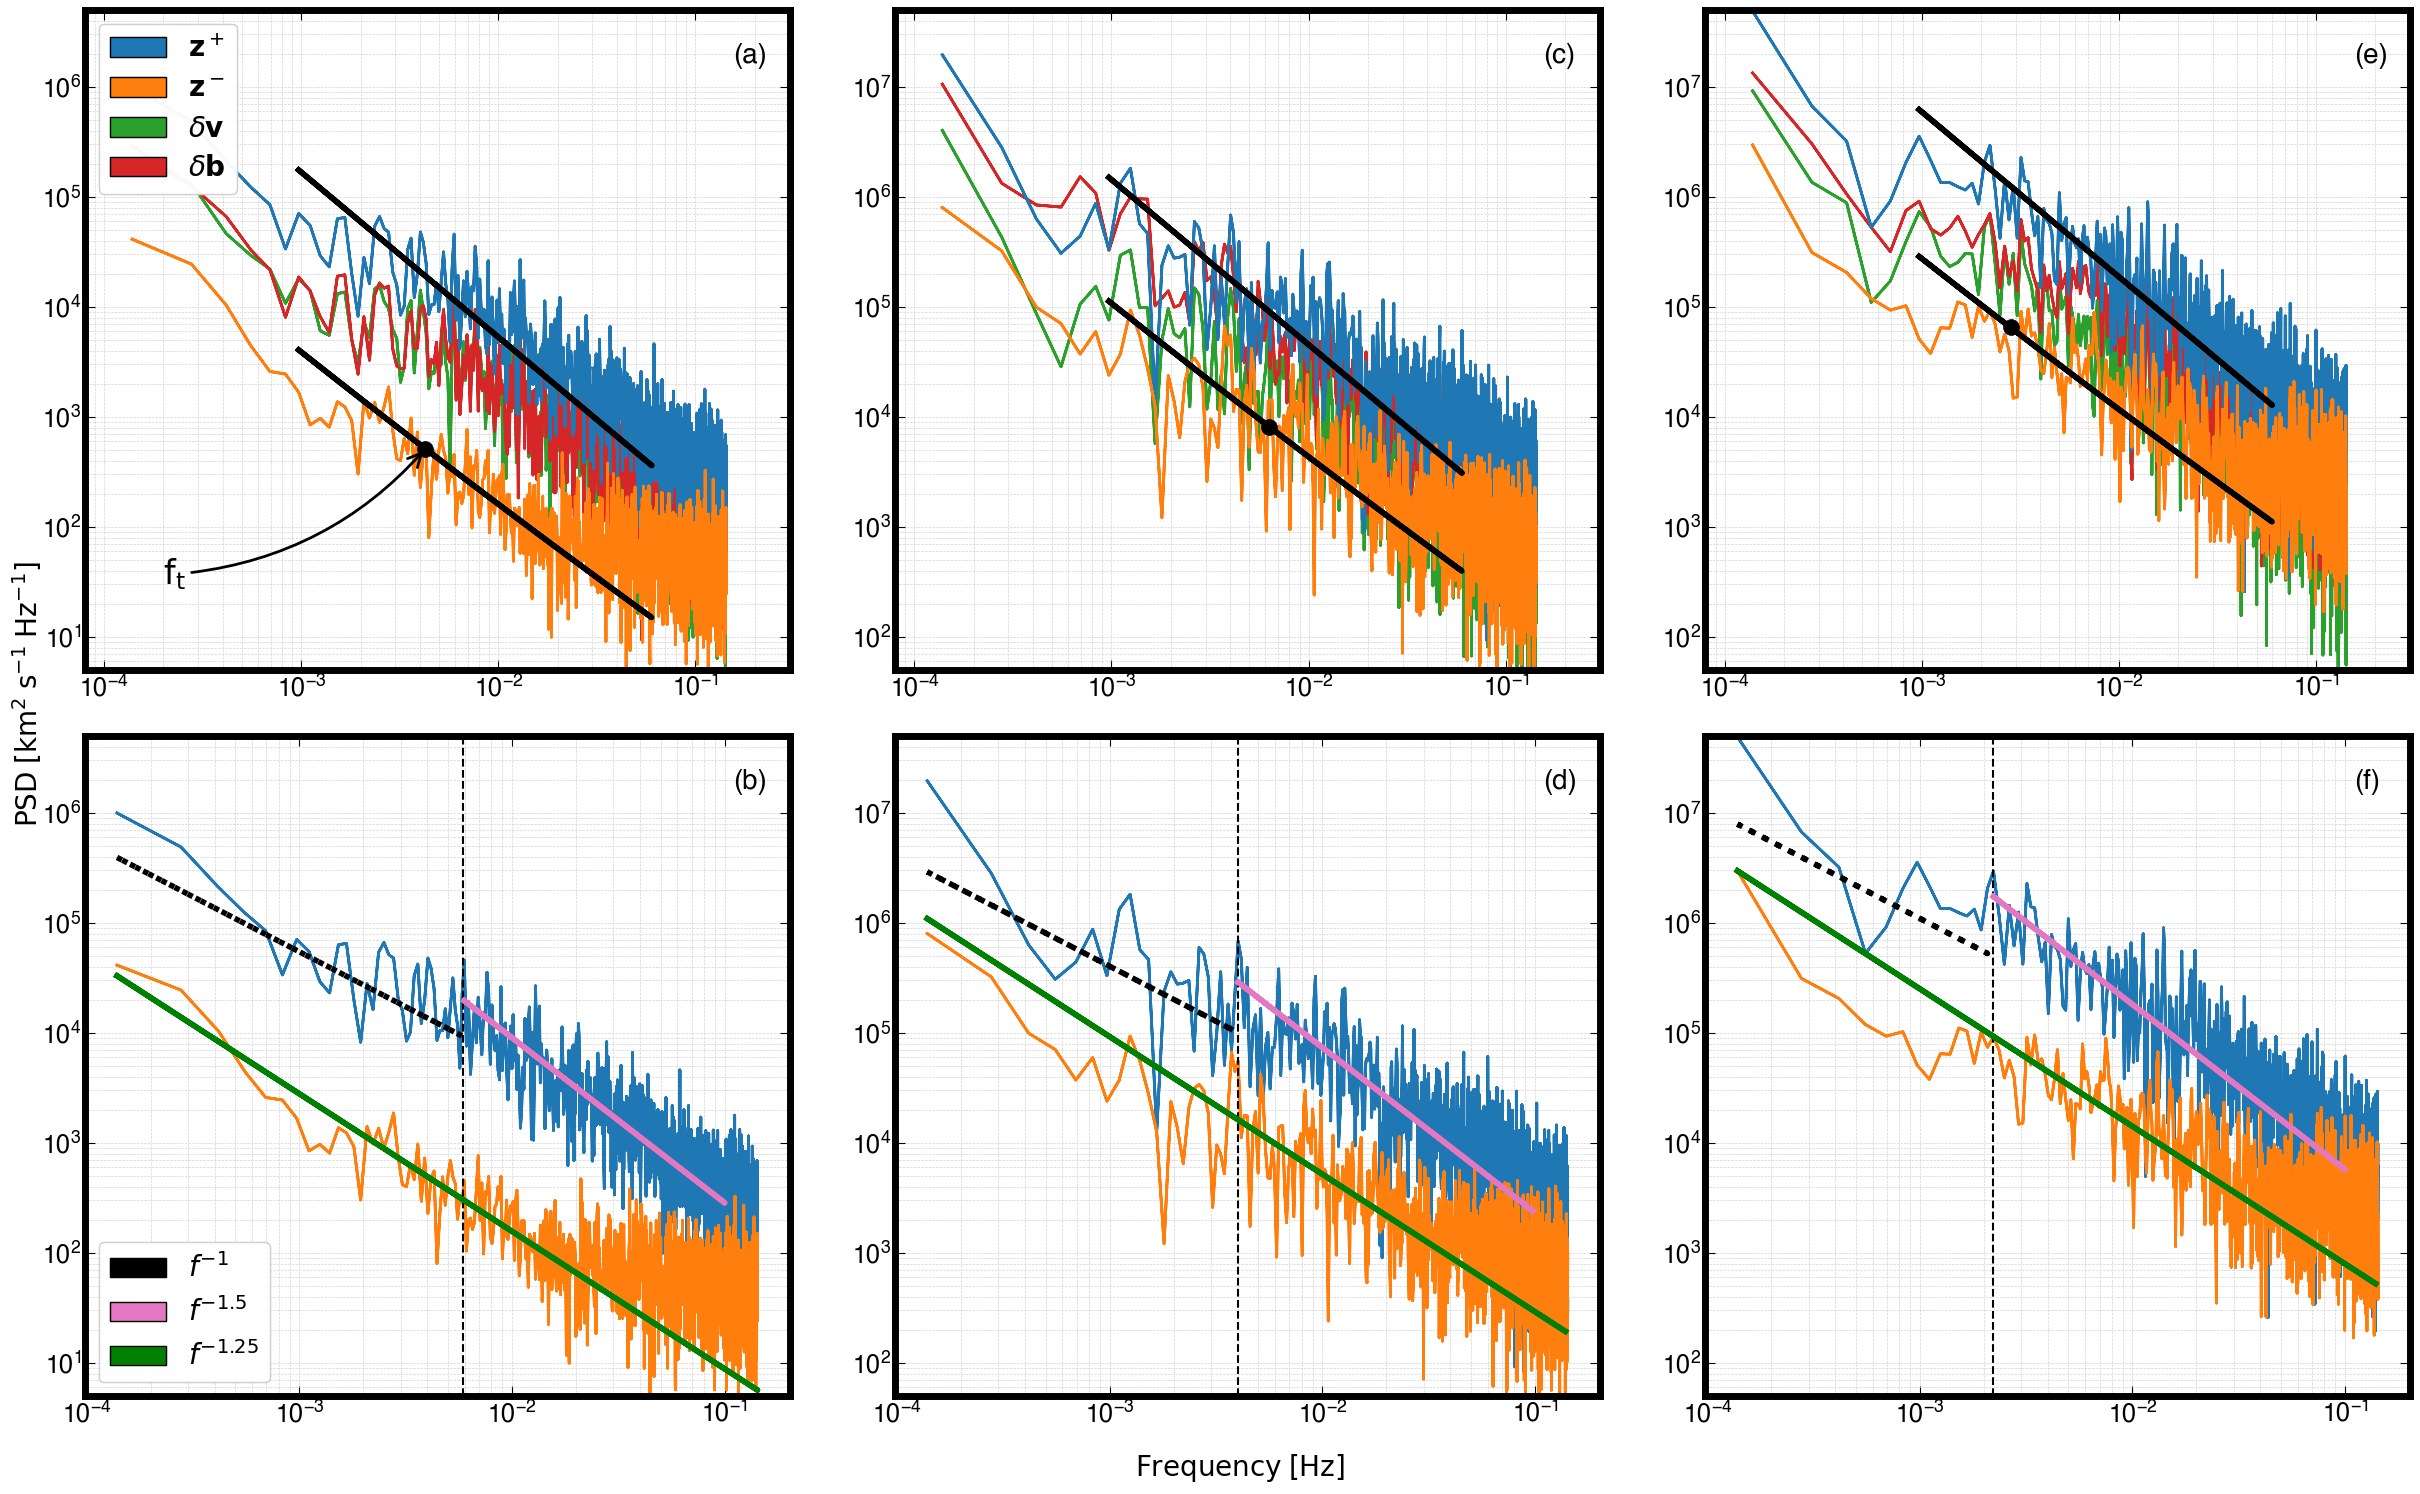

In [40]:
# Plot the PSD
fig, axs = plt.subplots(2, 3, figsize=[30, 18], sharey='col', gridspec_kw={'wspace':0.15, 'hspace':0.10})

colors = ['tab:green', 'tab:red', 'tab:blue', 'tab:orange']
labels=[r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$', r'$\mathbf{z}^+$', r'$\mathbf{z}^-$']
lw, lws =2, 4
ch, cl, clm, clmh = ['k', 'tab:pink', 'green', 'crimson']
zpc, zmc = ['k', 'k'] # slateblue
### ------------------------------------------------------- ###
            ##### -------- INTERVAL ONE -------- #####
### ------------------------------------------------------- ###

##### -------- PANEL ONE: ELASSER SPECTRA -------- #####
ax = axs[0][0]
ax.set(xlim=(8e-5,3e-1), xticks=[1e-4, 1e-3, 1e-2, 1e-1], ylim=(5e0, 5e6), yticks=[1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
good = np.logical_and(np.array(psd_Zp.freq)<=1, np.array(psd_Zp.freq)>=1e-4)
for i, psd_spec in enumerate([psd_dv, psd_db, psd_Zp, psd_Zm]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i], label=labels[i], linewidth=lw)
# ax.axvline(FT1, c='k', linestyle='dashed')

### PLOT FITS
kp = (2 * np.pi * ff)/(np.abs(u0 * np.cos(ang) - vA0))
y1 = fit_function_p(kp, Cp_fit1, shared_Cinf_fit1) 
ax.plot(ff, y1, c=zpc, lw=lws, zorder=2) 

km = (2 * np.pi * ff)/(np.abs(u0 * np.cos(ang) + vA0))
y2 = fit_function_m(km, Cm_fit1, shared_Cinf_fit1, kt_fit1)
ax.plot(ff, y2, c=zmc, lw=lws, zorder=2)  

### LEGEND
formatted_Cp_fit1 = '{:.1e}'.format(Cp_fit1)
formatted_Cm_fit1 = '{:.1e}'.format(Cm_fit1)
formatted_shared_Cinf_fit1 = '{:.1e}'.format(shared_Cinf_fit1)


### THRESHOLD FREQUENCY
ax.scatter(ft1, fit_function_m(kt_fit1, Cm_fit1, shared_Cinf_fit1, kt_fit1), s=130, c='k', edgecolor='k', lw=0.5, zorder=3)
ax.annotate(r'$\rm f_t$',  xy=(ft1, fit_function_m(kt_fit1, Cm_fit1, shared_Cinf_fit1, kt_fit1)-0.5), xytext=(2e-4, 30),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=2),fontsize=24)

### LEGEND ###
zp_patch = mpatches.Patch(edgecolor='k', facecolor=colors[0], label=labels[0])
zm_patch = mpatches.Patch(edgecolor='k', facecolor=colors[1], label=labels[1])
dv_patch = mpatches.Patch(edgecolor='k', facecolor=colors[2], label=labels[2])
db_patch = mpatches.Patch(edgecolor='k', facecolor=colors[3], label=labels[3])
leg0 = ax.legend(handles=[dv_patch, db_patch, zp_patch, zm_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

##### -------- PANEL TWO: SPECTRAL FITS -------- #####
ax = axs[1][0]
good = np.logical_and(np.array(psd_Zp.freq)<=1, np.array(psd_Zp.freq)>=1e-4)
for i, psd_spec in enumerate([psd_Zp, psd_Zm]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i+2], label=labels[i], linewidth=lw)

### SLOPE FITS4, 2.2, -0.7
ax.plot(psd_Zp.freq[u1h], np.exp(4)*(psd_Zp.freq[u1h]**-1), c=ch, label=f'$f^{{{e1h:.2f}}}$', zorder=10, lw=lws, linestyle='dotted')
ax.plot(psd_Zp.freq[u1l], np.exp(2.2)*(psd_Zp.freq[u1l]**-1.5), c=cl, label=f'$f^{{{e1l:.2f}}}$', zorder=10, lw=lws)
ax.plot(psd_Zm.freq, np.exp(-0.7)*(psd_Zm.freq**-1.25), c=clm, label=f'$f^{{{e1lm:.2f}}}$', zorder=10, lw=lws)

ax.axvline(FT1, c='k', linestyle='dashed')

### LEGEND ###
zp_patch = mpatches.Patch(edgecolor='k', facecolor=ch, label=f'$f^{{-1}}$')
zm_patch = mpatches.Patch(edgecolor='k', facecolor=cl, label=f'$f^{{-1.5}}$')
db_patch = mpatches.Patch(edgecolor='k', facecolor=clm, label=f'$f^{{-1.25}}$')
leg0 = ax.legend(handles=[zp_patch, zm_patch, db_patch], loc='lower left', fontsize=20)
ax.add_artist(leg0)

### LABELS
ax.text(0.92, 0.95, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', which='major', labelsize=18) 

### SCALES
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray', zorder=-4)

## ------------------------------------------------------- ###
            ##### -------- INTERVAL TWO -------- #####
### ------------------------------------------------------- ###

##### -------- PANEL THREE: ELASSER SPECTRA (P2) -------- #####
ax = axs[0][1]
ax.set(xlim=(8e-5,3e-1), xticks=[1e-4, 1e-3, 1e-2, 1e-1], ylim=(5e1, 5e7), yticks=[1e2, 1e3, 1e4, 1e5, 1e6, 1e7])
good = np.logical_and(np.array(psd_Zp2.freq)<=1, np.array(psd_Zp2.freq)>=1e-4)
for i, psd_spec in enumerate([psd_dv2, psd_db2, psd_Zp2, psd_Zm2]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i], label=labels[i], linewidth=lw)
# ax.axvline(FT2, c='k', linestyle='dashed')

### PLOT FITS
kp = (2 * np.pi * ff)/(np.abs(u02 * np.cos(ang2) - vA02))
y1 = fit_function_p(kp, Cp_fit2, shared_Cinf_fit2) 
ax.plot(ff, y1, c=zpc, lw=lws, zorder=2) 

km = (2 * np.pi * ff)/(np.abs(u02 * np.cos(ang2) + vA02))
y2 = fit_function_m(km, Cm_fit2, shared_Cinf_fit2, kt_fit2)
ax.plot(ff, y2, c=zmc, lw=lws, zorder=2)  

### THRESHOLD FREQUENCY
ax.scatter(ft2, fit_function_m(kt_fit2, Cm_fit2, shared_Cinf_fit2, kt_fit2), s=130, c='k', edgecolor='k', lw=0.5, zorder=3)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(c)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

##### -------- PANEL FOUR: SPECTRAL FITS (P2) -------- #####
ax = axs[1][1]
freq = psd_Zp2.freq
good = np.logical_and(np.array(freq)<=1, np.array(freq)>=1e-4)
for i, psd_spec in enumerate([psd_Zp2, psd_Zm2]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i+2], label=labels[i+2], linewidth=lw, zorder=1)

### SLOPE FITS
ax.plot(psd_Zm2.freq, np.exp(2.8)*(psd_Zm2.freq**-1.25), c=clm, label=f'$f^{-1.25}$', zorder=10, lw=lws)
ax.plot(psd_Zp2.freq[u2h], np.exp(6)*(psd_Zp2.freq[u2h]**-1), c=ch, label=f'$f^{{{-1}}}$', zorder=10, lw=lws, linestyle='dotted')
ax.plot(psd_Zp2.freq[u2l], np.exp(4.3)*(psd_Zp2.freq[u2l]**-1.5), c=cl, label=f'$f^{{{-1.5}}}$', zorder=10, lw=lws)
ax.axvline(FT2, c='k', linestyle='dashed')

### LABELS
ax.text(0.92, 0.95, '(d)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', which='major', labelsize=18) 

### SCALES
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray', zorder=-4)


### ------------------------------------------------------- ###
            ##### -------- INTERVAL THREE -------- #####
### ------------------------------------------------------- ###

##### -------- PANEL THREE: ELASSER SPECTRA (P2) -------- #####
ax = axs[0][2]
ax.set(xlim=(8e-5,3e-1), xticks=[1e-4, 1e-3, 1e-2, 1e-1], ylim=(5e1, 5e7), yticks=[1e2, 1e3, 1e4, 1e5, 1e6, 1e7])
good = np.logical_and(np.array(psd_Zp3.freq)<=1, np.array(psd_Zp3.freq)>=1e-4)
for i, psd_spec in enumerate([psd_dv3, psd_db3, psd_Zp3, psd_Zm3]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i], label=labels[i], linewidth=lw)

### PLOT FITS
kp = (2 * np.pi * ff)/(np.abs(u03 * np.cos(ang3) - vA03))
y1 = fit_function_p(kp, Cp_fit3, shared_Cinf_fit3) 
ax.plot(ff, y1, c=zpc, lw=lws, zorder=2) 

km = (2 * np.pi * ff)/(np.abs(u03 * np.cos(ang3) + vA03))
y2 = fit_function_m(km, Cm_fit3, shared_Cinf_fit3, kt_fit3)
ax.plot(ff, y2, c=zmc, lw=lws, zorder=2)  

### THRESHOLD FREQUENCY
ax.scatter(ft3, fit_function_m(kt_fit3, Cm_fit3, shared_Cinf_fit3, kt_fit3), s=130, c='k', edgecolor='k', lw=0.5, zorder=3)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(e)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

##### -------- PANEL FOUR: SPECTRAL FITS (P2) -------- #####
ax = axs[1][2]
freq = psd_Zp3.freq
good = np.logical_and(np.array(freq)<=1, np.array(freq)>=1e-4)
for i, psd_spec in enumerate([psd_Zp3, psd_Zm3]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i+2], label=labels[i+2], linewidth=lw, zorder=1)

### SLOPE FITS
ax.plot(psd_Zm3.freq, np.exp(3.8)*(psd_Zm3.freq**-1.25), c=clm, label=f'$f^{{{-1.25}}}$', zorder=10, lw=lws)
ax.plot(psd_Zp3.freq[u3h], np.exp(7)*(psd_Zp3.freq[u3h]**-1), c=ch, label=f'$f^{{{-1}}}$', zorder=10, lw=lws, linestyle='dotted')
ax.plot(psd_Zp3.freq[u3l], np.exp(5.2)*(psd_Zp3.freq[u3l]**-1.5), c=cl, label=f'$f^{{{-1.5}}}$', zorder=10, lw=lws)
ax.axvline(FT3, c='k', linestyle='dashed')


### LABELS
ax.text(0.92, 0.95, '(f)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', which='major', labelsize=18) 

### SCALES
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray', zorder=-4)

### ADD PANEL LABELS 
fig.text(0.10, 0.5, r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20, va='center', rotation='vertical')
fig.text(0.475, 0.07, r'$\rm Frequency \; [Hz]$', fontsize=20, va='center', rotation='horizontal')

### SAVE FIGURE
plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'fig6.png')), bbox_inches='tight')
plt.savefig(os.path.realpath(os.path.join(EPS_DIR, 'fig6.eps')), bbox_inches='tight')


In [ ]:
### TESTING CORRELATION TIME SCALE
### C(tau) = 1/N sum(Z(t) * Z(t + tau))

def correlation_time(Z, ii):
    N = len(Z)
    C = [Z[i] * Z[i+ii] for i in np.arange(0, N-ii)]
    C = np.nansum(C) / N
    R = np.nansum(Z*Z) / N
    return C, R

corr_zp, corr_zm, corr_dv, corr_db = [], [], [], []
for ii in np.linspace(1, 1200):
    C, R = correlation_time(np.array(tf.Zp), int(ii))
    corr_zm.append(C/R)
    C, R = correlation_time(np.array(tf.Zm), int(ii))
    corr_zp.append(C/R)
    C, R = correlation_time(np.array(tf.deltav), int(ii))
    corr_dv.append(C/R)
    C, R = correlation_time(np.array(tf.deltab), int(ii))
    corr_db.append(C/R)
plt.plot(np.linspace(1, 1200)*3.5, corr_zp, c='tab:blue', label=r'$\rm Z^{+}$')
plt.plot(np.linspace(1, 1200)*3.5, corr_zm, c='tab:orange', label=r'$\rm Z^{-}$')
plt.plot(np.linspace(1, 1200)*3.5, corr_dv, c='tab:red', label=r'$\rm \delta v$')
plt.plot(np.linspace(1, 1200)*3.5, corr_db, c='tab:green', label=r'$\rm \delta b$')
plt.xlabel(r'$\rm \tau \; [s]$', fontsize=16)
plt.ylabel(r'$\rm R(\tau)$', fontsize=16)
plt.legend(fontsize=16)
plt.axhline(1/np.e, c='pink', linestyle='dashed')

# Talk Figure

In [ ]:
# Plot the PSD
fig, axs = plt.subplots(1, 2, figsize=[20, 10], sharex='all', gridspec_kw={'wspace':0.2, 'hspace':0.14})

colors = ['tab:green', 'tab:red', 'tab:blue', 'tab:orange']
labels=[r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$', r'$\mathbf{z}^+$', r'$\mathbf{z}^-$']
lw, lws =2, 4
ch, cl, clm, clmh = ['lightcoral', 'violet', 'dodgerblue', 'crimson']
zpc, zmc = ['k', 'slateblue']
### ------------------------------------------------------- ###
            ##### -------- INTERVAL ONE -------- #####
### ------------------------------------------------------- ###

##### -------- PANEL ONE: ELASSER SPECTRA -------- #####
ax = axs[0]
ax.set(xlim=(8e-5,3e-1), xticks=[1e-4, 1e-3, 1e-2, 1e-1], ylim=(5e-2, 5e6), yticks=[1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
good = np.logical_and(np.array(psd_Zp.freq)<=1, np.array(psd_Zp.freq)>=1e-4)
for i, psd_spec in enumerate([psd_dv, psd_db, psd_Zp, psd_Zm]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i], label=labels[i], linewidth=lw)
# ax.axvline(FT1, c='k', linestyle='dashed')

### PLOT FITS
use = np.logical_and(psd_Zp.freq>8e-4, psd_Zp.freq<1e-1)
freq = psd_Zp.freq[use]
kp = (2 * np.pi * freq)/(np.abs(u0 * np.cos(ang) - vA0))
y1 = fit_function_p(kp, Cp_fit1, shared_Cinf_fit1) 
ax.plot(freq, y1, c=zpc, lw=lws, zorder=2) 

km = (2 * np.pi * freq)/(np.abs(u0 * np.cos(ang) + vA0))
y2 = fit_function_m(km, Cm_fit1, shared_Cinf_fit1, kt_fit1)
ax.plot(freq, y2, c=zmc, lw=lws, zorder=2)  

### LEGEND
formatted_Cp_fit1 = '{:.1e}'.format(Cp_fit1)
formatted_Cm_fit1 = '{:.1e}'.format(Cm_fit1)
formatted_shared_Cinf_fit1 = '{:.1e}'.format(shared_Cinf_fit1)

Zp_label = f'{Cp_fit1:.1e}' + r'$\rm k_+^{{-3/2}}$' +  f' + {shared_Cinf_fit1:.1e}' + r'$\rm k_+^{{-5/3}}$'
Zm_label = f'{Cm_fit1:.1e}' + r'$\rm k_-^{{-3/2}}$' + r'$(1 + \sqrt{\frac{k_-}{k_t}})^{{1/2}}$' + f' + {shared_Cinf_fit1:.1e}' + r'$\rm k_-^{{-5/3}}$'
zp_patch = mpatches.Patch(edgecolor='k', facecolor=zpc, 
                          label=Zp_label)
# r'$\rm 2.2 \times 10^{-4} k_+^{{-3/2}} +  9.7 \times 10^{-7} k_+^{{-5/3}}$'
zm_patch = mpatches.Patch(edgecolor='k', facecolor=zmc, 
label=Zm_label)
# r'$\rm 6.9 \times 10^{-6} k_-^{{-3/2}}  (1 + \sqrt{\frac{k_-}{k_t}})^{{1/2}} + 9.7 \times 10^{-7} k_-^{{-5/3}}$'
leg1 = ax.legend(handles=[zp_patch, zm_patch], loc='lower left', fontsize=16)
ax.add_artist(leg1)

### THRESHOLD FREQUENCY
ax.scatter(ft1, fit_function_m(kt_fit1, Cm_fit1, shared_Cinf_fit1, kt_fit1), s=100, c='k', edgecolor='k', lw=0.5, zorder=3)
ax.annotate(r'$\rm f_t$',  xy=(ft1, fit_function_m(kt_fit1, Cm_fit1, shared_Cinf_fit1, kt_fit1)-0.5), xytext=(2e-3, 4),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=2),fontsize=18)

### LEGEND ###
zp_patch = mpatches.Patch(edgecolor='k', facecolor=colors[0], label=labels[0])
zm_patch = mpatches.Patch(edgecolor='k', facecolor=colors[1], label=labels[1])
dv_patch = mpatches.Patch(edgecolor='k', facecolor=colors[2], label=labels[2])
db_patch = mpatches.Patch(edgecolor='k', facecolor=colors[3], label=labels[3])
leg0 = ax.legend(handles=[dv_patch, db_patch, zp_patch, zm_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)

##### -------- PANEL TWO: SPECTRAL FITS -------- #####
ax = axs[1]
good = np.logical_and(np.array(psd_Zp.freq)<=1, np.array(psd_Zp.freq)>=1e-4)
for i, psd_spec in enumerate([psd_Zp, psd_Zm]):
    ax.plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i+2], label=labels[i], linewidth=lw)

### SLOPE FITS
ax.plot(psd_Zp.freq[u1h], np.exp(i1h)*(psd_Zp.freq[u1h]**e1h), c=ch, label=f'$f^{{{e1h:.2f}}}$', zorder=10, lw=lws)
ax.plot(psd_Zp.freq[u1l], np.exp(i1l)*(psd_Zp.freq[u1l]**e1l), c=cl, label=f'$f^{{{e1l:.2f}}}$', zorder=10, lw=lws)
# ax.plot(psd_Zm.freq[u1m], np.exp(i1m)*(psd_Zm.freq[u1m]**e1m), c=clm, label=f'$f^{{{e1m:.2f}}}$', zorder=10, lw=lws)
# ax.plot(psd_Zm.freq[u1hm], np.exp(i1hm)*(psd_Zm.freq[u1hm]**e1hm), c=clmh, label=f'$f^{{{e1hm:.2f}}}$', zorder=10, lw=lws)
# ax.plot(psd_Zm.freq[u1lm], np.exp(i1lm)*(psd_Zm.freq[u1lm]**e1lm), c=clm, label=f'$f^{{{e1lm:.2f}}}$', zorder=10, lw=lws)
ax.plot(psd_Zm.freq, np.exp(i1lm)*(psd_Zm.freq**e1lm), c=clm, label=f'$f^{{{e1lm:.2f}}}$', zorder=10, lw=lws)

ax.axvline(FT1, c='k', linestyle='dashed')

### LEGEND ###
zp_patch = mpatches.Patch(edgecolor='k', facecolor=ch, label=f'$f^{{{e1h:.2f}}}$')
zm_patch = mpatches.Patch(edgecolor='k', facecolor=cl, label=f'$f^{{{e1l:.2f}}}$')
dv_patch = mpatches.Patch(edgecolor='k', facecolor=clmh, label=f'$f^{{{e1hm:.2f}}}$')
db_patch = mpatches.Patch(edgecolor='k', facecolor=clm, label=f'$f^{{{e1lm:.2f}}}$')
leg0 = ax.legend(handles=[zp_patch, zm_patch, dv_patch, db_patch], loc='lower left', fontsize=16)
ax.add_artist(leg0)

### LABELS
ax.set(xlim=(8e-5,3e-1), xticks=[1e-4, 1e-3, 1e-2, 1e-1], ylim=(5e-2, 5e6), yticks=[1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
ax.text(0.92, 0.95, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)

### SCALES
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray', zorder=-4)

# plt.savefig('figures/spectra.png', bbox_inches='tight')

# Noise PSD

In [41]:
def windowed_psd_noise(time_series, sample_rate):
    dff, dfp = pd.DataFrame(), pd.DataFrame()
    plt.figure()
    col=['red', 'green', 'blue', 'orange', 'purple', 'black']
    ### RESAMPLE DATA
    N = len(time_series)

    ### Create a Tukey window
    alpha = 0.5 
    tukey_window = tukey(N, alpha)
    windowed_time_series = time_series * tukey_window
    
    # Compute the FFT of the windowed time series
    fft_result = np.fft.fft(windowed_time_series) / N ## calculate FFT and normalize
    fft_freq = np.fft.fftfreq(len(fft_result), sample_rate)
    
    # Smoothed fourier transform
    fft_smooth = np.fft.irfft(fft_result)

    # Calculate the power spectral density
    power_spectrum = (2*N*sample_rate) * np.abs(fft_result)**2
    power_smooth = (2*N*sample_rate) * np.abs(fft_smooth)**2

    # normalize by the tukey window
    ww = 1/2 * (1 - np.cos((2 * np.pi * np.arange(0, N * alpha / 2)) / (alpha * N)))
    ww1 = 1/2 * (1 - np.cos((2 * np.pi * np.arange(N / 2 + N * alpha / 2, N)) / (alpha * N)))

    # Create the piecewise function
    y1 = ww
    x2 = np.arange(N * alpha / 2, N / 2 + N * alpha / 2)
    y2 = np.ones(len(x2))
    y3 = ww1

    ### CALCULATE Wss
    Wss = np.sum(np.concatenate((y1, y2, y3)) ** 2) / N
    power_spectrum /= Wss
    power_smooth /= Wss


    # Add to average
    dff[str(i)] = np.abs(fft_freq)
    dfp[str(i)] = power_spectrum
    
    plt.loglog(dff[str(i)], dfp[str(i)] , color=col[i])

    dfp['freq'] = dff.mean(axis=1)
    dfp['power'] = dfp.mean(axis=1)

    return dfp

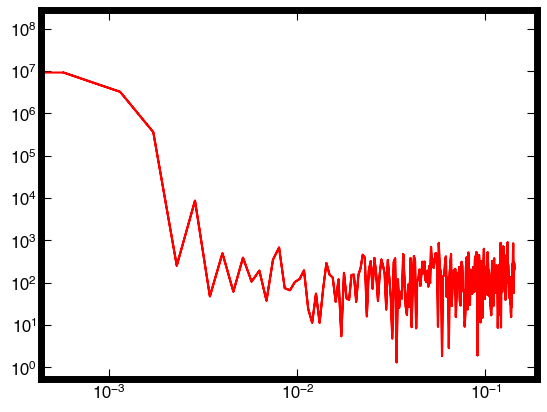

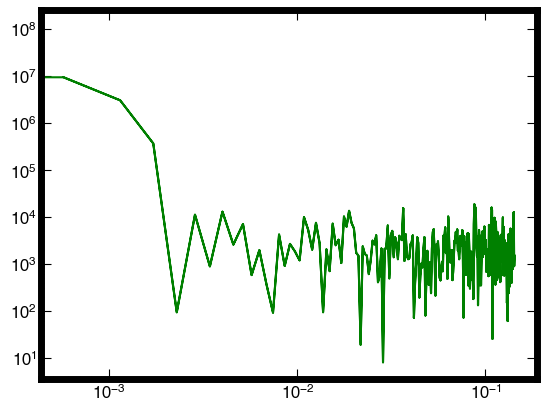

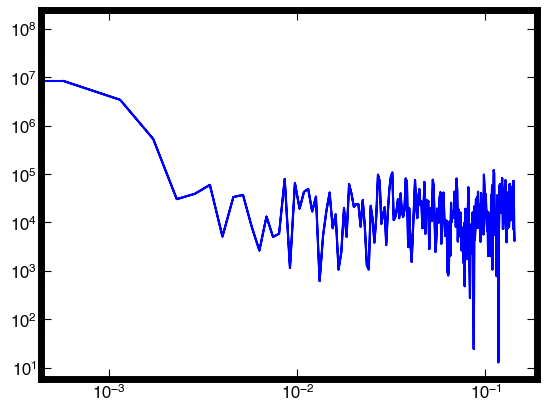

In [42]:
### ----- calculate spectra for noise ------ ###
N = 500 #len(psd_Zp.freq)  # Number of samples
refspec, sn = [], []
for i, vv in enumerate([5, 20, 60]):
    speed = 200
    noise_level = vv  # Amplitude of the noise in km/s
    sample_rate = 3.5

    # Generate a constant signal with some noise
    signal = np.ones(N) * speed
    noise = np.random.normal(0, noise_level, N)  # Generate random noise
    data_km_per_s = signal + noise
    sn.append(data_km_per_s)
    refspec.append(windowed_psd_noise(data_km_per_s, sample_rate))

## Density Noise

3


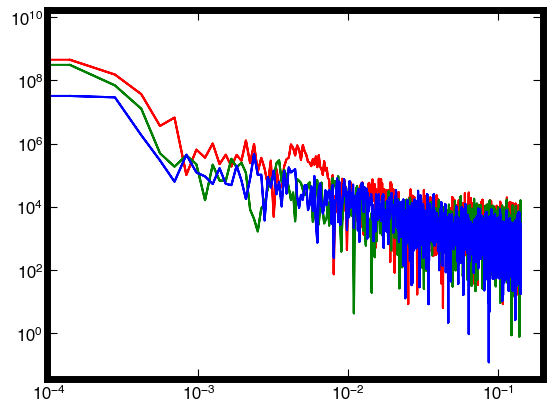

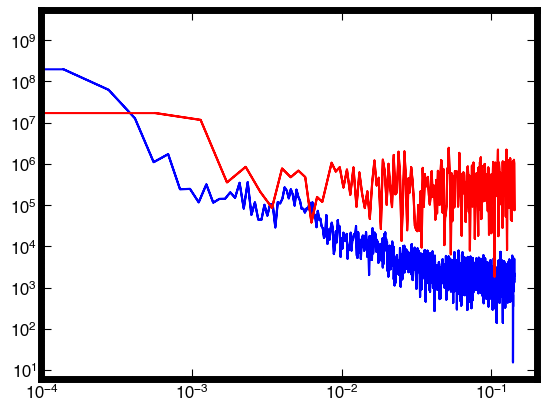

In [26]:
dens = [t1.Np[i*ss:i*ss+ss] for i in range(0, ii)]
dens = windowed_psd(dens)
plt.figure()
plt.loglog(dens.freq, dens.power, c='b', label='v - b')
plt.loglog(refspec_Np[0].freq, refspec_Np[0].power, c='red')

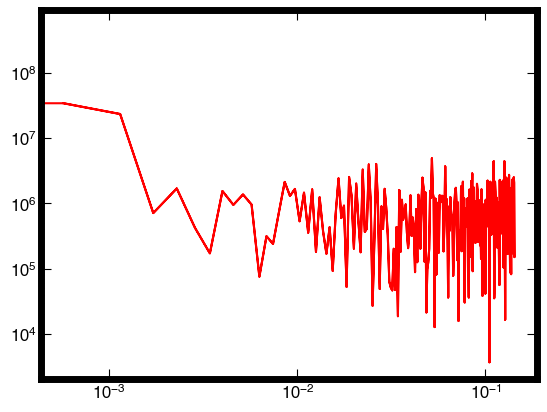

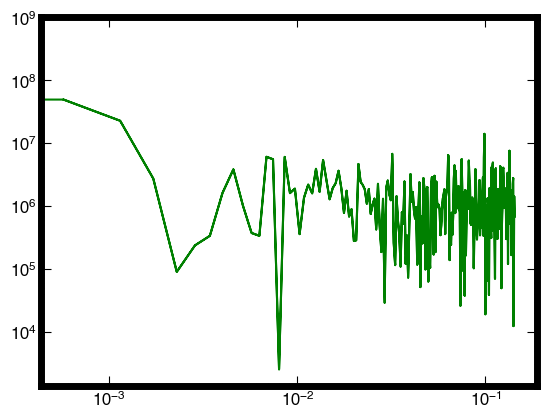

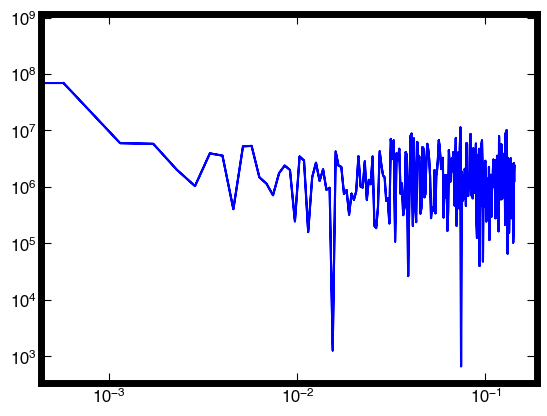

In [21]:
### ----- calculate spectra for noise ------ ###
N = 500 #len(psd_Zp.freq)  # Number of samples
refspec_Np, sn_Np = [], []
for i, vv in enumerate([np.nanmean(t1.Np) - 100, np.nanmean(t1.Np), np.nanmean(t1.Np) + 100]):
    speed =  np.nanmean(t1.Np)
    noise_level = vv  # Amplitude of the noise in km/s
    sample_rate = 3.5

    # Generate a constant signal with some noise
    signal = np.ones(N) * speed
    noise = np.random.normal(0, noise_level, N)  # Generate random noise
    data_km_per_s = signal + noise
    sn_Np.append(data_km_per_s)
    refspec_Np.append(windowed_psd_noise(data_km_per_s, sample_rate))

## Noise Comparison -- Visual

In [ ]:
# Plot the PSD

fig, [ax2, ax3] = plt.subplots(1, 2, figsize=[20, 6], sharey='all')
colors = ['blue', 'orange', 'green', 'red']
labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']

# ##### NOISE COMPARISON #####
lab = ['5 km/s', '10 km/s', '50 km/s']
col = ['purple', 'gold', 'pink']
# xy=[0, 50, 100]
# for i, xx in enumerate(sn):
#     ax1.plot(xx+xy[i], c=col[i], label=lab[i])

# ax1.set_ylabel('Offset 50 km/s between each')
# ax1.set_title('Noise Comparisons')
# ax1.legend()

##### SPECTRA #####
freq = psd_Zp.freq
for i, psd_spec in enumerate([psd_Zp, psd_Zm, psd_dv, psd_db]):
    ax2.plot(psd_spec.freq, psd_spec.power, c=colors[i], label=labels[i], linewidth=1)

ax2.legend(loc='upper right')
ax2.set_title('Power Spectral Density (PSD)')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_xscale('log')  
ax2.set_yscale('log')
ax2.grid(True)

##### NOISE + SPECTRA #####
for i, psd_spec in enumerate([psd_Zp, psd_Zm, psd_dv, psd_db]):
    ax3.plot(psd_spec.freq, psd_spec.power, c=colors[i], label=labels[i], linewidth=1)
ax3.plot(refspec[0].freq, refspec[0].power, label='1 km/s', color=col[0])
ax3.plot(refspec[1].freq, refspec[1].power, label='3 km/s', color=col[1])
ax3.plot(refspec[2].freq, refspec[2].power, label='6 km/s', color=col[2])
ax3.legend(loc='upper right')
ax3.set_title('Velocity Power Spectral Density (PSD)')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('PSD')  
ax3.set_xscale('log')  
ax3.set_yscale('log')
ax3.grid(True)
# plt.savefig('PSD.png')


plt.suptitle('Encounter 15 Turbulence Properties')
plt.show()

# Appendix B: Figure 10 

- Panel (a): Timeseries of offset values
- Panel (b): PSD plot of noise measurements (log/log)

In [ ]:
# Plot the PSD

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[20, 7])

labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']

##### NOISE COMPARISON #####
ax = ax1
# lab = [r'$\rm 1 \; km \; s^{-1}$', r'$\rm 3 \; km \; s^{-1}$', r'$\rm 5 \; km \; s^{-1}$']

lab = [r'$\rm 5 \; km \; s^{-1}$', r'$\rm 25 \; km \; s^{-1}$', r'$\rm 60 \; km \; s^{-1}$']
col = ['tab:blue', 'tab:green', 'tab:red']
xy=[0, -100, -300]
for i, xx in enumerate(sn):
    ax1.plot(xx+xy[i], c=col[i], label=lab[i])

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_ylabel(r'$\rm Velocity \; Timeseries$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
ax.set(ylim=(-300, 300), yticklabels=[])

##### SPECTRA #####
ax = ax2
ax.plot(refspec[0].freq, refspec[0].power, label=r'$\rm 5 \; km \; s^{-1}$', color=col[0])
ax.plot(refspec[1].freq, refspec[1].power, label=r'$\rm 25 \; km \; s^{-1}$', color=col[1])
ax.plot(refspec[2].freq, refspec[2].power, label=r'$\rm 50 \; km \; s^{-1}$', color=col[2])

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log') 
ax.set_ylim(5e-2, 5e7) 
ax.set_yticks([1e-1, 1e1, 1e3, 1e5, 1e7])
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

### LEGEND
R_patch = mpatches.Patch(label=r'$\rm 5 \; km \; s^{-1}$', edgecolor='k', facecolor=col[0])
T_patch = mpatches.Patch(label=r'$\rm 25 \; km \; s^{-1}$', edgecolor='k', facecolor=col[1])
N_patch = mpatches.Patch(label=r'$\rm 60 \; km \; s^{-1}$', edgecolor='k', facecolor=col[2])
leg0 = ax.legend(handles=[R_patch, T_patch, N_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)

### SAVE FIGURE
plt.savefig(os.path.join(FIG_DIR, 'fig13.png'), bbox_inches='tight')
plt.savefig(os.path.join(EPS_DIR, 'fig13.eps'), bbox_inches='tight')


# Appendix B: Figure 11
- Comparison between each spectral PSD and noise level for both periods

- Row One: first E15 sub-Alfvenic portion
- Row Two: second E15 sub-Alfvenic portion

## Final Figure

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


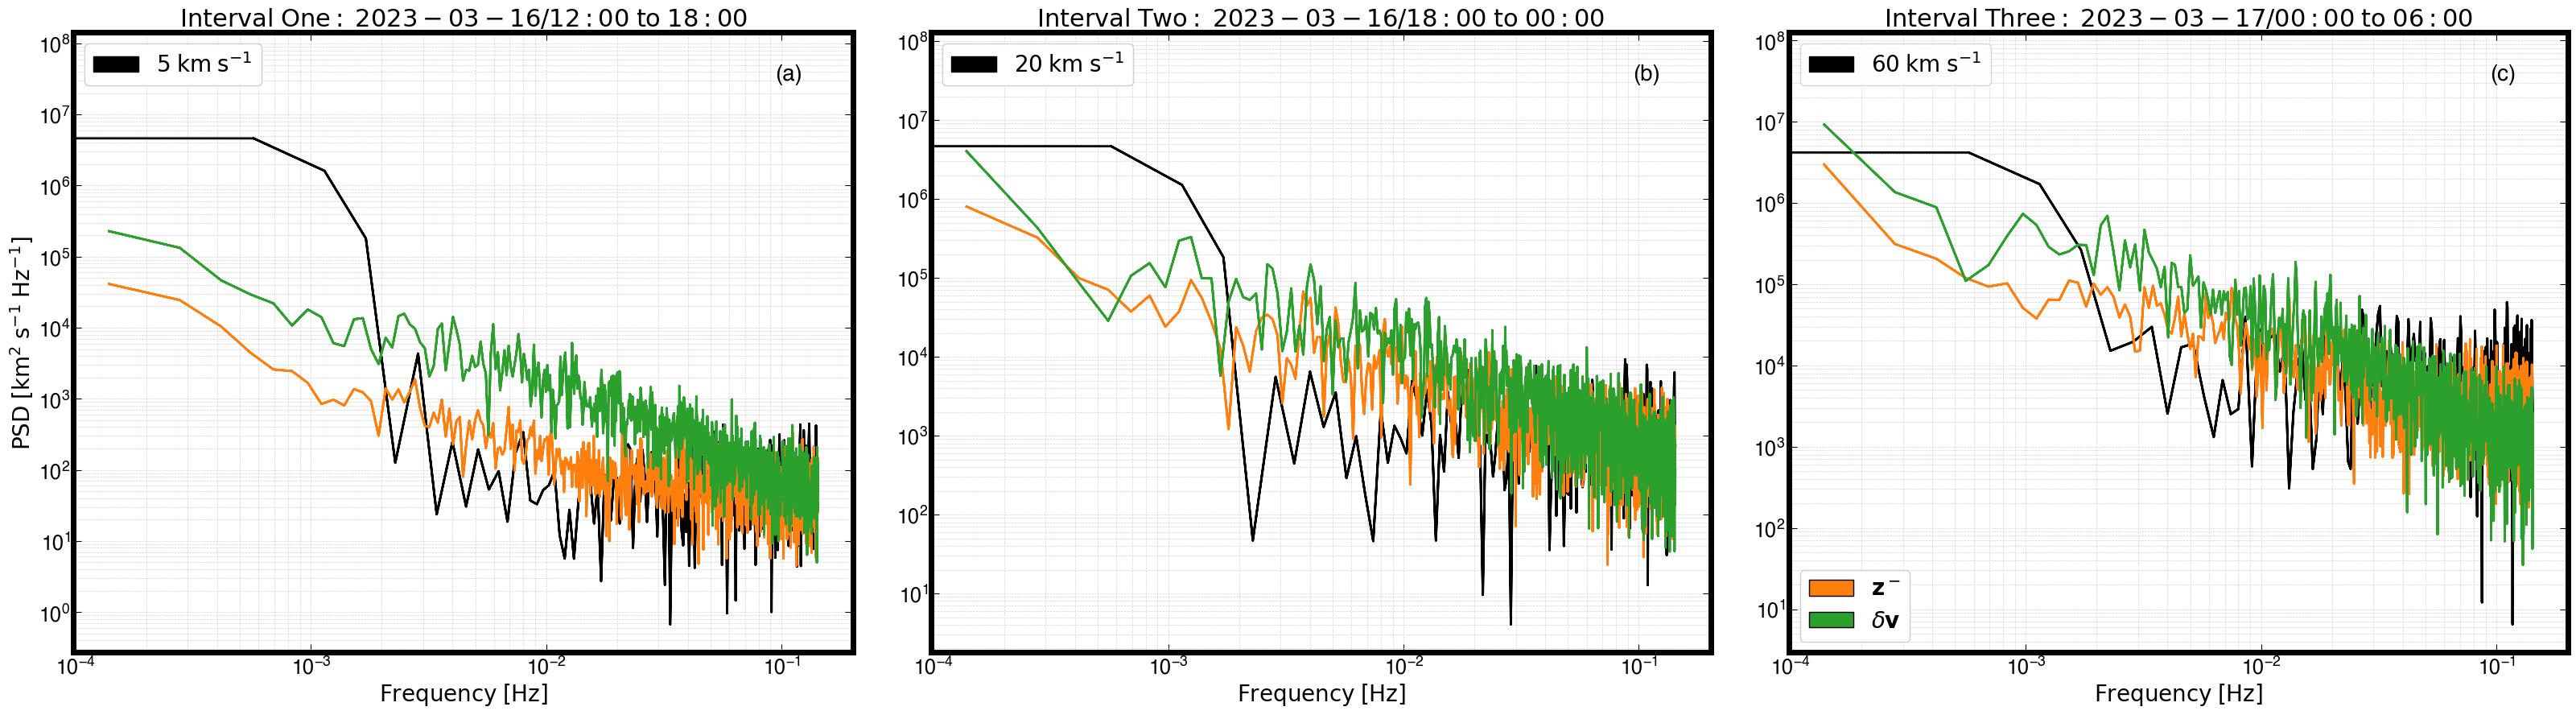

In [57]:
# Plot the PSD
lw=2
fig, axs = plt.subplots(1, 3, figsize=[40, 10], sharex='all', gridspec_kw={'wspace':0.1, 'hspace':0.18})
col = ['tab:blue', 'tab:orange', 'tab:red']

# labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']
labels = [r'$\rm Interval \; One: \; 2023-03-16/12:00 \; to \; 18:00$', 
          r'$\rm Interval \; Two: \; 2023-03-16/18:00 \; to \; 00:00$',
          r'$\rm Interval \; Three: \; 2023-03-17/00:00 \; to \; 06:00$']

##### ----- FAKE SPECTRA - PERIOD ONE ---- #####
panels = ['(a)', '(b)', '(c)']
for i, ax in enumerate(axs):
    # ax.plot(refspec[0].freq, refspec[0].power, label=r'$\rm 5 \; km \; s^{-1}$', linewidth=lw, color=col[0])
    # ax.plot(refspec[1].freq, refspec[1].power, label=r'$\rm 25 \; km \; s^{-1}$', linewidth=lw, color=col[1])
    # ax.plot(refspec[2].freq, refspec[2].power, label=r'$\rm 60 \; km \; s^{-1}$', linewidth=lw, color=col[2])
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
    ax.tick_params(axis='both', which='major', labelsize=18) 
    ax.text(0.90, 0.95, panels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
    ax.set_xscale('log')  
    ax.set_yscale('log')  

axs[0].plot(refspec[0].freq, refspec[0].power, label=r'$\rm 5 \; km \; s^{-1}$', linewidth=lw, color='k')
axs[1].plot(refspec[1].freq, refspec[1].power, label=r'$\rm 25 \; km \; s^{-1}$', linewidth=lw, color='k')
axs[2].plot(refspec[2].freq, refspec[2].power, label=r'$\rm 60 \; km \; s^{-1}$', linewidth=lw, color='k')
R_patch = mpatches.Patch(label=r'$\rm 5 \; km \; s^{-1}$',  edgecolor='k', facecolor='k')
T_patch = mpatches.Patch(label=r'$\rm 20 \; km \; s^{-1}$', edgecolor='k', facecolor='k')
N_patch = mpatches.Patch(label=r'$\rm 60 \; km \; s^{-1}$', edgecolor='k', facecolor='k')
leg0 = axs[0].legend(handles=[R_patch], loc='upper left', fontsize=20)
axs[0].add_artist(leg0)
leg0 = axs[1].legend(handles=[T_patch], loc='upper left', fontsize=20)
axs[1].add_artist(leg0)
leg0 = axs[2].legend(handles=[N_patch], loc='upper left', fontsize=20)
axs[2].add_artist(leg0)

##### ------ REAL SPECTRA - PERIOD ONE #####
for i, [psd_spec, psddv] in enumerate(zip([psd_Zm, psd_Zm2, psd_Zm3], [psd_dv, psd_dv2, psd_dv3])):
    good = np.logical_and(np.array(psd_spec.freq)<=1, np.array(psd_spec.freq)>=1e-4)
    axs[i].plot(psd_spec.freq[good], psd_spec.power[good], c='tab:orange', linewidth=lw, zorder=4)
    axs[i].plot(psddv.freq[good], psddv.power[good], c='tab:green', linewidth=lw, zorder=4)
    axs[i].set_title(labels[i], fontsize=22)
    axs[i].set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
axs[0].set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)

### ADD PANEL LABELS 
# fig.text(0.09, 0.5, r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20, va='center', rotation='vertical')
# fig.text(0.475, 0.05, r'$\rm Frequency \; [Hz]$', fontsize=20, va='center', rotation='horizontal')

# ### TITLES
# fig.text(0.5, 0.93, r'$\rm Sub-Alfv\'enic \; Interval \; One: \; 2023-03-16/12:00 \; to \; 18:00$', fontsize=20, ha='center', va='center', rotation='horizontal') # period one
# fig.text(0.5, 0.50, r'$\rm Sub-Alfv\'enic \; Interval \; Two: \; 2023-03-17/00:00 \; to \; 16:00$', fontsize=20, ha='center', va='center', rotation='horizontal') # period two

### LEGEND
# ax = axs[0]
# R_patch = mpatches.Patch(label=r'$\rm 5 \; km \; s^{-1}$',  edgecolor='k', facecolor=col[0])
# T_patch = mpatches.Patch(label=r'$\rm 20 \; km \; s^{-1}$', edgecolor='k', facecolor=col[1])
# N_patch = mpatches.Patch(label=r'$\rm 60 \; km \; s^{-1}$', edgecolor='k', facecolor=col[2])
# leg0 = ax.legend(handles=[R_patch, T_patch, N_patch], loc='upper left', fontsize=20)
# ax.add_artist(leg0)

### LEGEND ###
zm_patch = mpatches.Patch(edgecolor='k', facecolor='tab:orange', label=r'$\mathbf{z}^-$')
# zm_patch = mpatches.Patch(edgecolor='k', facecolor=colors[1], label=labels[1])
dv_patch = mpatches.Patch(edgecolor='k', facecolor='tab:green', label=r'$\delta \mathbf{v}$')
# db_patch = mpatches.Patch(edgecolor='k', facecolor=colors[3], label=labels[3])
leg0 = ax.legend(handles=[zm_patch, dv_patch], loc='lower left', fontsize=20)
ax.add_artist(leg0)


plt.savefig(os.path.join(FIG_DIR, 'fig14.png'), bbox_inches='tight')
plt.savefig(os.path.join(EPS_DIR, 'fig14.eps'), bbox_inches='tight')


## Two Rows

In [ ]:
# Plot the PSD
lw=2
fig, axs = plt.subplots(2, 4, figsize=[30, 12], sharex='all', sharey='row', gridspec_kw={'wspace':0.1, 'hspace':0.18})
col = ['tab:blue', 'tab:green', 'tab:red']

labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']

##### ----- FAKE SPECTRA - PERIOD ONE ---- #####
axx = axs[0]
panels = ['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate(axx):
    ax.plot(refspec[0].freq, refspec[0].power, label=r'$\rm 1 \; km \; s^{-1}$', color=col[0])
    ax.plot(refspec[1].freq, refspec[1].power, label=r'$\rm 3 \; km \; s^{-1}$', color=col[1])
    ax.plot(refspec[2].freq, refspec[2].power, label=r'$\rm 5 \; km \; s^{-1}$', color=col[2])
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
    ax.tick_params(axis='both', which='major', labelsize=18) 
    ax.text(0.90, 0.95, panels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
    ax.set_xscale('log')  
    ax.set_yscale('log')  
        
##### ----- FAKE SPECTRA - PERIOD TWO ---- #####
axx = axs[1]
panels = ['(e)', '(f)', '(g)', '(h)']
for i, ax in enumerate(axx):
    ax.plot(refspec[0].freq, refspec[0].power, label=r'$\rm 1 \; km \; s^{-1}$', color=col[0])
    ax.plot(refspec[1].freq, refspec[1].power, label=r'$\rm 3 \; km \; s^{-1}$', color=col[1])
    ax.plot(refspec[2].freq, refspec[2].power, label=r'$\rm 5 \; km \; s^{-1}$', color=col[2])
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
    ax.tick_params(axis='both', which='major', labelsize=18) 
    ax.text(0.90, 0.95, panels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
    ax.set_xscale('log')  
    ax.set_yscale('log')  


##### ------ REAL SPECTRA - PERIOD ONE #####
freq = psd_Zp.freq
good = np.logical_and(np.array(freq)<=1, np.array(freq)>=1e-4)
for i, psd_spec in enumerate([psd_Zp, psd_Zm, psd_dv, psd_db]):
    axs[0][i].plot(psd_spec.freq[good], psd_spec.power[good], c='k', linewidth=lw, zorder=4)
    axs[0][i].set_title(labels[i])
    
##### ------ REAL SPECTRA - PERIOD TWO #####
freq = psd_Zp2.freq
good = np.logical_and(np.array(freq)<=1, np.array(freq)>=1e-4)
for i, psd_spec in enumerate([psd_Zp2, psd_Zm2, psd_dv2, psd_db2]):
    axs[1][i].plot(psd_spec.freq[good], psd_spec.power[good], c='k', linewidth=lw, zorder=4)

### ADD PANEL LABELS 
fig.text(0.09, 0.5, r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20, va='center', rotation='vertical')
fig.text(0.475, 0.05, r'$\rm Frequency \; [Hz]$', fontsize=20, va='center', rotation='horizontal')

### TITLES
fig.text(0.5, 0.93, r'$\rm Sub-Alfv\'enic \; Interval \; One: \; 2023-03-16/12:00 \; to \; 18:00$', fontsize=20, ha='center', va='center', rotation='horizontal') # period one
fig.text(0.5, 0.50, r'$\rm Sub-Alfv\'enic \; Interval \; Two: \; 2023-03-17/00:00 \; to \; 16:00$', fontsize=20, ha='center', va='center', rotation='horizontal') # period two

### LEGEND
ax = axs[0][0]
R_patch = mpatches.Patch(label=r'$\rm 1 \; km \; s^{-1}$', color=col[0])
T_patch = mpatches.Patch(label=r'$\rm 3 \; km \; s^{-1}$', color=col[1])
N_patch = mpatches.Patch(label=r'$\rm 5 \; km \; s^{-1}$', color=col[2])
leg0 = ax.legend(handles=[R_patch, T_patch, N_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)

# plt.savefig(os.path.join(FIG_DIR, 'fig11.png'), bbox_inches='tight')
# plt.savefig(os.path.join(EPS_DIR, 'fig11.eps'), bbox_inches='tight')


### Only One Period: Figure 11

In [ ]:
# Plot the PSD

fig, axs = plt.subplots(1, 4, figsize=[30, 6], sharex='all', sharey='all', gridspec_kw={'wspace':0.1})
col = ['tab:blue', 'tab:green', 'tab:red']
panels = ['(a)', '(b)', '(c)', '(d)']
labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']

##### ----- FAKE SPECTRA ---- #####
for i, ax in enumerate(axs):
    ax.plot(freq, refspec[0], label=r'$\rm 1 \; km \; s^{-1}$', color=col[0])
    ax.plot(freq, refspec[1], label=r'$\rm 3 \; km \; s^{-1}$', color=col[1])
    ax.plot(freq, refspec[2], label=r'$\rm 5 \; km \; s^{-1}$', color=col[2])
    ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
    ax.tick_params(axis='both', which='major', labelsize=18) 
    ax.text(0.90, 0.95, panels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
    ax.set_xscale('log')  
    ax.set_yscale('log')  
    ax.set_title(labels[i])

##### ------ REAL SPECTRA #####
for i, psd_spec in enumerate([psd_Zp, psd_Zm, psd_dv, psd_db]):
    axs[i].plot(psd_spec.freq[good], psd_spec.power[good], c='k', linewidth=lw, zorder=4)

### ADD PANEL LABELS
axs[0].set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
axs[0].legend(loc='lower left', fontsize=20)


# plt.savefig(os.path.join(FIG_DIR, 'fig11.png'), bbox_inches='tight')
# plt.savefig(os.path.join(EPS_DIR, 'fig11.png'), bbox_inches='tight')
plt.show()

In [ ]:
freq = psd_Zp.freq
good = np.logical_and(np.array(freq)<=1, np.array(freq)>=1e-4)
fig, axs = plt.subplots(1, 4, figsize=(30, 6), sharey='all')
titles = ['Zp', 'Zm', 'dv', 'db']
for i, psd_spec in enumerate([psd_Zp, psd_Zm, psd_dv, psd_db]):
    axs[i].plot(psd_spec.freq[good], psd_spec.power[good], c=colors[i], label=labels[i], linewidth=1)
    axs[i].set_xscale('log')  
    axs[i].set_yscale('log')
    axs[i].set_title(titles[i])
# ax2.legend(loc='upper right')
# ax2.set_title('Power Spectral Density (PSD)')
# ax2.set_xlabel('Frequency (Hz)')
# ax2.grid(True)

# $\delta v$ Noise Comparison

1.) $\mathbf{z}^2_- - \delta \mathbf{b}^2 = \delta \mathbf{v}^2 - 2 \delta \mathbf{v} \cdot \delta \mathbf{b}$  
2.) Calculate PSD of above  
3.) Check if this reaches the noise floor

In [ ]:
### ------ STEP ONE: $\mathbf{z}^2_- - \delta \mathbf{b}^2 = \delta \mathbf{v}^2 - 2 \delta \mathbf{v} \cdot \delta \mathbf{b}$ 
colors = ['tab:green', 'tab:red', 'tab:blue', 'tab:orange']
labels=[r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$', r'$\mathbf{z}^+$', r'$\mathbf{z}^-$']
lw, lws =2, 4
ch, cl, clm, clmh = ['k', 'tab:pink', 'green', 'crimson']
zpc, zmc = ['k', 'k'] # slateblue
fig, axs = plt.subplots(1, 2, figsize=(13, 6), sharey='all')
titles = [r'$\mathbf{z}^2_- - \delta \mathbf{b}^2$', r'$\delta \mathbf{v}^2 - 2 \delta \mathbf{v} \cdot \delta \mathbf{b} $']

i=0
Zmdb = np.nanmean(tZm, axis=0)**2 - np.nanmean(tdb, axis=0)**2
axs[i].plot(Zmdb, c='k', linewidth=1)
axs[i].set_title(titles[i])

i=1
dvdb2 = (np.nanmean(tZp, axis=0)**2 - np.nanmean(tZm, axis=0)**2)/2
dvdot = np.nanmean(tdv, axis=0)**2 - dvdb2
axs[i].plot(dvdot, c=colors[i], label=labels[i], linewidth=1)
axs[i].set_title(titles[i])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6), sharey='all')
titles = [r'$\mathbf{z}^2_- - \delta \mathbf{b}^2$', r'$\delta \mathbf{v}^2 - 2 \delta \mathbf{v} \cdot \delta \mathbf{b} $']

i=0
Zmdb = np.nanmean(tZm, axis=0)**2 - np.nanmean(tdb, axis=0)**2
axs[i].plot(np.nanmean(tZm, axis=0)**2, c='red', label=r'$\mathbf{z}^2_-$', linewidth=1)
axs[i].plot(np.nanmean(tdv, axis=0)**2, c='b', label=r'$\delta \mathbf{v}^2$', linewidth=1)
axs[i].legend()
# axs[i].set_title(titles[i])

i=1
dvdb2 = (np.nanmean(tZp, axis=0)**2 - np.nanmean(tZm, axis=0)**2)/2
dvdot = np.nanmean(tdv, axis=0)**2 - dvdb2
axs[i].plot(np.nanmean(tdb, axis=0)**2, c='red', label=r'$\delta \mathbf{b}^2$', linewidth=1)
axs[i].plot(dvdb2, c='b', label=r'$2 \delta \mathbf{v} \cdot \delta \mathbf{b}$', linewidth=1)
axs[i].legend()
# axs[i].set_title(titles[i])

In [ ]:
### ------ STEP TWO: Calculate PSD

### Zmdb
Zmdb = [turb.Zm[i*ss:i*ss+ss]**2 - turb.deltab[i*ss:i*ss+ss]**2 for i in range(0, ii)]
psd_Zmdb = windowed_psd(Zmdb)

### dvdot
dvdot = [turb.deltav[i*ss:i*ss+ss]**2 - (turb.Zp[i*ss:i*ss+ss]**2 - turb.Zm[i*ss:i*ss+ss]**2)/2 for i in range(0, ii)]
psd_dvdot = windowed_psd(dvdot)

### PLOT PSD
freq = psd_Zmdb.freq
good = np.logical_and(np.array(freq)<=1, np.array(freq)>=1e-4)
fig, axs = plt.subplots(1, 4, figsize=(30, 6))
titles = [r'$\mathbf{z}^2_- - \delta \mathbf{b}^2$', r'$\delta \mathbf{v}^2 - 2 \delta \mathbf{v} \cdot \delta \mathbf{b} $',
          r'$\mathbf{z}^2_- - \delta \mathbf{b}^2$', r'$\delta \mathbf{v}^2 - 2 \delta \mathbf{v} \cdot \delta \mathbf{b} $']

i=0
Zmdb = np.nanmean(tZm, axis=0)**2 - np.nanmean(tdb, axis=0)**2
axs[i].plot(Zmdb, c='k', linewidth=1)
axs[i].plot(tZm[2]**2 - tdb[2]**2)
axs[i].set_title(titles[i])

i=1
dvdb2 = (np.nanmean(tZp, axis=0)**2 - np.nanmean(tZm, axis=0)**2)/2
dvdot = np.nanmean(tdv, axis=0)**2 - dvdb2
axs[i].plot(dvdot[2], c=colors[i], label=labels[i], linewidth=1)
axs[i].set_title(titles[i])

i=2
axs[i].loglog(psd_Zmdb.freq, psd_Zmdb.power, c='k', linewidth=1)
axs[i].set_title(titles[i])

i=3
axs[i].loglog(psd_dvdot.freq, psd_dvdot.power, c=colors[i], label=labels[i], linewidth=1)
axs[i].set_title(titles[i])

## Fourier Domain

$ \tilde{v}\tilde{v}* +\tilde{b}\tilde{b}* \pm (\tilde{v}\tilde{b}* +\tilde{v}*\tilde{b})$

In [ ]:
### CALCULATE Zp & Zm
N =  len(tdv[0])
vtild = np.fft.fft(tdv) # np.array(psd_dv.power)
vtildc = np.fft.fft(tdv).conj() # np.array(psd_dv.power).conj()
btild = np.fft.fft(tdb) # np.array(psd_db.power)
btildc = np.fft.fft(tdb).conj() #  np.array(psd_db.power).conj()
Zpf = vtild * vtildc + btild*btildc + (vtild * btildc + vtildc * btild)
Zpf = np.mean(Zpf, axis=0)/N
Zmf = vtild * vtildc + btild*btildc - (vtild * btildc + vtildc * btild)
Zmf = np.mean(Zmf, axis=0)/N

Gvv = (vtild * vtildc)
Gbb = (btild * btildc)
Gvb = (vtild * btildc + vtildc * btild)/2
coherence = np.abs(Gvb)**2 / (Gvv*Gbb)
coherence = np.mean(coherence, axis=0)

### CALCULATE UNNORMALIZED PSD FOR ZM AND ZP 
Zppsd = np.fft.fft(tZp) * np.fft.fft(tZp).conj()
Zppsd = np.abs(np.fft.fft(tZp))**2
Zppsd = np.mean(Zppsd, axis=0)/N

Zmpsd = np.fft.fft(tZm) * np.fft.fft(tZm).conj()
Zmpsd = np.abs(np.fft.fft(tZm))**2
Zmpsd = np.mean(Zmpsd, axis=0)/N

### PLOT# Plot the PSD
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=[20, 8], sharex='all', sharey='all', gridspec_kw={'hspace': 0.05, 'wspace':0.1})
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels=[r'$\mathbf{z}^+$', r'$\mathbf{z}^-$', r'$\delta \mathbf{v}$', r'$\delta \mathbf{b}$']
lw=2
##### -------- ELASSER SPECTRA #####
ax = ax1
good = np.logical_and(np.array(psd_Zp.freq)<=1, np.array(psd_Zp.freq)>=1e-4)
ax.plot(psd_Zp.freq[good], Zppsd[good], c=colors[0], label='Org Zp', linewidth=lw)
ax.plot(psd_Zp.freq[good], Zpf[good], c=colors[1], label='Fourier Zp', linewidth=lw)
ax.axvline(8e-2, c='k', linestyle='dashed', lw=2, zorder=0)

### LEGEND
ax.legend(loc='lower left', fontsize=20)

### ADD PANEL LABELS
ax.text(0.92, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.set_ylabel(r'$\rm PSD \; [km^2 \; s^{-1} \; Hz^{-1}]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.set_xscale('log')  
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')

##### -------- PANEL TWO: SPECTRAL FITS #####
freq = psd_Zp.freq
good = np.logical_and(np.array(freq)<=1, np.array(freq)>=1e-4)
ax = ax2
good = np.logical_and(np.array(psd_Zp.freq)<=1, np.array(psd_Zp.freq)>=1e-4)
ax.plot(psd_Zm.freq[good], Zmpsd[good], c=colors[0], label='Org Zm', linewidth=lw)
ax.plot(psd_Zm.freq[good], Zmf[good], c=colors[1], label='Fourier Zm', linewidth=lw)
ax.axvline(8e-2, c='k', linestyle='dashed', lw=2, zorder=0)

### LEGEND
ax.legend(loc='lower left', fontsize=20)

### LABELS
ax.text(0.92, 0.95, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 

### SCALES
ax2.set_xscale('log')  
ax2.set_yscale('log')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray', zorder=-4)
ax.axvline(8e-2, c='k', linestyle='dashed', lw=2, zorder=-1)

##### -------- PANEL THREE: SPECTRAL FITS #####
ax = ax3.twinx()
ax.loglog(psd_Zm.freq, coherence, c='k', lw=lw, label='Cross Spectra')
### LABELS
ax.text(0.92, 0.95, '(c)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18) 
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray', zorder=-4)


# ##### ----- FAKE SPECTRA ---- #####
# col = ['tab:blue', 'tab:green', 'tab:red']
# refspec =[np.abs(np.fft.fft(tt))**2/N for tt in sn]
# # for i, ax in enumerate(axs):
# ax.plot(freq, refspec[0], label=r'$\rm 1 \; km \; s^{-1}$', color=col[0])
# ax.plot(freq, refspec[1], label=r'$\rm 3 \; km \; s^{-1}$', color=col[1])
# ax.plot(freq, refspec[2], label=r'$\rm 5 \; km \; s^{-1}$', color=col[2])
# ax.set_xlabel(r'$\rm Frequency \; [Hz]$', fontsize=20)
# ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
# ax.tick_params(axis='both', which='major', labelsize=18) 
# # ax.text(0.90, 0.95, panels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
# ax.set_xscale('log')  
# ax.set_yscale('log')  
# ax.set_title(labels[i])
# ax.legend()
### SAVE FIGURE
# plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'psd2.png')), bbox_inches='tight')

 
